In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from geopy.geocoders import Nominatim
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px
from collections import Counter
import us
from geopy.distance import geodesic



In [297]:
df=pd.read_csv('DS-jobs - DS-jobs.csv')
df.head()

index          Job Title               Salary Estimate  \
0      0  Sr Data Scientist  $137K-$171K (Glassdoor est.)   
1      1     Data Scientist  $137K-$171K (Glassdoor est.)   
2      2     Data Scientist  $137K-$171K (Glassdoor est.)   
3      3     Data Scientist  $137K-$171K (Glassdoor est.)   
4      4     Data Scientist  $137K-$171K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Description\n\nThe Senior Data Scientist is re...     3.1   
1  Secure our Nation, Ignite your Future\n\nJoin ...     4.2   
2  Overview\n\n\nAnalysis Group is one of the lar...     3.8   
3  JOB DESCRIPTION:\n\nDo you have a passion for ...     3.5   
4  Data Scientist\nAffinity Solutions / Marketing...     2.9   

              Company Name       Location            Headquarters  \
0         Healthfirst\n3.1   New York, NY            New York, NY   
1             ManTech\n4.2  Chantilly, VA             Herndon, VA   
2      Analysis Group\n3.8     Boston, MA              Boston, MA   
3             INFICON\n3.5     Newton, MA  Bad Ragaz, Switzerland   
4  Affinity Solutions\n2.9   New York, NY            New York, NY   

                      Size  Founded        Type of ownership  \
0   1001 to 5000 employees     1993   Nonprofit Organization   
1  5001 to 10000 employees     1968         Company - Public   
2   1001 to 5000 employees     1981  Private Practice / Firm   
3    501 to 1000 employees     2000         Company - Public   
4      51 to 200 employees     1998        Company - Private   

                                Industry             Sector  \
0                     Insurance Carriers          Insurance   
1                 Research & Development  Business Services   
2                             Consulting  Business Services   
3  Electrical & Electronic Manufacturing      Manufacturing   
4                Advertising & Marketing  Business Services   

                      Revenue  \
0    Unknown / Non-Applicable   
1      $1 to $2 billion (USD)   
2  $100 to $500 million (USD)   
3  $100 to $500 million (USD)   
4    Unknown / Non-Applicable   

                                         Competitors  
0            EmblemHealth, UnitedHealth Group, Aetna  
1                                                 -1  
2                                                 -1  
3  MKS Instruments, Pfeiffer Vacuum, Agilent Tech...  
4               Commerce Signals, Cardlytics, Yodlee

# 1.Data Cleaning and Preprocessing
# 2.Exploratory Data Analysis (EDA)
# 3. Data Transformation
# 4.Comparative Analysis
# 5.Advanced Data Insights and Parsing
# 6.Visualization

1.Data Cleaning and Preprocessing

1.Detailed Parsing of Salary Information

In [3]:
df.dtypes

index                  int64
Job Title             object
Salary Estimate       object
Job Description       object
Rating               float64
Company Name          object
Location              object
Headquarters          object
Size                  object
Founded                int64
Type of ownership     object
Industry              object
Sector                object
Revenue               object
Competitors           object
dtype: object

In [299]:
df['Salary Estimate'].apply(type).value_counts()

Salary Estimate
<class 'str'>    672
Name: count, dtype: int64

Remove Currency Symbols: Remove ”$” or other currency symbols from ”Salary Estimate” to simplify the salary parsing process.


In [300]:
df['Salary Estimate']=df['Salary Estimate'].str.replace('$','',regex=False)
df['Salary Estimate']=df['Salary Estimate'].str.replace('(Glassdoor est.)','',regex=False)
df['Salary Estimate']=df['Salary Estimate'].str.replace('(Employer est.)','',regex=False)
df['Salary Estimate'].value_counts()


Salary Estimate
75K-131K      32
79K-131K      32
99K-132K      32
137K-171K     30
90K-109K      30
56K-97K       22
90K-124K      22
79K-106K      22
101K-165K     21
91K-150K      21
124K-198K     21
110K-163K     21
112K-116K     21
122K-146K     21
138K-158K     21
92K-155K      21
128K-201K     21
212K-331K     21
69K-116K      21
95K-119K      21
141K-225K     20
145K-225K     20
87K-141K      20
79K-147K      20
66K-112K      20
31K-56K       20
105K-167K     20
80K-132K      20
71K-123K      19
79K-133K      19
Name: count, dtype: int64

Salary Type Extraction: Create a column that identifies whether the salary is presented as ”per year,” ”per hour,” etc., based on common indicators in ”Salary Estimate.”


In [301]:
df['Salary Type']='per_year'
df['Salary Type']


0      per_year
1      per_year
2      per_year
3      per_year
4      per_year
         ...   
667    per_year
668    per_year
669    per_year
670    per_year
671    per_year
Name: Salary Type, Length: 672, dtype: object

2.Handle Special Characters in Text Columns:

Text Standardization: Remove or replace special characters (e.g.,”\n”, ”\t”, and other symbols) from columns like ”Job Description”and ”Company Name” for consistency.


In [302]:
df['Job Description'] =df['Job Description'].str.replace('[^A-Za-z0-9]', ' ', regex=True)
df['Job Description'] 

0      Description  The Senior Data Scientist is resp...
1      Secure our Nation  Ignite your Future  Join th...
2      Overview   Analysis Group is one of the larges...
3      JOB DESCRIPTION   Do you have a passion for Da...
4      Data Scientist Affinity Solutions   Marketing ...
                             ...                        
667    Summary  We re looking for a data scientist to...
668    Job Description Become a thought leader within...
669    Join a thriving company that is changing the w...
670    100 Remote Opportunity As an AINLP Data Scient...
671    Description  The Data Scientist will be part o...
Name: Job Description, Length: 672, dtype: object

In [303]:
df['Company Name'] =df['Company Name'].str.replace(r'[\n]', ' ', regex=True)
df['Company Name']

0               Healthfirst 3.1
1                   ManTech 4.2
2            Analysis Group 3.8
3                   INFICON 3.5
4        Affinity Solutions 2.9
                 ...           
667                TRANZACT 3.6
668                        JKGT
669                  AccessHope
670    ChaTeck Incorporated 5.0
671           1-800-Flowers 2.7
Name: Company Name, Length: 672, dtype: object

Lowercasing: Convert all text columns (e.g., ”Job Title,” ”Company Name,” ”Industry”) to lowercase to standardize the format and avoid case sensitivity issues during analysis


In [304]:
lower_col=['Job Title','Job Description','Company Name','Location','Headquarters','Type of ownership','Industry','Sector','Competitors']
df[lower_col]=df[lower_col].apply(lambda x: x.str.lower())
df[lower_col]

Job Title                                    Job Description  \
0    sr data scientist  description  the senior data scientist is resp...   
1       data scientist  secure our nation  ignite your future  join th...   
2       data scientist  overview   analysis group is one of the larges...   
3       data scientist  job description   do you have a passion for da...   
4       data scientist  data scientist affinity solutions   marketing ...   
..                 ...                                                ...   
667     data scientist  summary  we re looking for a data scientist to...   
668     data scientist  job description become a thought leader within...   
669     data scientist  join a thriving company that is changing the w...   
670     data scientist  100 remote opportunity as an ainlp data scient...   
671     data scientist  description  the data scientist will be part o...   

                 Company Name           Location            Headquarters  \
0             healthfirst 3.1       new york, ny            new york, ny   
1                 mantech 4.2      chantilly, va             herndon, va   
2          analysis group 3.8         boston, ma              boston, ma   
3                 inficon 3.5         newton, ma  bad ragaz, switzerland   
4      affinity solutions 2.9       new york, ny            new york, ny   
..                        ...                ...                     ...   
667              tranzact 3.6       fort lee, nj            fort lee, nj   
668                      jkgt  san francisco, ca                      -1   
669                accesshope      irwindale, ca                      -1   
670  chateck incorporated 5.0  san francisco, ca         santa clara, ca   
671         1-800-flowers 2.7       new york, ny         carle place, ny   

           Type of ownership                               Industry  \
0     nonprofit organization                     insurance carriers   
1           company - public                 research & development   
2    private practice / firm                             consulting   
3           company - public  electrical & electronic manufacturing   
4          company - private                advertising & marketing   
..                       ...                                    ...   
667        company - private                advertising & marketing   
668                       -1                                     -1   
669                       -1                                     -1   
670        company - private                advertising & marketing   
671         company - public                              wholesale   

                Sector                                        Competitors  
0            insurance            emblemhealth, unitedhealth group, aetna  
1    business services                                                 -1  
2    business services                                                 -1  
3        manufacturing  mks instruments, pfeiffer vacuum, agilent tech...  
4    business services               commerce signals, cardlytics, yodlee  
..                 ...                                                ...  
667  business services                                                 -1  
668                 -1                                                 -1  
669                 -1                                                 -1  
670  business services                                                 -1  
671  business services                                                 -1  

[672 rows x 9 columns]

3. Company Name Refinement:

Remove Rating from Company Name: Clean up ”Company Name” by removing any appended rating values (e.g., ”Company Name\n3.8”).

In [305]:
x =df['Company Name'].str.split()
df['Cleaned_Company Name']=x.apply(lambda x: x[0])
df['Cleaned_Company Name']


0        healthfirst
1            mantech
2           analysis
3            inficon
4           affinity
           ...      
667         tranzact
668             jkgt
669       accesshope
670          chateck
671    1-800-flowers
Name: Cleaned_Company Name, Length: 672, dtype: object

Unique Company Identifier: Generate a unique identifier for each company based on the cleaned ”Company Name” to help with comparisons

In [306]:
df['Cleaned_Company Name'].unique()
df['identifier']=df.groupby(df['Cleaned_Company Name']).cumcount()
df['identifier'].value_counts()

identifier
0     414
1     146
2      40
3      20
4      13
5      10
6       8
7       6
8       5
9       5
10      3
11      2
Name: count, dtype: int64

4. Standardizing Location Data:

Expand State Abbreviations:For the ”Location” column, expand state abbreviations (e.g., ”CA” → ”California”) to ensure uniformity.


In [307]:
df['Location'].value_counts()

Location
san francisco, ca    69
new york, ny         50
washington, dc       26
boston, ma           24
chicago, il          22
                     ..
redmond, wa           1
west chester, pa      1
quantico, va          1
fort lee, nj          1
irwindale, ca         1
Name: count, Length: 207, dtype: int64

In [308]:
df['Loc']=df['Location'].map(lambda x: x)
x=df['Loc'].str.split(',').str[-1].str.strip().str.upper()
y=x
n=['REMOTE','UNITED STATES','UTAH','NEW JERSEY','CALIFORNIA','TEXAS','DC']

for i in range(0,len(x)):
    if x[i] not in n:
        y[i]=df['Loc'].str[:-2][i]+us.states.mapping('abbr','name')[x[i]]
    
    if x[i]=='DC':
         y[i]=df['Loc'].str[:-2][i]+('District of Columbia')
df['New_Location']=y.str.lower()
df['New_Location'].value_counts()

New_Location
san francisco, california           69
new york, new york                  50
washington, district of columbia    26
boston, massachusetts               24
chicago, illinois                   22
                                    ..
redmond, washington                  1
west chester, pennsylvania           1
quantico, virginia                   1
fort lee, new jersey                 1
irwindale, california                1
Name: count, Length: 207, dtype: int64

In [14]:
df['Headquarters'].unique()

array(['new york, ny', 'herndon, va', 'boston, ma',
       'bad ragaz, switzerland', 'santa barbara, ca',
       'basel, switzerland', 'bedford, ma', 'mountain view, ca',
       'chicago, il', 'mc lean, va', 'saint louis, mo', 'richland, wa',
       'northbrook, il', 'princeton, nj', 'mays landing, nj',
       'washington, dc', 'memphis, tn', 'tempe, az', 'reading, pa',
       'san francisco, ca', 'menlo park, ca', 'atlanta, ga',
       'orlando, fl', 'lexington, ma', 'falls church, va',
       'sheboygan, wi', 'seattle, wa', 'bellevue, wa', 'lincoln, ne',
       'chantilly, va', 'santa monica, ca', 'ewing, nj',
       'south san francisco, ca', 'palo alto, ca', 'singapore, singapore',
       'cambridge, ma', 'osaka, japan', 'santa clara, ca', 'vienna, va',
       'new orleans, la', 'akron, oh', 'zurich, switzerland',
       'woburn, ma', 'carson, ca', 'coral gables, fl', 'san ramon, ca',
       'brisbane, ca', 'winter park, fl', 'san rafael, ca',
       'deerfield, il', 'ipswich, ma',

In [309]:
df['HQ']=df['Headquarters'].map(lambda x: x)
x=df['HQ'].str.split(',').str[-1].str.strip().str.upper()
y=x
n=['REMOTE','FRANCE','CANADA','BERMUDA','ISRAEL','SWEDEN','UNITED STATES','UTAH','NEW JERSEY','CALIFORNIA','TEXAS','DC','INDIA','SWITZERLAND','SINGAPORE','JAPAN','UNITED KINGDOM','-1','061','SPAIN']

for i in range(0,len(x)):
    if x[i] not in n:
        y[i]=df['HQ'].str[:-2][i]+us.states.mapping('abbr','name')[x[i]]
    
    if x[i]=='DC':
         y[i]=df['HQ'].str[:-2][i]+('District of Columbia')
df['New_Headquarters']=y.str.lower()
df['New_Headquarters'].value_counts()

New_Headquarters
new york, new york            33
san francisco, california     31
-1                            31
chicago, illinois             23
boston, massachusetts         19
                              ..
littleton, colorado            1
san bruno, california          1
west chester, pennsylvania     1
utica, michigan                1
fort lee, new jersey           1
Name: count, Length: 219, dtype: int64

Location Format Consistency: Check for any inconsistent formats in ”Location” and ”Headquarters” and standardize to ”City, State” format.

In [310]:
df['New_Location'].unique()

array(['new york, new york', 'chantilly, virginia',
       'boston, massachusetts', 'newton, massachusetts',
       'santa barbara, california', 'cambridge, massachusetts',
       'bedford, massachusetts', 'san diego, california',
       'chicago, illinois', 'herndon, virginia', 'saint louis, missouri',
       'richland, washington', 'northbrook, illinois',
       'washington, district of columbia', 'remote', 'memphis, tennessee',
       'plano, texas', 'west grove, pennsylvania', 'phoenix, arizona',
       'appleton, wisconsin', 'atlanta, georgia', 'orlando, florida',
       'lexington, massachusetts', 'mclean, virginia',
       'san francisco, california', 'sheboygan, wisconsin',
       'united states', 'bothell, washington', 'lincoln, nebraska',
       'overland park, kansas', 'santa monica, california',
       'portsmouth, new hampshire', 'ewing, new jersey',
       'south san francisco, california', 'palo alto, california',
       'bellevue, washington', 'new orleans, louisiana', 

Distance Calculation: : If city and state information are available, create approximate distance calculations between ”Location” and ”Headquarters” to identify remote positions.


In [328]:
# geolocator = Nominatim(user_agent="my_user_agent")

# def distance_cal(low,high):
#     for i in range(low,high):
#         loc1=geolocator.geocode((df['New_Location'][i]))
#         loc2=geolocator.geocode((df['New_Headquarters'][i]))
        
#         if loc1 and loc2:
#             c1= (loc1.latitude,loc1.longitude) 
#             c2= (loc2.latitude,loc2.longitude)
#             df['Distance']=(geodesic(c1, c2).km)
#             print('Finding location between:',i,': ',df['New_Location'][i] , 'and ',df['New_Headquarters'][i],":",(geodesic(c1, c2).km))
#             time.sleep(1.5)
#         else:
#             df['Distance']=None
#             print('Finding location between:',i,': ',df['New_Location'][i] , 'and ',df['New_Headquarters'][i],'NONE')
#             time.sleep(1.5)




# Initialize the geolocator
geolocator = Nominatim(user_agent="geo_distance_calculator")

# for start in range(low, high, chunk_size):
#     end = min(start + chunk_size, high)  # Ensure end does not exceed high

for i in range(0,len(df['New_Location'])):
    loc1 = geolocator.geocode(df.at[i, 'New_Location'])
    loc2 = geolocator.geocode(df.at[i, 'New_Headquarters'])

    if loc1 and loc2:
        c1 = (loc1.latitude, loc1.longitude)
        c2 = (loc2.latitude, loc2.longitude)
        df.at[i, 'Distance'] = geodesic(c1, c2).km
        print(f'Finding location between {i}: {df.at[i, "New_Location"]} and {df.at[i, "New_Headquarters"]}: {df.at[i, "Distance"]} km')
    else:
        df.at[i, 'Distance'] = None
        print(f'Finding location between {i}: {df.at[i, "New_Location"]} and {df.at[i, "New_Headquarters"]} NONE')

    time.sleep(1.5)  # Sleep to avoid API rate limits

    

# Example Usage:
# df = pd.read_csv("your_file.csv")  # Load your DataFrame
# df.to_csv("updated_file.csv", index=False)  # Save the updated file

    

Finding location between 0: new york, new york and new york, new york: 0.0 km
Finding location between 1: chantilly, virginia and herndon, virginia: 10.82572743011451 km
Finding location between 2: boston, massachusetts and boston, massachusetts: 0.0 km
Finding location between 3: newton, massachusetts and switzerland: 6053.402694155559 km
Finding location between 4: new york, new york and new york, new york: 0.0 km
Finding location between 5: santa barbara, california and santa barbara, california: 0.0 km
Finding location between 6: cambridge, massachusetts and switzerland: 6044.438963812558 km
Finding location between 7: bedford, massachusetts and bedford, massachusetts: 0.0 km
Finding location between 8: san diego, california and mountain view, california: 685.4433887157538 km
Finding location between 9: chicago, illinois and chicago, illinois: 0.0 km
Finding location between 10: herndon, virginia and mc lean, virginia: 163.99088580456396 km
Finding location between 11: saint louis,

In [1]:
df['Distance'].value_counts()

NameError: name 'df' is not defined

5.	Revenue Column Parsing and Cleaning
Currency Standardization: Ensure all revenue values are in the same currency (e.g., USD) and handle conversions if any foreign currencies are detected.


In [18]:
df['Revenue'].unique()

array(['Unknown / Non-Applicable', '$1 to $2 billion (USD)',
       '$100 to $500 million (USD)', '$10+ billion (USD)',
       '$2 to $5 billion (USD)', '$500 million to $1 billion (USD)',
       '$5 to $10 billion (USD)', '$10 to $25 million (USD)',
       '$25 to $50 million (USD)', '$50 to $100 million (USD)',
       '$1 to $5 million (USD)', '$5 to $10 million (USD)',
       'Less than $1 million (USD)', '-1'], dtype=object)

Extract Revenue Range: For each value in ”Revenue,” extract minimum and maximum revenue values to separate columns.


In [19]:
df['Revenue']=df['Revenue'].replace('-1','Unknown')
df['Revenue']=df['Revenue'].replace('Unknown / Non-Applicable','Unknown')
df['Revenue']=df['Revenue'].str.replace('(USD)','')
df['Revenue']=df['Revenue'].str.replace('$','')
df['Revenue']=df['Revenue'].str.strip()
res=df['Revenue'].str.split('to')
df['Minimum_Revenue']=res.apply(lambda x: x[0] if 'million' in x[0] and 'billion' in x[-1] else(x[0]+'million' if 'million' not in x[0] and 'million' in x[-1]  else ( x[0]+'billion' if 'billion' not in x[0] and 'billion' in x[-1]  else ( x[0].replace('+','')  if '+' in x[0] else ( 0 )))))
df['Minimum_Revenue']

0                0
1        1 billion
2      100 million
3      100 million
4                0
          ...     
667              0
668              0
669              0
670      1 million
671      1 billion
Name: Minimum_Revenue, Length: 672, dtype: object

In [277]:
df['Minimum_Revenue'].value_counts()

Minimum_Revenue
0               236
100 million      88
10 billion       60
2 billion        45
10 million       38
1 billion        35
25 million       31
50 million       30
1 million        27
500 million      19
5 million        12
5 billion         8
Name: count, dtype: int64

In [23]:
res=df['Revenue'].str.split('to')
#artibary value 100 billion for unknown in max and for + 
res.value_counts()
df['Maximum_Revenue']=res.apply(lambda  x: '1 million' if  'Less' in x[-1]  else (  '100 billion'  if 'Unknown' in x[-1] or '+' in x[-1] else x[-1]))
df['Maximum_Revenue']=df['Maximum_Revenue'].str.lstrip()
df['Maximum_Revenue'].value_counts()

Maximum_Revenue
100 billion    303
500 million     94
5 billion       45
25 million      41
2 billion       36
50 million      36
5 million       31
100 million     31
1 billion       19
10 million      14
1 million       14
10 billion       8
Name: count, dtype: int64

Fill Missing Values in Categorical Columns: Fill missing values in columns such as Industry and sector

In [24]:
df['Industry'].value_counts()

Industry
-1                                          71
biotech & pharmaceuticals                   66
it services                                 61
computer hardware & software                57
aerospace & defense                         46
enterprise software & network solutions     43
consulting                                  38
staffing & outsourcing                      36
insurance carriers                          28
internet                                    27
advertising & marketing                     23
health care services & hospitals            21
research & development                      17
federal agencies                            16
investment banking & asset management       13
banks & credit unions                        8
lending                                      8
energy                                       5
telecommunications services                  5
consumer products manufacturing              5
food & beverage manufacturing                4
insu

In [25]:
df['Sector'].value_counts()

Sector
information technology                188
business services                     120
-1                                     71
biotech & pharmaceuticals              66
aerospace & defense                    46
finance                                33
insurance                              32
manufacturing                          23
health care                            21
government                             17
oil, gas, energy & utilities           10
retail                                  7
telecommunications                      7
transportation & logistics              6
media                                   5
real estate                             3
travel & tourism                        3
agriculture & forestry                  3
education                               3
accounting & legal                      3
construction, repair & maintenance      2
consumer services                       2
non-profit                              1
Name: count, dtype: int64

In [26]:
industry_map = df[df['Industry'] != '-1'].groupby('Job Title')['Industry'].first()
industry_map.value_counts()

Industry
biotech & pharmaceuticals                  36
computer hardware & software               18
insurance carriers                         12
aerospace & defense                        11
enterprise software & network solutions    10
health care services & hospitals            8
internet                                    8
it services                                 7
research & development                      7
investment banking & asset management       7
advertising & marketing                     6
federal agencies                            5
consulting                                  5
banks & credit unions                       5
lending                                     3
consumer products manufacturing             3
staffing & outsourcing                      3
industrial manufacturing                    2
utilities                                   2
energy                                      2
chemical manufacturing                      1
food & beverage manufactu

In [27]:
industry_map = df[df['Industry'] != -1].groupby('Job Title')['Industry'].first().to_dict()
df['Industry']= df.apply(lambda row: industry_map.get(row['Job Title'], row['Industry']), axis=1)
df['Industry'].value_counts()

Industry
research & development                     348
biotech & pharmaceuticals                   54
computer hardware & software                52
enterprise software & network solutions     37
insurance carriers                          33
investment banking & asset management       20
aerospace & defense                         17
internet                                    17
it services                                 14
health care services & hospitals            11
advertising & marketing                      7
banks & credit unions                        7
federal agencies                             6
staffing & outsourcing                       6
consumer products manufacturing              5
consulting                                   5
-1                                           5
lending                                      5
energy                                       3
miscellaneous manufacturing                  3
utilities                                    3
tele

In [28]:
sector_map = df[df['Sector'] != -1].groupby('Job Title')['Sector'].first().to_dict()
df['Sector']= df.apply(lambda row: sector_map.get(row['Job Title'], row['Sector']), axis=1)
df['Sector'].value_counts()

Sector
business services               366
information technology          120
biotech & pharmaceuticals        54
insurance                        33
finance                          32
aerospace & defense              17
manufacturing                    13
health care                      11
oil, gas, energy & utilities      8
government                        6
-1                                5
telecommunications                3
travel & tourism                  2
real estate                       1
education                         1
Name: count, dtype: int64

In [29]:
df['Industry']=df['Industry'].str.replace('-1','unknown')
df['Sector']=df['Sector'].str.replace('-1','unknown')

In [30]:
df['Sector'].value_counts()

Sector
business services               366
information technology          120
biotech & pharmaceuticals        54
insurance                        33
finance                          32
aerospace & defense              17
manufacturing                    13
health care                      11
oil, gas, energy & utilities      8
government                        6
unknown                           5
telecommunications                3
travel & tourism                  2
real estate                       1
education                         1
Name: count, dtype: int64

In [31]:
df['Industry'].value_counts()

Industry
research & development                     348
biotech & pharmaceuticals                   54
computer hardware & software                52
enterprise software & network solutions     37
insurance carriers                          33
investment banking & asset management       20
aerospace & defense                         17
internet                                    17
it services                                 14
health care services & hospitals            11
advertising & marketing                      7
banks & credit unions                        7
federal agencies                             6
staffing & outsourcing                       6
consumer products manufacturing              5
consulting                                   5
unknown                                      5
lending                                      5
energy                                       3
miscellaneous manufacturing                  3
utilities                                    3
tele

In [32]:
#Fill Missing Values in Rating: Fill missing values in ”Rating.”
df['Rating']=df['Rating'].replace(-1, df['Rating'].mean())
df['Rating'].value_counts()

Rating
3.500000    58
3.518601    50
3.300000    41
4.000000    41
3.900000    40
3.800000    39
3.700000    38
5.000000    36
4.500000    32
3.400000    31
3.600000    31
4.200000    29
4.100000    25
4.400000    24
4.700000    22
3.200000    21
4.800000    20
4.300000    14
2.900000    14
3.100000    12
4.600000    12
4.900000    11
2.700000    10
3.000000     7
2.600000     4
2.800000     3
2.500000     2
2.200000     1
2.300000     1
2.400000     1
2.100000     1
2.000000     1
Name: count, dtype: int64

In [33]:
#Length Calculation: Create a column to calculate the word count or character length of each ”Job Description” to help filter lengthy descriptions.
df['Length_Job_Description']=df['Job Description'].str.len()
df['Length_Job_Description']

0      3389
1      4076
2      8749
3      3349
4      2728
       ... 
667    3653
668    1251
669    2793
670    3426
671    3000
Name: Length_Job_Description, Length: 672, dtype: int64

In [34]:
#Remote Work Flag: Identify if the job allows remote work by checking for keywords (like ”remote,” ”telecommute”) in the ”Job Description”.
df['Allows_Remote']=df['Job Description'].apply( lambda x: 'yes' if 'remote' in x or 'telecommute' in x else 'no')
df['Allows_Remote'].value_counts()

Allows_Remote
no     609
yes     63
Name: count, dtype: int64

In [35]:
#Experience Level Parsing: Add columns to identify required experience levels (e.g., ”entry level,” ”5+ years”) by parsing ”Job Description
df['Experience Level']=df['Job Description'].map(lambda x :  'Entry level' if 'entry level' in x else( '1 year'  if '1 year' in x else( '2 year' if  '2 year' in x else( '3+ year'  if '3 year' in x  else  'Not Specified'))))
df['Experience Level'].value_counts()

Experience Level
Not Specified    549
2 year            50
3+ year           48
1 year            22
Entry level        3
Name: count, dtype: int64

In [36]:
#Numeric Conversion of Founding Year: Ensure ”Founded” is a numeric column, and set a minimum year threshold (e.g., 1800) to filter out any erroneous entries.

print(df['Founded'].dtypes)
df['Founded']=df['Founded'].apply(lambda x: 1800 if x==-1 else x)
print(df['Founded'].unique())

int64
[1993 1968 1981 2000 1998 2010 1996 1990 1983 2014 2012 2016 1965 1973
 1986 1997 2015 1945 1988 2017 2011 1967 1860 1992 2003 1951 2005 2019
 1925 2008 1999 1978 1966 1912 1958 2013 1849 1781 1926 2006 1994 1863
 1995 1800 1982 1974 2001 1985 1913 1971 1911 2009 1959 2007 1939 2002
 1961 1963 1969 1946 1957 1953 1948 1850 1851 2004 1976 1918 1954 1947
 1955 2018 1937 1917 1935 1929 1820 1952 1932 1894 1960 1788 1830 1984
 1933 1880 1887 1970 1942 1980 1989 1908 1853 1875 1914 1898 1956 1977
 1987 1896 1972 1949 1962]


In [37]:
#Size Categorization: For ”Size,” create size categories (e.g., ”small,” ”medium,” ”large”) based on ranges in employee count.
df['Size']=df['Size'].replace('-1','Unknown')
df['Size'].value_counts()

Size
51 to 200 employees        135
1001 to 5000 employees     104
1 to 50 employees           86
201 to 500 employees        85
10000+ employees            80
501 to 1000 employees       77
5001 to 10000 employees     61
Unknown                     44
Name: count, dtype: int64

In [38]:
df['Size']=df['Size'].apply(lambda x :x  if 'Unknown' in x else x[:-10])
df['Size'].value_counts()

Size
51 to 200        135
1001 to 5000     104
1 to 50           86
201 to 500        85
10000+            80
501 to 1000       77
5001 to 10000     61
Unknown           44
Name: count, dtype: int64

In [39]:
df['size_split']=df['Size'].str.split()
df['size_split'].value_counts()

size_split
[51, to, 200]        135
[1001, to, 5000]     104
[1, to, 50]           86
[201, to, 500]        85
[10000+]              80
[501, to, 1000]       77
[5001, to, 10000]     61
[Unknown]             44
Name: count, dtype: int64

In [40]:
df['Size_category']=df['size_split'].apply( lambda x : 'Large' if '+' in x[-1] else (  'Unknown' if 'Unknown' in x[-1]  else x))
df['Size_category'].value_counts()

Size_category
[51, to, 200]        135
[1001, to, 5000]     104
[1, to, 50]           86
[201, to, 500]        85
Large                 80
[501, to, 1000]       77
[5001, to, 10000]     61
Unknown               44
Name: count, dtype: int64

In [41]:
df['Size_category']=df['Size_category'].apply( lambda x :  x if 'Unknown' in x or 'Large' in x else ( 'Large' if int(x[-1])==10000 else x))
df['Size_category']=df['Size_category'].apply( lambda x :  x if 'Unknown' in x or 'Large' in x  else ( 'Medium' if int(x[-1])>=1000 else x))
df['Size_category']=df['Size_category'].apply( lambda x :  x if 'Unknown' in x or 'Large' in x or 'Medium' in x else ( 'Small' if int(x[-1])>=500 else x))
df['Size_category']=df['Size_category'].apply( lambda x :  x if 'Unknown' in x or 'Large' in x or 'Medium' in x or 'Small' in x else ( 'Extra small' if int(x[-1])<=500 else x))
df['Size_category'].value_counts()

Size_category
Extra small    221
Medium         181
Large          141
Small           85
Unknown         44
Name: count, dtype: int64

In [42]:
#Salary Outliers: Detect outliers in the salary range and flag unusually high or low salary estimates for each job title.
df[['min_salary', 'max_salary']] = df['Salary Estimate'].str.split('-', expand=True)
df['min_salary'] = df['min_salary'].str.replace('K', '', regex=True)
df['min_salary']=df['min_salary'].astype(int)
df['min_salary']=df['min_salary']*1000


df['max_salary'] = df['max_salary'].str.replace('K', '', regex=True)
df['max_salary']=df['max_salary'].astype(int)
df['max_salary']=df['max_salary']*1000




In [43]:
df['Avg_Salary'] = (df['min_salary'] + df['max_salary']) / 2
df['Avg_Salary'].value_counts()

Avg_Salary
92500.0     43
107000.0    43
114000.0    41
106000.0    39
105000.0    32
103000.0    32
115500.0    32
154000.0    30
99500.0     30
76500.0     22
123500.0    21
133000.0    21
134000.0    21
120500.0    21
161000.0    21
148000.0    21
271500.0    21
136500.0    21
164500.0    21
185000.0    20
113000.0    20
183000.0    20
89000.0     20
43500.0     20
136000.0    20
97000.0     19
Name: count, dtype: int64

In [44]:
# Detect outliers using IQR for each job title
def find_sal_outlier(sub_df):
    Q1 = sub_df['Avg_Salary'].quantile(0.25)
    Q3 = sub_df['Avg_Salary'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    sub_df.loc[:, 'Salary_outlier'] = (sub_df['Avg_Salary'] < lower_bound) | (sub_df['Avg_Salary'] > upper_bound)
    return sub_df

df = df.groupby('Job Title', group_keys=False).apply(find_sal_outlier)
df['Salary_outlier'].value_counts()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\539984953.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Job Title', group_keys=False).apply(find_sal_outlier)


Salary_outlier
False    609
True      63
Name: count, dtype: int64

In [45]:
df['Rating_outlier'] = (df['Rating'] < 2.0) | (df['Rating'] > 4.5)
df['Rating_outlier'].value_counts()

Rating_outlier
False    571
True     101
Name: count, dtype: int64

In [156]:
current_year = datetime.now().year
df['founded_year_outlier'] = (df['Founded'] < 1800) | (df['Founded'] > current_year)
df['founded_year_outlier'].value_counts()

founded_year_outlier
False    669
True       3
Name: count, dtype: int64

In [48]:
#Convert Numerical Columns: Ensure columns like ”Rating” and ”Founded” are in a suitable numeric format (int64 or float64) and convert others as appropriate.
df.dtypes

index                       int64
Job Title                  object
Salary Estimate            object
Job Description            object
Rating                    float64
Company Name               object
Location                   object
Headquarters               object
Size                       object
Founded                     int64
Type of ownership          object
Industry                   object
Sector                     object
Revenue                    object
Competitors                object
Salary Type                object
Cleaned_Company Name       object
identifier                  int64
Loc                        object
New_Location               object
HQ                         object
New_Headquarters           object
Distance                  float64
Minimum_Revenue            object
Maximum_Revenue            object
Length_Job_Description      int64
Allows_Remote              object
Experience Level           object
size_split                 object
Size_category 

In [49]:
#memory optimization
df[['Rating','Distance']] = df[['Rating','Distance']].apply(pd.to_numeric, downcast='float')
df[['Founded','Length_Job_Description','identifier']] = df[['Founded','Length_Job_Description','identifier']].apply(pd.to_numeric, downcast='integer')
df.dtypes

index                       int64
Job Title                  object
Salary Estimate            object
Job Description            object
Rating                    float32
Company Name               object
Location                   object
Headquarters               object
Size                       object
Founded                     int16
Type of ownership          object
Industry                   object
Sector                     object
Revenue                    object
Competitors                object
Salary Type                object
Cleaned_Company Name       object
identifier                   int8
Loc                        object
New_Location               object
HQ                         object
New_Headquarters           object
Distance                  float32
Minimum_Revenue            object
Maximum_Revenue            object
Length_Job_Description      int16
Allows_Remote              object
Experience Level           object
size_split                 object
Size_category 

In [50]:
# Salary Range Analysis: Calculate the median, mean, and standard deviation of salary ranges across different job titles, industries, and sectors.
mean1=df.groupby('Job Title')['Avg_Salary']. mean()
median1=df.groupby('Job Title')['Avg_Salary'].median()
std1=df.groupby('Job Title')['Avg_Salary'].std()
print('mean:',mean1,'median:',median1,'std:',std1)

mean: Job Title
(sr.) data scientist -                                     109500.000000
ai data scientist                                           99500.000000
ai ops data scientist                                      110000.000000
ai/ml - machine learning scientist, siri understanding     123500.000000
analytics - business assurance data analyst                140833.333333
                                                               ...      
statistical scientist                                       76500.000000
tableau data engineer 20-0117                               99500.000000
vice president, biometrics and clinical data management    148000.000000
vp, data science                                            78250.000000
weapons and sensors engineer/scientist                     142250.000000
Name: Avg_Salary, Length: 172, dtype: float64 median: Job Title
(sr.) data scientist -                                     109500.0
ai data scientist                                

In [51]:
mean1=df.groupby('Sector')['Avg_Salary']. mean()
median1=df.groupby('Sector')['Avg_Salary'].median()
std1=df.groupby('Sector')['Avg_Salary'].std()
print('mean:',mean1,'median:',median1,'std:',std1)

mean: Sector
aerospace & defense             133088.235294
biotech & pharmaceuticals       125333.333333
business services               126355.191257
education                       148000.000000
finance                         121187.500000
government                      141166.666667
health care                     125181.818182
information technology          118795.833333
insurance                       108666.666667
manufacturing                   117500.000000
oil, gas, energy & utilities    101250.000000
real estate                      97000.000000
telecommunications              117000.000000
travel & tourism                101500.000000
unknown                         149100.000000
Name: Avg_Salary, dtype: float64 median: Sector
aerospace & defense             136500.0
biotech & pharmaceuticals       106500.0
business services               114000.0
education                       148000.0
finance                         114750.0
government                      148000.0
hea

In [52]:
mean1=df.groupby('Industry')['Avg_Salary']. mean()
median1=df.groupby('Industry')['Avg_Salary'].median()
std1=df.groupby('Industry')['Avg_Salary'].std()
print('mean:',mean1,'median:',median1,'std:',std1)

mean: Industry
advertising & marketing                    101142.857143
aerospace & defense                        133088.235294
banks & credit unions                      126785.714286
biotech & pharmaceuticals                  125333.333333
chemical manufacturing                     154000.000000
colleges & universities                    148000.000000
computer hardware & software               123134.615385
consulting                                 137400.000000
consumer products manufacturing            119000.000000
energy                                     117000.000000
enterprise software & network solutions    117891.891892
federal agencies                           141166.666667
food & beverage manufacturing              119500.000000
health care services & hospitals           125181.818182
industrial manufacturing                   134750.000000
insurance carriers                         108666.666667
internet                                   123411.764706
investment banki

Top and Bottom Companies by Salary: Identify companies that offer the highest and lowest average salary ranges.


In [53]:
top=df.sort_values(by='Avg_Salary',ascending=False).head(10)
last=df.sort_values(by='Avg_Salary',ascending=True).head(10)

print("Top 10 Companies with high avg salary:")
print(top[['Cleaned_Company Name', 'Job Title', 'Avg_Salary']])

print("Bottom 10 Companies with high avg salary")
print(last[['Cleaned_Company Name', 'Job Title', 'Avg_Salary']])

Top 10 Companies with high avg salary:
    Cleaned_Company Name                                          Job Title  \
524           compuforce                                     data scientist   
523            southwest  computer scientist - engineer - research compu...   
522                  10x    manager, field application scientist, southeast   
521             aveshka,                                     data scientist   
520              comtech                                     data scientist   
519                monte             scientist / group lead, cancer biology   
518              klaviyo                     data science software engineer   
517              hexagon                                     data scientist   
516            southwest  engineer - computer scientist - research compu...   
515            alaka`ina                                     data scientist   

     Avg_Salary  
524    271500.0  
523    271500.0  
522    271500.0  
521    271500.0  
5

Rating Distribution Analysis: Calculate the proportion of companies with ratings in different ranges (e.g., <3.0, 3.0-4.0, >4.0).


In [54]:
count_less_3 =( df['Rating'] <3.0).sum()
count_more_4 =( df['Rating'] >4.0).sum()
total=df['Rating'].count()
count=(df['Rating'].between(3.0,4.0)).sum()
print("Rating less than 3:",round((count_less_3/total)*100,2),'%')
print("Rating more than 4:",round((count_more_4/total)*100,2),'%')
print("Rating between 3 and 4:",round((count/total)*100,2),'%')

Rating less than 3: 5.65 %
Rating more than 4: 33.48 %
Rating between 3 and 4: 60.86 %


Sector Diversity: Count the number of unique industries within each sector, and analyze if certain sectors have a higher concentration of industries.


In [55]:
res = df.groupby('Sector')['Industry'].value_counts()
res

Sector                        Industry                               
aerospace & defense           aerospace & defense                         17
biotech & pharmaceuticals     biotech & pharmaceuticals                   54
business services             research & development                     348
                              advertising & marketing                      7
                              staffing & outsourcing                       6
                              consulting                                   5
education                     colleges & universities                      1
finance                       investment banking & asset management       20
                              banks & credit unions                        7
                              lending                                      5
government                    federal agencies                             6
health care                   health care services & hospitals            11
inform

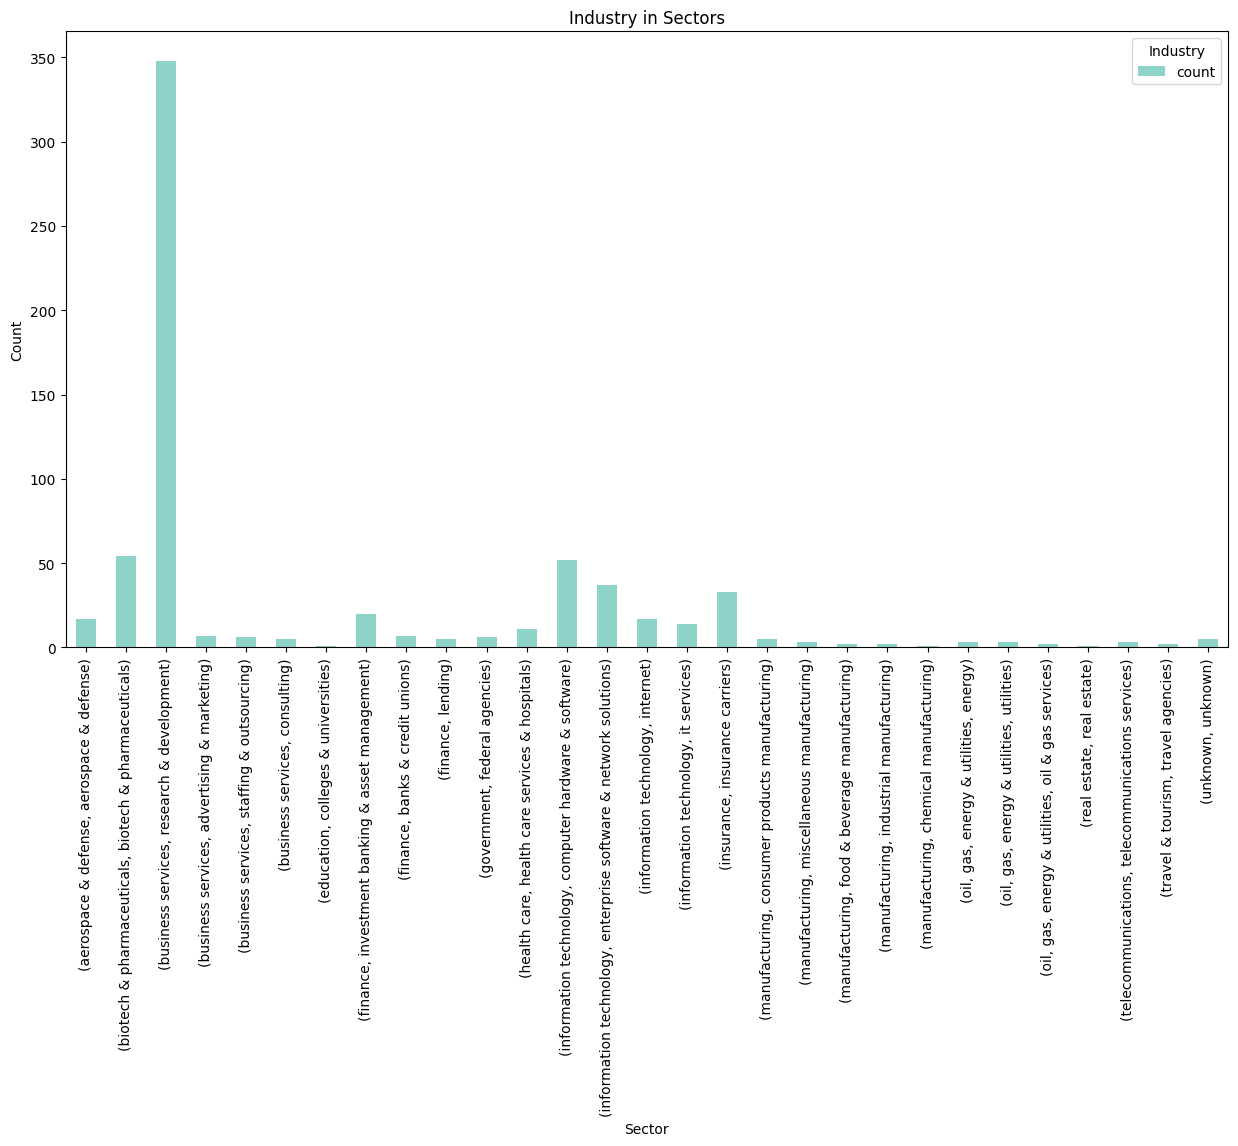

In [56]:
plt.figure(figsize=(15, 8))
res.plot(kind='bar', colormap='Set3')

plt.xlabel("Sector")
plt.ylabel("Count")
plt.title("Industry in Sectors")
plt.legend(title="Industry")
plt.xticks(rotation=90)
plt.show()


Top Industries for Data Science: List the top 5 industries with the most job postings for data science roles and their average salaries and ratings.


In [57]:
# 
res = df[df['Job Title'].str.contains('data scientist')]


top_industry = res.groupby('Industry').agg(total_jobs=('Job Title', 'count')).reset_index()

top_industry=top_industry.sort_values(by='total_jobs', ascending=False).head(5)
print(top_industry)


                        Industry  total_jobs
15        research & development         337
4   computer hardware & software          31
3      biotech & pharmaceuticals          22
11                      internet           9
1            aerospace & defense           8


Revenue by Sector and Industry: Calculate the average revenue for each sector and industry to identify the most profitable areas.


In [58]:
# 
def convert_revenue(value):
    if isinstance(value, str):
        value = value.lower().strip()
        if "million" in value:
            return float(value.replace("million", "").strip()) * 1000000
        elif "billion" in value:
            return float(value.replace("billion", "").strip()) * 1000000000
    return None 

df["Revenue_Min_Numeric"] = df["Minimum_Revenue"].apply(convert_revenue)
df["Revenue_Max_Numeric"] = df["Maximum_Revenue"].apply(convert_revenue)

df["Avg_Revenue"] = df[["Revenue_Min_Numeric", "Revenue_Max_Numeric"]].mean(axis=1)

df["Avg_Revenue"] .value_counts()
avg_revenue = df.groupby(['Sector', 'Industry'])["Avg_Revenue"].mean().reset_index()
print(avg_revenue)

                          Sector                                 Industry  \
0            aerospace & defense                      aerospace & defense   
1      biotech & pharmaceuticals                biotech & pharmaceuticals   
2              business services                  advertising & marketing   
3              business services                               consulting   
4              business services                   research & development   
5              business services                   staffing & outsourcing   
6                      education                  colleges & universities   
7                        finance                    banks & credit unions   
8                        finance    investment banking & asset management   
9                        finance                                  lending   
10                    government                         federal agencies   
11                   health care         health care services & hospitals   

Top Locations by Job Count: Identify the top 10 locations (cities and states) with the highest job counts and analyze their average salaries and ratings


Top 10 Locations with Highest Job Counts, Avg Salary, and Rating:
                                  Job_Count     Avg_Salary  Avg_Rating
New_Location                                                          
san francisco, california                69  119224.637681    3.852038
new york, new york                       50  136680.000000    3.863116
washington, district of columbia         26  139500.000000    3.942308
boston, massachusetts                    24  122583.333333    4.192442
chicago, illinois                        22  121318.181818    3.668182
herndon, virginia                        21  134642.857143    3.933333
cambridge, massachusetts                 18  120666.666667    3.902067
mclean, virginia                         12  126291.666667    4.008333
chantilly, virginia                      11  124181.818182    3.767018
united states                            11  120227.272727    3.619873


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\4186660226.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result.index, y=result['Job_Count'], palette='viridis')


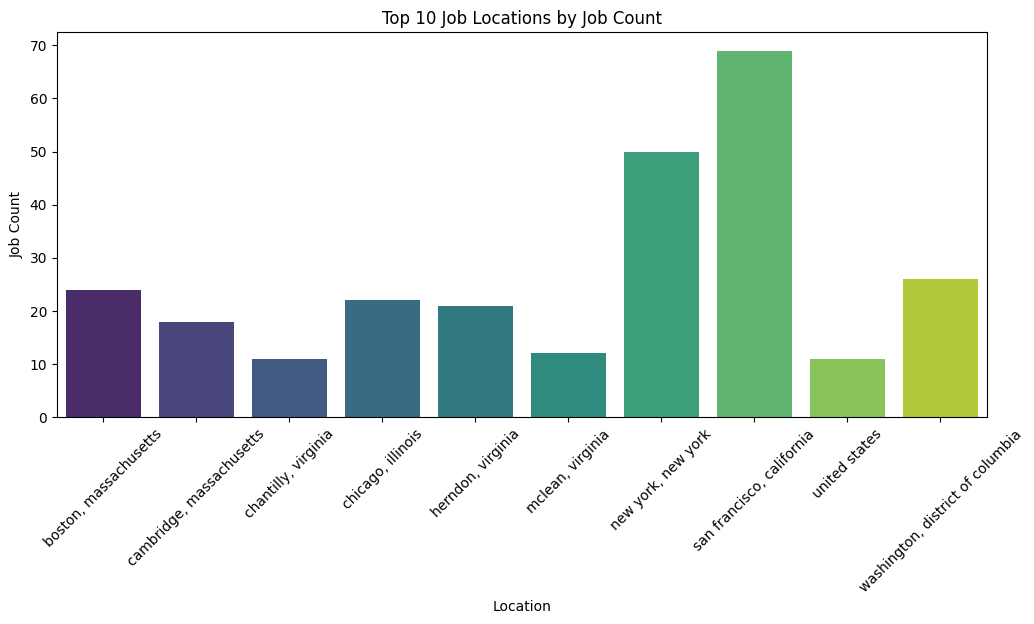

C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\4186660226.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result.index, y=result['Avg_Salary'], palette='coolwarm')


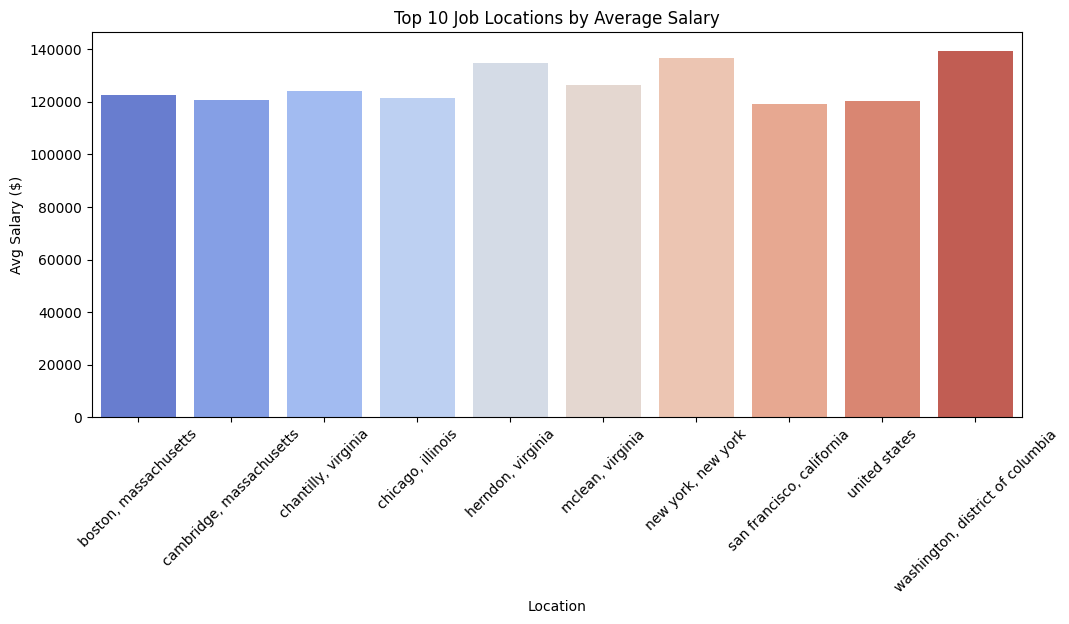

C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\4186660226.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result.index, y=result['Avg_Rating'], palette='Blues')


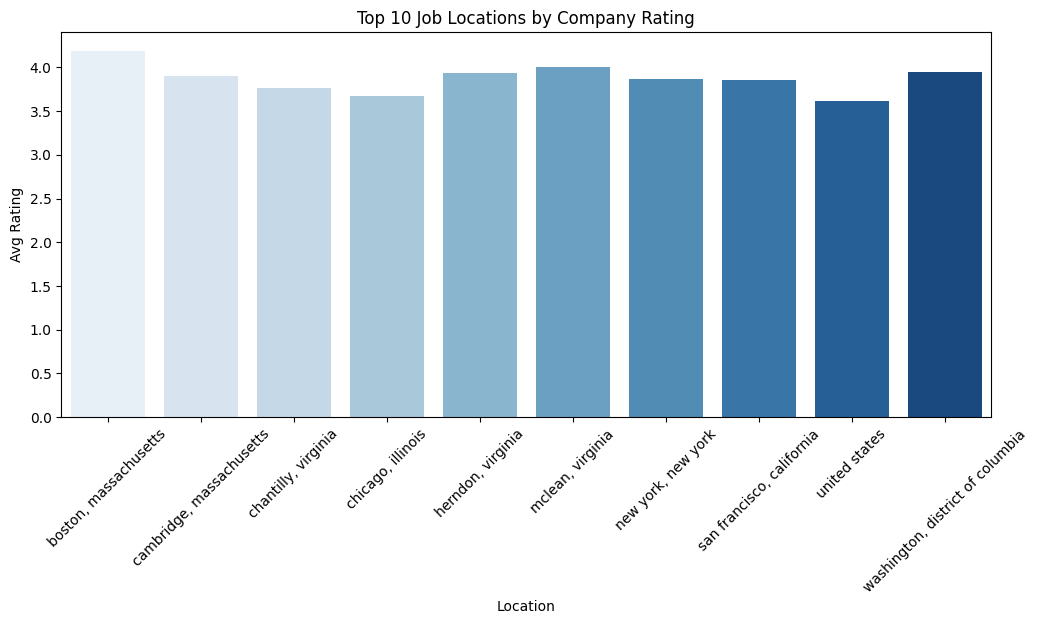

In [59]:
# 
job_count = df.groupby('New_Location')['Job Title'].count()

top_locations = job_count.sort_values(ascending=False).head(10).index  

avg_salary = df[df['New_Location'].isin(top_locations)].groupby('New_Location')['Avg_Salary'].mean()
avg_rating = df[df['New_Location'].isin(top_locations)].groupby('New_Location')['Rating'].mean()


result = pd.DataFrame({'Job_Count': job_count[top_locations],'Avg_Salary': avg_salary,'Avg_Rating': avg_rating})

print("Top 10 Locations with Highest Job Counts, Avg Salary, and Rating:")
print(result.sort_values(by='Job_Count',ascending=False))

plt.figure(figsize=(12, 5))
sns.barplot(x=result.index, y=result['Job_Count'], palette='viridis')
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Job Count")
plt.title("Top 10 Job Locations by Job Count")
plt.show()
plt.figure(figsize=(12, 5))
sns.barplot(x=result.index, y=result['Avg_Salary'], palette='coolwarm')
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Avg Salary ($)")
plt.title("Top 10 Job Locations by Average Salary")
plt.show()
plt.figure(figsize=(12, 5))
sns.barplot(x=result.index, y=result['Avg_Rating'], palette='Blues')
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Avg Rating")
plt.title("Top 10 Job Locations by Company Rating")
plt.show()


Headquarters vs. Job Location: Compare ratings for jobs at a company’s headquarters vs. remote offices.


Allows_Remote
no     3.856444
yes    3.838981
Name: Rating, dtype: float32


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\3883835256.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Allows_Remote'], y=df['Rating'], palette="coolwarm")


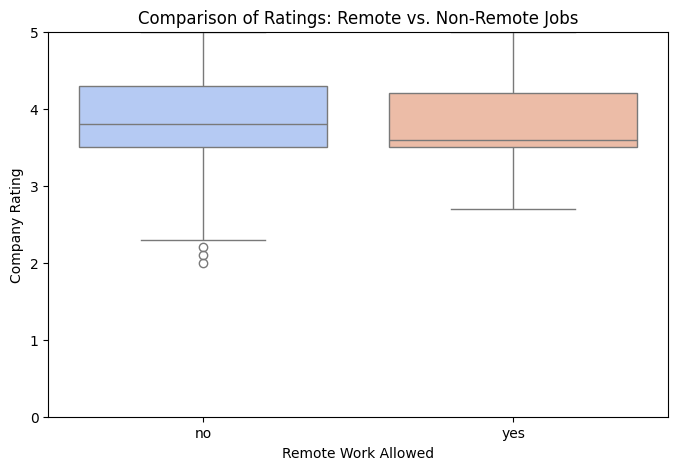

In [60]:

remote_rating = df.groupby('Allows_Remote')['Rating'].mean()
print(remote_rating)  

plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Allows_Remote'], y=df['Rating'], palette="coolwarm")
plt.xlabel("Remote Work Allowed")
plt.ylabel("Company Rating")
plt.title("Comparison of Ratings: Remote vs. Non-Remote Jobs")
plt.ylim(0, 5)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\2214266121.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=remote_rating.index, y=remote_rating.values, palette="coolwarm")


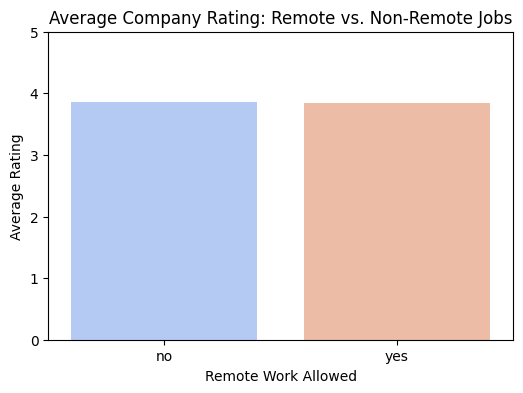

In [61]:
remote_rating = df.groupby('Allows_Remote')['Rating'].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=remote_rating.index, y=remote_rating.values, palette="coolwarm")

plt.xlabel("Remote Work Allowed")
plt.ylabel("Average Rating")
plt.title("Average Company Rating: Remote vs. Non-Remote Jobs")
plt.ylim(0, 5)
plt.show()

Company Size and Location Correlation: Explore whether certain locations are more likely to host larger or smaller companies.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\4076138610.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['Size_category'] ,y=df['New_Location'], palette="coolwarm")


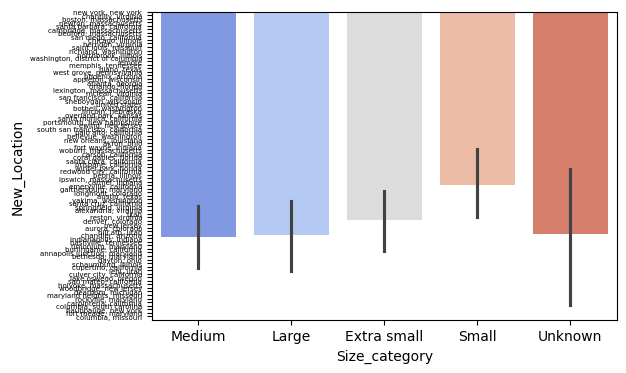

In [62]:
remote_rating = df.groupby('New_Location')['Size_category']

plt.figure(figsize=(6, 4))
sns.barplot(x=df['Size_category'] ,y=df['New_Location'], palette="coolwarm")
plt.yticks(rotation=0)
plt.yticks(fontsize=5)  
plt.show()



Job Title Levels: Calculate the average rating and salary for each level (e.g., ”Junior,” ”Mid-level,” ”Senior”).


In [63]:
#
level = df.groupby('Experience Level')[['Rating','Avg_Salary']].mean()
print(level)

                    Rating     Avg_Salary
Experience Level                         
1 year            3.864482  113500.000000
2 year            3.693116  131870.000000
3+ year           3.779408  123791.666667
Entry level       3.633333  122333.333333
Not Specified     3.876947  123319.672131


Experience Level and Location: Analyze if certain experience levels (e.g., entry-level, senior) are more commonly available in specific locations or industries


<Figure size 1000x500 with 0 Axes>

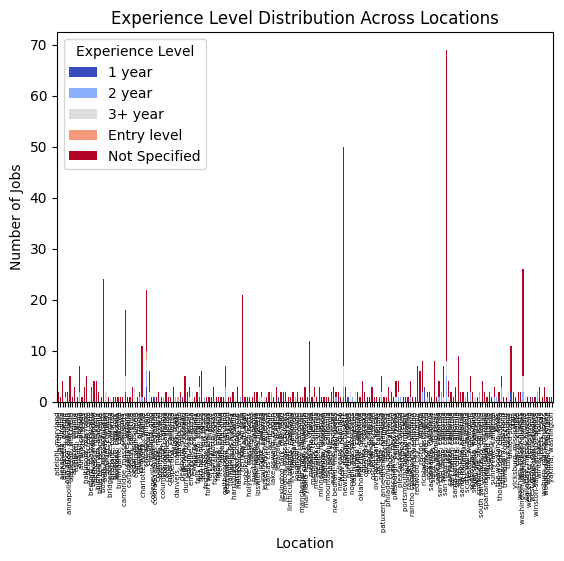

New_Location      adelphi, maryland  akron, ohio  alexandria, virginia  \
Experience Level                                                         
1 year                            0            0                     0   
2 year                            0            0                     0   
3+ year                           0            0                     0   
Entry level                       0            0                     0   
Not Specified                     2            1                     4   

New_Location      alpharetta, georgia  ann arbor, michigan  \
Experience Level                                             
1 year                              0                    0   
2 year                              0                    0   
3+ year                             1                    0   
Entry level                         0                    0   
Not Specified                       1                    2   

New_Location      annapolis junction, maryland  appleton, wisconsin  \
Experience Level                                                      
1 year                                       0                    0   
2 year                                       0                    0   
3+ year                                      0                    0   
Entry level                                  0                    0   
Not Specified                                5                    1   

New_Location      arlington, virginia  ashburn, virginia  atlanta, georgia  \
Experience Level                                                             
1 year                              0                  0                 0   
2 year                              0                  0                 2   
3+ year                             0                  0                 0   
Entry level                         0                  0                 0   
Not Specified                       3                  1                 5   

New_Location      ...  west chester, pennsylvania  west grove, pennsylvania  \
Experience Level  ...                                                         
1 year            ...                           0                         1   
2 year            ...                           0                         0   
3+ year           ...                           0                         0   
Entry level       ...                           0                         0   
Not Specified     ...                           1                         0   

New_Location      wilmington, delaware  winston-salem, north carolina  \
Experience Level                                                        
1 year                               0                              0   
2 year                               0                              2   
3+ year                              0                              0   
Entry level                          0                              0   
Not Specified                        1                              0   

New_Location      winter park, florida  winters, texas  woburn, massachusetts  \
Experience Level                                                                
1 year                               0               0                      0   
2 year                               0               0                      0   
3+ year                              0               0                      0   
Entry level                          0               0                      0   
Not Specified                        3               1                      3   

New_Location      woodbridge, new jersey  woodlawn, maryland  \
Experience Level                                               
1 year                                 0                   0   
2 year                                 0                   0   
3+ year                                0                   0   
Entry level                            0       

In [159]:
res1 = df.groupby(['Experience Level'])['New_Location'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(10, 5))
res1.T.plot(kind='bar', stacked=True, colormap='coolwarm')

plt.title("Experience Level Distribution Across Locations")
plt.ylabel("Number of Jobs")
plt.xlabel("Location")
plt.xticks(rotation=90,fontsize=5)
plt.legend(title="Experience Level")
plt.show()

res1

Experience Level by Sector: Analyze the distribution of experience levels by sector and identify if certain sectors focus more on senior or junior roles.


In [65]:
#

df['Employee_count']=df['size_split'].apply(lambda x: round((int(x[0])+int(x[2]))/2) if 'to' in x else ( 1 if 'Unknown' in x  else 10000))
df['Employee_count']=df['Employee_count'].astype(int)
experience_distribution = df.pivot_table(values='Employee_count', index='Sector', columns='Experience Level', aggfunc='sum', fill_value=0)

print("Raw Count Distribution:")
print(experience_distribution)



Raw Count Distribution:
Experience Level              1 year  2 year  3+ year  Entry level  \
Sector                                                               
aerospace & defense                0       0        0            0   
biotech & pharmaceuticals          0   52550     1050         3000   
business services              31308  106337    53988          252   
education                          0       0        0            0   
finance                          350       0     5250            0   
government                         0       0        0            0   
health care                     7500       0        0            0   
information technology             0     602    11228            0   
insurance                          0       0     7500            0   
manufacturing                      0   15000      350            0   
oil, gas, energy & utilities    9000       0     6700            0   
real estate                        0       0        0            0

Founding Year vs. Salary: Analyze if older companies tend to offer higher or lower salaries compared to newer companies.


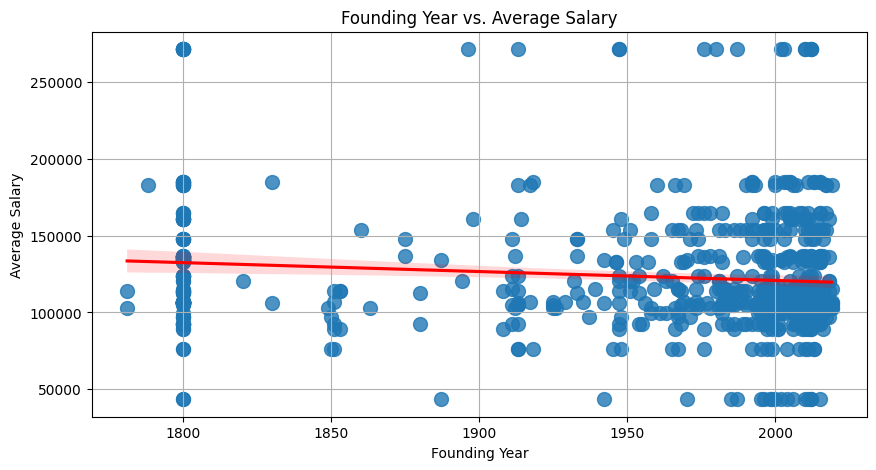

In [160]:
plt.figure(figsize=(10, 5))
sns.regplot(x=df['Founded'], y=df['Avg_Salary'], scatter_kws={'s': 100}, line_kws={'color': 'red'})

plt.xlabel("Founding Year")
plt.ylabel("Average Salary")
plt.title("Founding Year vs. Average Salary")
plt.grid(True)
plt.show()


Remote Work and Rating: Compare the ratings of jobs marked as remote vs. non-remote to see if remote positions correlate with higher ratings.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\2462076195.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Allows_Remote'], y=df['Rating'], palette="coolwarm")


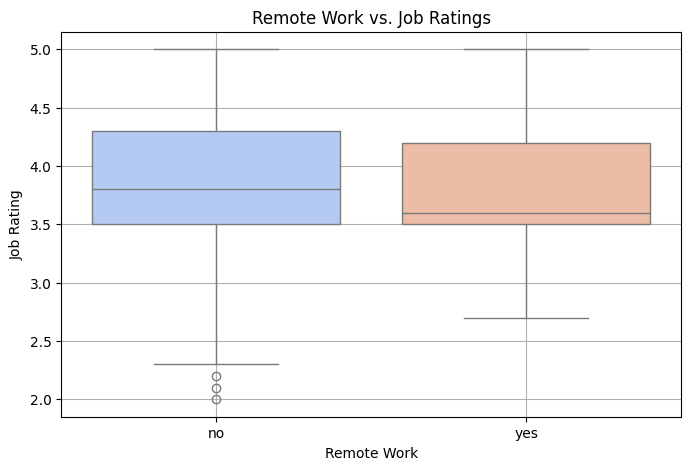

Average Ratings:
  Allows_Remote    Rating
0            no  3.856444
1           yes  3.838981


In [67]:
# 
avg_rating = df.groupby('Allows_Remote')['Rating'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Allows_Remote'], y=df['Rating'], palette="coolwarm")

plt.xlabel("Remote Work")
plt.ylabel("Job Rating")
plt.title("Remote Work vs. Job Ratings")
plt.grid(True)
plt.show()
print("Average Ratings:")
print(avg_rating)

Competitors and Salary: Check if companies with multiple listed competitors tend to offer higher salaries on average.


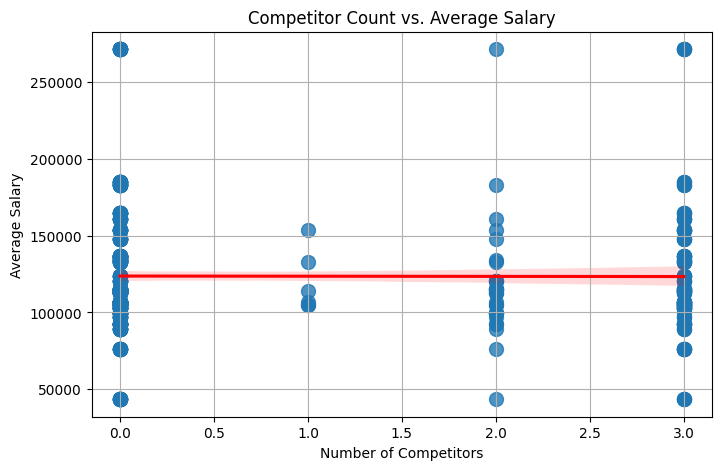

Correlation between Competitor Count and Average Salary:
                   Competitors_Count  Avg_Salary
Competitors_Count           1.000000   -0.003316
Avg_Salary                 -0.003316    1.000000


In [70]:
df['Competitors_Count']=df['Competitors'].apply( lambda x: x.count(',')+1 if ',' in x else (0 if str(x) == "-1"  else 1))
# Scatter plot: Competitor Count vs. Average Salary
plt.figure(figsize=(8, 5))
sns.regplot(x=df['Competitors_Count'], y=df['Avg_Salary'], scatter_kws={'s': 100}, line_kws={'color': 'red'})

plt.xlabel("Number of Competitors")
plt.ylabel("Average Salary")
plt.title("Competitor Count vs. Average Salary")
plt.grid(True)
plt.show()

correlation = df[['Competitors_Count', 'Avg_Salary']].corr()
print("Correlation between Competitor Count and Average Salary:")
print(correlation)

# Data Transformation


Add Skill Flags: Create binary columns to flag if certain skill(e.g., ”Python,” ”SQL,” ”machine learning”) are mentioned in the ”Job Description.”


In [71]:
skills = ['python', 'sql', 'machine learning','maths']

for skill in skills:
    df[f'{skill}_skill'] = df['Job Description'].apply(lambda x: 1 if re.search(rf'\b{skill}\b', x.lower()) else 0)
df[[f'{b}_skill' for b in skills]].sum().sort_values(ascending=False)


python_skill              489
machine learning_skill    418
sql_skill                 325
maths_skill                 0
dtype: int64

Identify Benefits: Add columns for common benefits (e.g., ”healthcare,” ”retirement plan”) based on keywords found in the ”Job Description



In [72]:

benefits = ['healthcare','retirement','stock','bonus']

for benefit in benefits:
    df[f'{benefit}_benefit'] = df['Job Description'].apply(lambda x: 1 if re.search(rf'\b{benefit}\b', x.lower()) else 0)
df[[f'{b}_benefit' for b in benefits]].sum().sort_values(ascending=False)


healthcare_benefit    84
bonus_benefit         58
retirement_benefit    33
stock_benefit         30
dtype: int64

Convert Founded Year to Age: Calculate each company’s age by subtracting the founding year from the current yea


In [73]:
year_current = datetime.now().year



df['age_of_company']=df['Founded'].apply(lambda x:x  if x==-1 else year_current-x)
df['age_of_company'].unique()

array([ 32,  57,  44,  25,  27,  15,  29,  35,  42,  11,  13,   9,  60,
        52,  39,  28,  10,  80,  37,   8,  14,  58, 165,  33,  22,  74,
        20,   6, 100,  17,  26,  47,  59, 113,  67,  12, 176, 244,  99,
        19,  31, 162,  30, 225,  43,  51,  24,  40, 112,  54, 114,  16,
        66,  18,  86,  23,  64,  62,  56,  79,  68,  72,  77, 175, 174,
        21,  49, 107,  71,  78,  70,   7,  88, 108,  90,  96, 205,  73,
        93, 131,  65, 237, 195,  41,  92, 145, 138,  55,  83,  45,  36,
       117, 172, 150, 111, 127,  69,  48,  38, 129,  53,  76,  63])

Establish Company Age Categories: Categorize companies into age groups (e.g., ”New” for <10 years, ”Established” for 10-50 years, ”Legacy” for >50 years).


In [74]:
df['Company_Age_Category']=df['age_of_company'].apply(lambda x:   'New' if x<10 else( 'Established'  if x>10 and x<50   else ( 'Legacy')))

In [75]:
df['Company_Age_Category'].value_counts()

Company_Age_Category
Established    361
Legacy         280
New             31
Name: count, dtype: int64

In [76]:
# Sector and Industry Mapping: Create a mapping dictionary to reclassify ”Industry” values into broader ”Sector” categories if needed.
# alreay mapped

In [77]:
# Company Size Bucketing: Create buckets for company size (e.g., ”Small” for <500 employees, ”Medium” for 500-5000, ”Large” for >5000) and add a new column.
# already sized

Location Grouping: Group locations into regions (e.g., Northeast, Midwest) for U.S. data or other relevant geographical groupings.


In [78]:
us_regions = {
    'northeast': ['connecticut', 'maine', 'massachusetts', 'new hampshire', 'rhode island', 'vermont', 'new jersey', 'new york', 'pennsylvania'],
    'midwest': ['illinois', 'indiana', 'michigan', 'ohio', 'wisconsin', 'iowa', 'kansas', 'minnesota', 'missouri', 'nebraska', 'north dakota', 'south dakota'],
    'south': ['delaware', 'florida', 'georgia', 'maryland', 'north carolina', 'south carolina', 'virginia', 'district of columbia', 'west virginia', 'alabama', 'kentucky', 'mississippi', 'tennessee', 'arkansas', 'louisiana', 'oklahoma', 'texas'],
    'west': ['alaska', 'arizona', 'california', 'colorado', 'hawaii', 'idaho', 'montana', 'nevada', 'new mexico', 'oregon', 'utah', 'washington', 'wyoming']
}

state_to_region = {state: region for region, states in us_regions.items() for state in states}
global_regions = {
    'europe': ['united kingdom', 'germany', 'france', 'italy', 'spain', 'netherlands', 'sweden', 'switzerland'],
    'asia': ['india', 'china', 'japan', 'south korea', 'singapore'],
    'north america': ['canada', 'mexico'],
    'oceania': ['australia', 'new zealand']
}
df['Region'] = df['New_Location'].str.split(',').str[-1].str.strip()
df['Region'] = df['Region'].map(state_to_region).fillna(df['Region'])
df.loc[df['New_Location'].str.contains('Remote', case=False, na=False), 'Region'] = 'Remote'

df['Region'].value_counts()


Region
south            223
west             203
northeast        146
midwest           83
united states     11
Remote             6
Name: count, dtype: int64

Calculate Revenue per Employee: Create a column for revenue per employee by dividing the revenue by the employee size estimate.


In [79]:
df['Size'].value_counts()
size_midpoints = {
    "1 to 50": 25,
    "51 to 200": 125,
    "201 to 500": 350,
    "501 to 1000": 750,
    "1001 to 5000": 3000,
    "5001 to 10000": 7500,
    "10000+": 12000,
    "Unknown": None 
}

df['Avg_Size'] = df['Size'].map(size_midpoints)


In [80]:
df['Revenue_per_employee']=df["Avg_Revenue"]/df['Avg_Size']
df['Revenue_per_employee'].value_counts()

Revenue_per_employee
8.000000e+08    56
4.583333e+06    53
1.000000e+05    43
4.000000e+09    41
1.333333e+08    37
1.400000e+05    30
3.000000e+05    28
2.857143e+08    27
4.666667e+05    26
4.000000e+05    26
8.571429e+05    25
1.200000e+05    25
3.333333e+07    22
2.142857e+05    16
5.000000e+05    15
4.000000e+04    15
2.000000e+05    13
1.166667e+06    12
2.500000e+05    12
6.000000e+04    10
8.333333e+06    10
5.000000e+04     9
7.333333e+06     9
1.250000e+05     6
1.000000e+06     6
2.400000e+06     6
2.916667e+05     6
7.000000e+05     5
1.071429e+05     5
2.500000e+04     5
6.250000e+05     4
1.333333e+07     4
2.400000e+04     3
8.571429e+03     3
6.000000e+05     3
4.285714e+06     2
1.833333e+07     1
5.833333e+03     1
4.666667e+06     1
6.250000e+02     1
2.142857e+04     1
1.250000e+04     1
2.500000e+06     1
2.142857e+06     1
8.000000e+03     1
3.000000e+06     1
Name: count, dtype: int64

Create Salary Range Buckets: Classify salary ranges into brackets (e.g., ”<$50k,” ”$50k-$100k,” ”>$100k”) to enable clearer comparisons


In [81]:
df['Salary_Range_Buckets']=df['Avg_Salary'].map(lambda x:  '<$50k'  if x <50000    else  ( '$50k-$100k'  if x >=50000 and x<=100000 else( '>$100k' )) )
df['Salary_Range_Buckets'].value_counts()

Salary_Range_Buckets
>$100k        518
$50k-$100k    134
<$50k          20
Name: count, dtype: int64

Competitor Count: Add a column indicating the number of competitors each company lists.


In [82]:
df['Competitors'].unique()
df['Competitors_Count'].value_counts()

Competitors_Count
0    501
3    135
2     30
1      6
Name: count, dtype: int64

Frequent Competitors: Add a flag for companies that list commonly seen competitors and analyze if these companies have different rating or salary trends


In [83]:
#all_competitors = df['Competitors'].dropna().str.split(', ').explode()
competitor_counts = Counter(all_competitors)
frequent_competitors = {comp for comp, count in competitor_counts.items() if count >= 5}
print(frequent_competitors)

{'saic', 'battelle', 'booz allen hamilton', 'accenture', 'roche', 'caci international', '-1', 'pfizer', 'deloitte', 'northrop grumman', 'glaxosmithkline', 'los alamos national laboratory', 'sri international', 'leidos', 'novartis'}


In [84]:
# Flag companies that list at least one frequent competitor
df['Frequent_Competitor_Flag'] = df['Competitors'].apply(lambda x: 
    1 if isinstance(x, str) and any(comp in x for comp in frequent_competitors) else 0
)

df['Frequent_Competitor_Flag'].value_counts()

Frequent_Competitor_Flag
1    560
0    112
Name: count, dtype: int64

Average Rating Comparison:
 Frequent_Competitor_Flag
0    3.738393
1    3.878089
Name: Rating, dtype: float32


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1539558503.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_comparison.index, y=rating_comparison.values, palette="coolwarm")


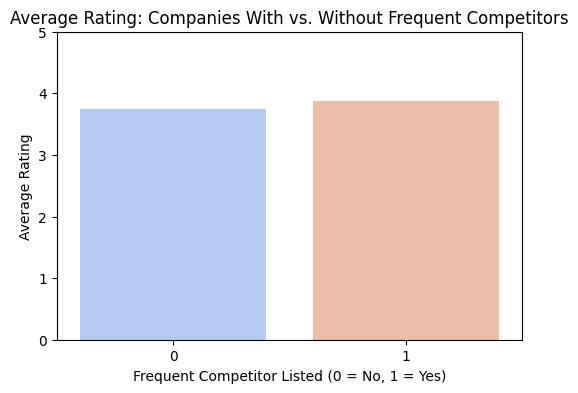

Average Salary Comparison:
 Frequent_Competitor_Flag
0    121406.250000
1    124115.178571
Name: Avg_Salary, dtype: float64


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1539558503.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=salary_comparison.index, y=salary_comparison.values, palette="coolwarm")


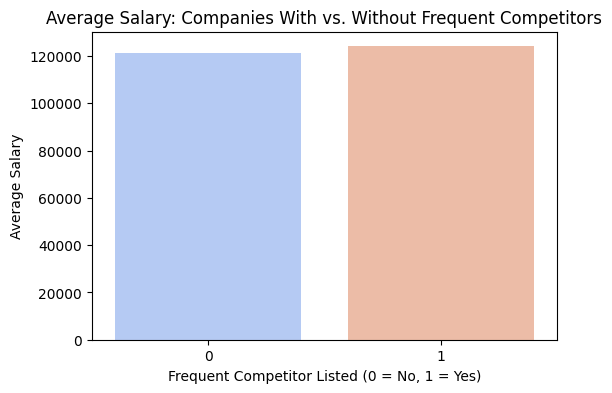

In [85]:
# Average Rating Comparison
rating_comparison = df.groupby('Frequent_Competitor_Flag')['Rating'].mean()
print("Average Rating Comparison:\n", rating_comparison)
plt.figure(figsize=(6,4))
sns.barplot(x=rating_comparison.index, y=rating_comparison.values, palette="coolwarm")
plt.xlabel("Frequent Competitor Listed (0 = No, 1 = Yes)")
plt.ylabel("Average Rating")
plt.title("Average Rating: Companies With vs. Without Frequent Competitors")
plt.ylim(0, 5)
plt.show()

salary_comparison = df.groupby('Frequent_Competitor_Flag')['Avg_Salary'].mean()
print("Average Salary Comparison:\n", salary_comparison)
plt.figure(figsize=(6,4))
sns.barplot(x=salary_comparison.index, y=salary_comparison.values, palette="coolwarm")
plt.xlabel("Frequent Competitor Listed (0 = No, 1 = Yes)")
plt.ylabel("Average Salary")
plt.title("Average Salary: Companies With vs. Without Frequent Competitors")
plt.show()

Common Competitor Networks: Create clusters for companies with the same competitors, allowing analysis of companies within specific competitive networks.


    Cleaned_Company Name                                        Competitors  \
0            healthfirst  [['emblemhealth', 'unitedhealth group', 'aetna']]   
1                mantech                                               [[]]   
2               analysis                                               [[]]   
3                inficon  [['mks instruments', 'pfeiffer vacuum', 'agile...   
4               affinity     [['commerce signals', 'cardlytics', 'yodlee']]   
..                   ...                                                ...   
667             tranzact                                               [[]]   
668                 jkgt                                               [[]]   
669           accesshope                                               [[]]   
670              chateck                                               [[]]   
671        1-800-flowers                                               [[]]   

     Cluster  
0          2  
1          0  
2     

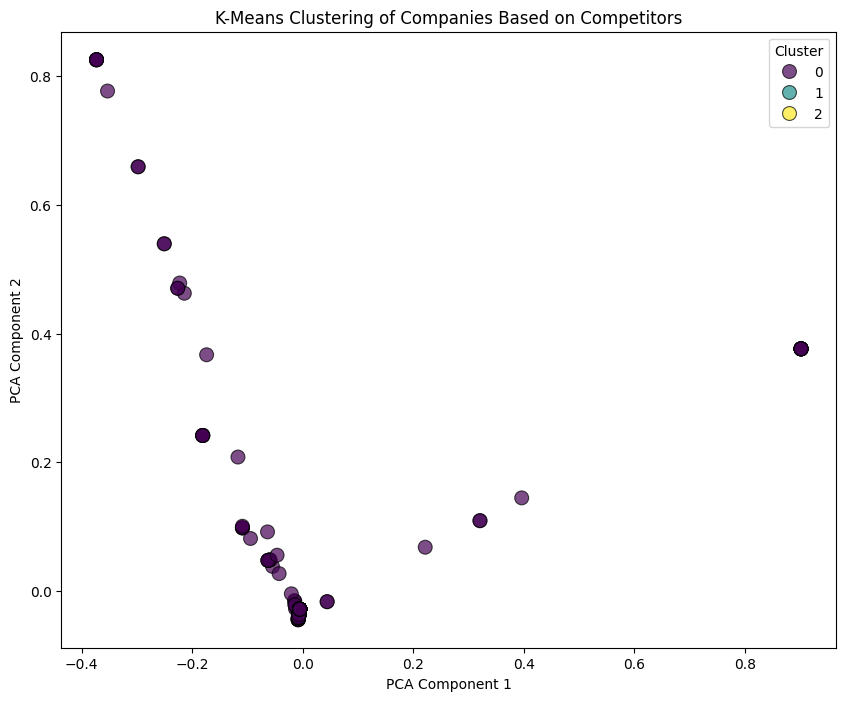

    Cleaned_Company Name                                        Competitors  \
0            healthfirst  [['emblemhealth', 'unitedhealth group', 'aetna']]   
1                mantech                                               [[]]   
2               analysis                                               [[]]   
3                inficon  [['mks instruments', 'pfeiffer vacuum', 'agile...   
4               affinity     [['commerce signals', 'cardlytics', 'yodlee']]   
..                   ...                                                ...   
667             tranzact                                               [[]]   
668                 jkgt                                               [[]]   
669           accesshope                                               [[]]   
670              chateck                                               [[]]   
671        1-800-flowers                                               [[]]   

     Cluster  
0          2  
1          0  
2     

In [294]:
#
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
# Convert competitor lists to strings for TF-IDF processing
df["Competitor_String"] = df["Competitors"].apply(lambda x: " ".join(x) if x else "")

# Convert competitors into numerical feature vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Competitor_String"])

# Apply K-Means clustering
num_clusters = 3  # Adjust based on needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

# Display results
print(df[["Cleaned_Company Name", "Competitors", "Cluster"]])


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

df["Competitor_String"] = df["Competitors"].apply(lambda x: " ".join(x) if x else "")

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Competitor_String"])

num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)


pca = PCA(n_components=2)
pca_components = pca.fit_transform(X.toarray())

# Add PCA components to the dataframe for plotting
df["PCA1"] = pca_components[:, 0]
df["PCA2"] = pca_components[:, 1]

# Plot the clusters with a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", s=100, alpha=0.7, edgecolor="black")
plt.title("K-Means Clustering of Companies Based on Competitors")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Display the dataframe with clusters
print(df[["Cleaned_Company Name", "Competitors", "Cluster"]])


Comparative analysis


Rating Comparison: Compare the average rating across industries within each sector to see if certain industries outperform others within the same sector.

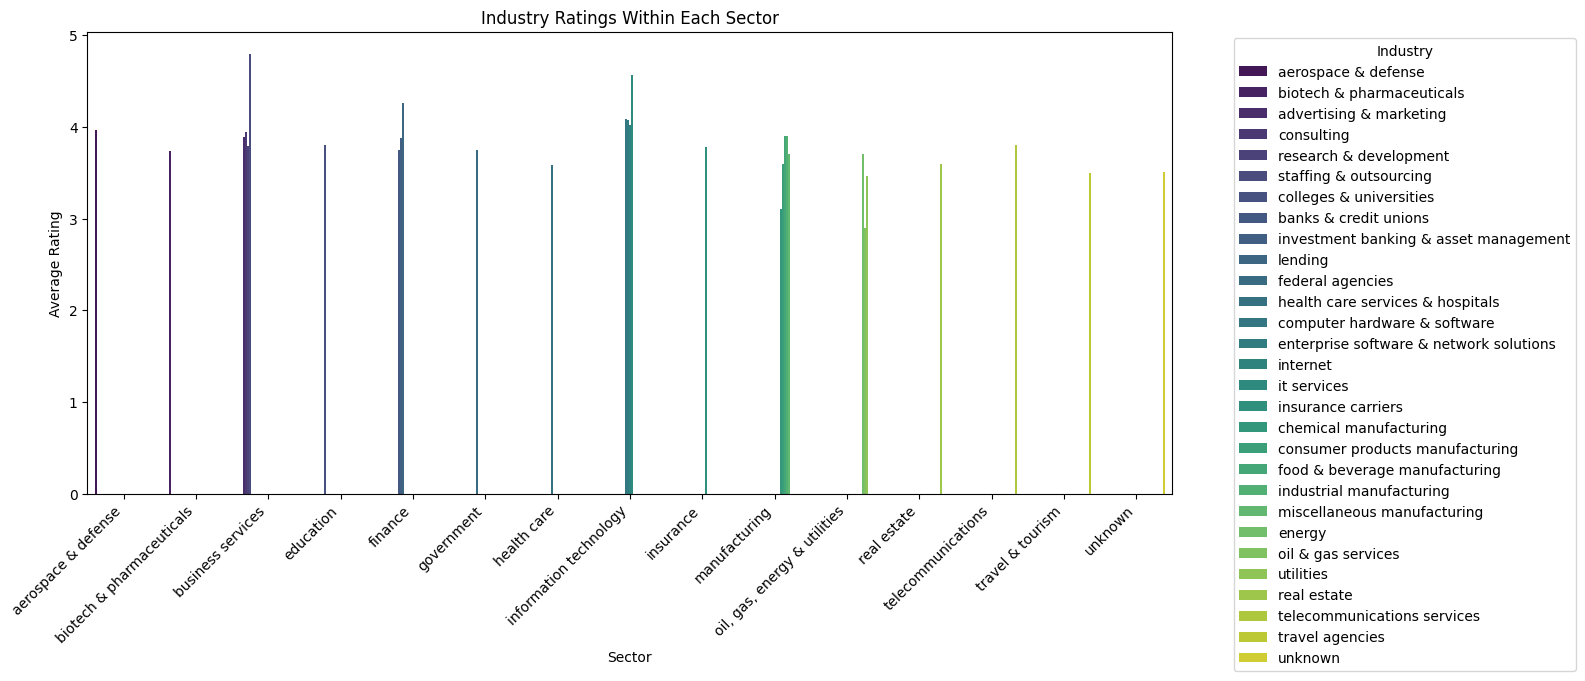

In [87]:
# 
industry_rating = df.groupby(['Sector', 'Industry'])['Rating'].mean().reset_index()
plt.figure(figsize=(14, 6))
sns.barplot(data=industry_rating, x='Sector', y='Rating', hue='Industry', dodge=True, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title('Industry Ratings Within Each Sector')
plt.ylabel('Average Rating')
plt.xlabel('Sector')
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Salary Range by Industry: Compare the median salary ranges for each industry within top sectors.

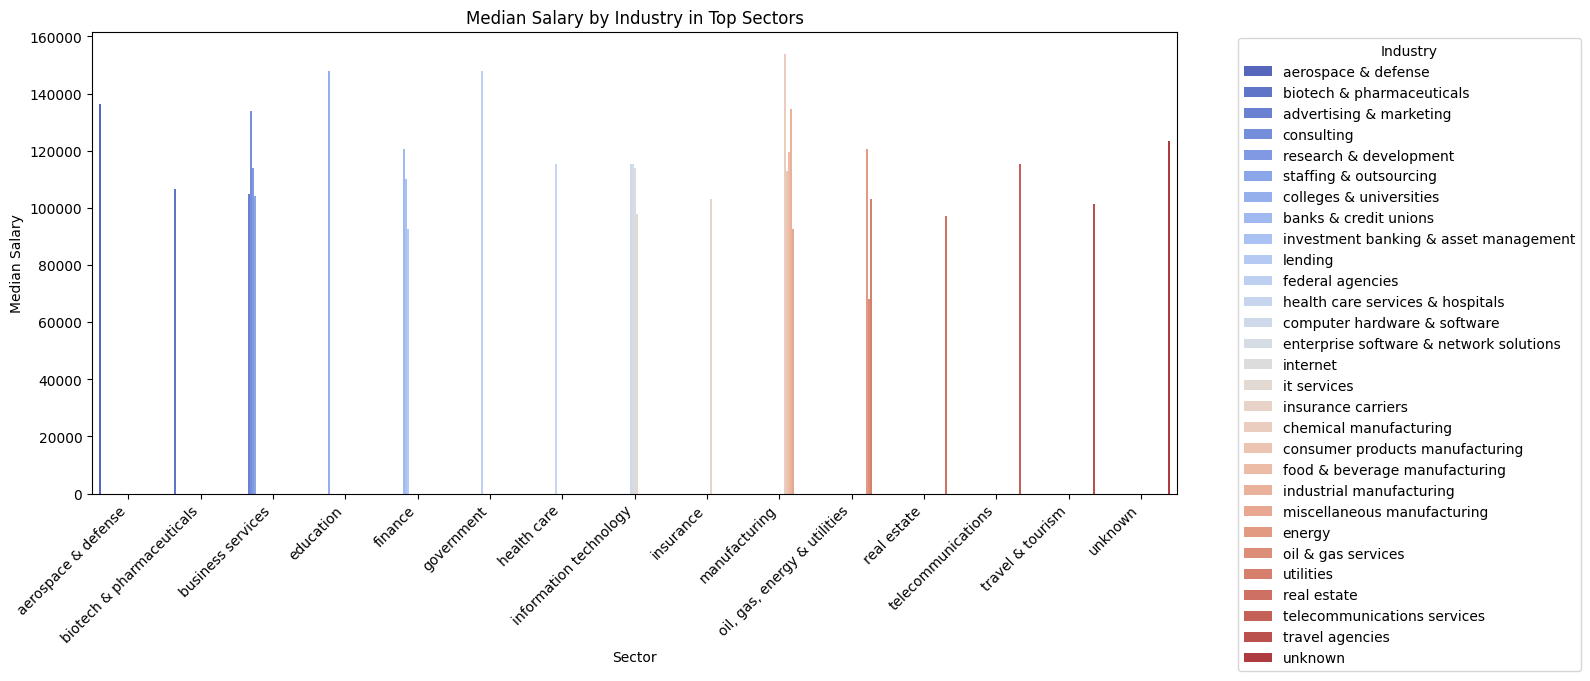

In [88]:

# Compute median salary for each industry within top sectors
industry_salary = df.groupby(['Sector', 'Industry'])['Avg_Salary'].median().reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(data=industry_salary, x='Sector', y='Avg_Salary', hue='Industry', palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.title('Median Salary by Industry in Top Sectors')
plt.ylabel('Median Salary')
plt.xlabel('Sector')
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Revenue vs. Sector: Analyze if certain sectors tend to have higher revenue brackets compared to others.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\991336502.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sector_revenue, x='Sector', y='Avg_Revenue', palette="viridis")


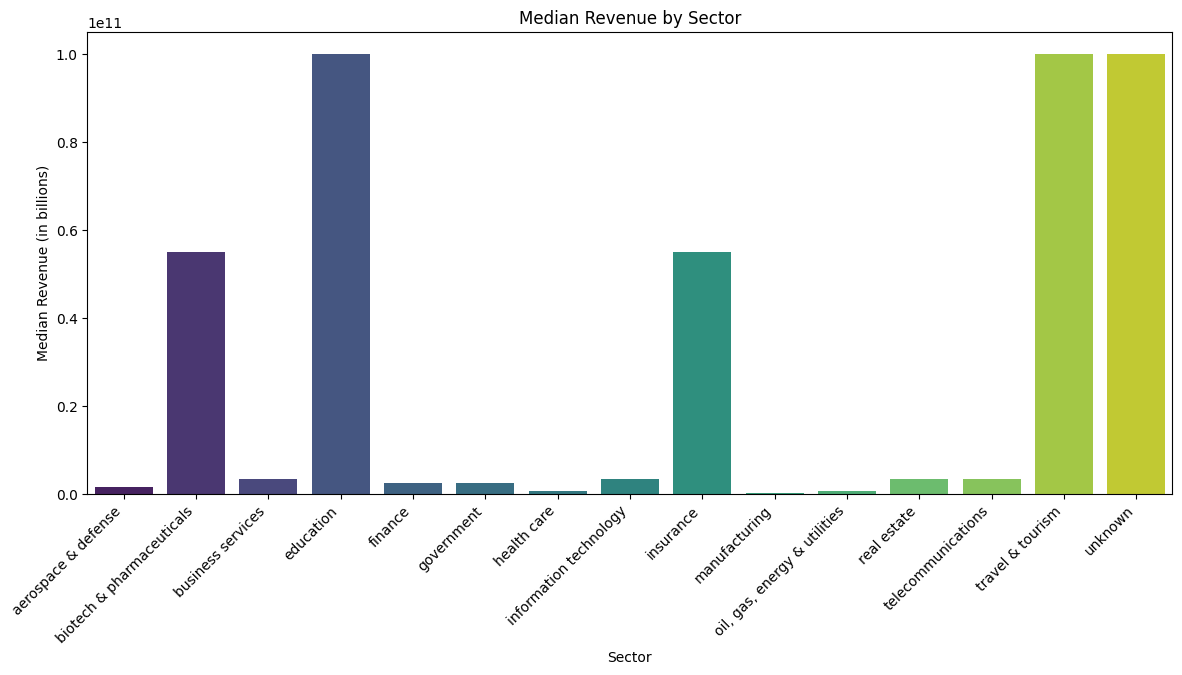

In [89]:
# 
sector_revenue = df.groupby('Sector')['Avg_Revenue'].median().reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(data=sector_revenue, x='Sector', y='Avg_Revenue', palette="viridis")

plt.xticks(rotation=45, ha="right")
plt.title('Median Revenue by Sector')
plt.ylabel('Median Revenue (in billions)')
plt.xlabel('Sector')
plt.show()


Public vs. Private Salary Comparison: Compare average salaries between public and private companies.


Type of ownership
company - private                 397
company - public                  153
nonprofit organization             36
subsidiary or business segment     28
-1                                 27
government                         10
other organization                  5
private practice / firm             4
unknown                             4
college / university                3
self-employed                       2
contract                            2
hospital                            1
Name: count, dtype: int64
  Company_Type     Avg_Salary
0        Other  123033.898305
1      Private  121746.882793
2       Public  129173.202614


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1854616084.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=company_salary, x='Company_Type', y='Avg_Salary', palette="viridis")


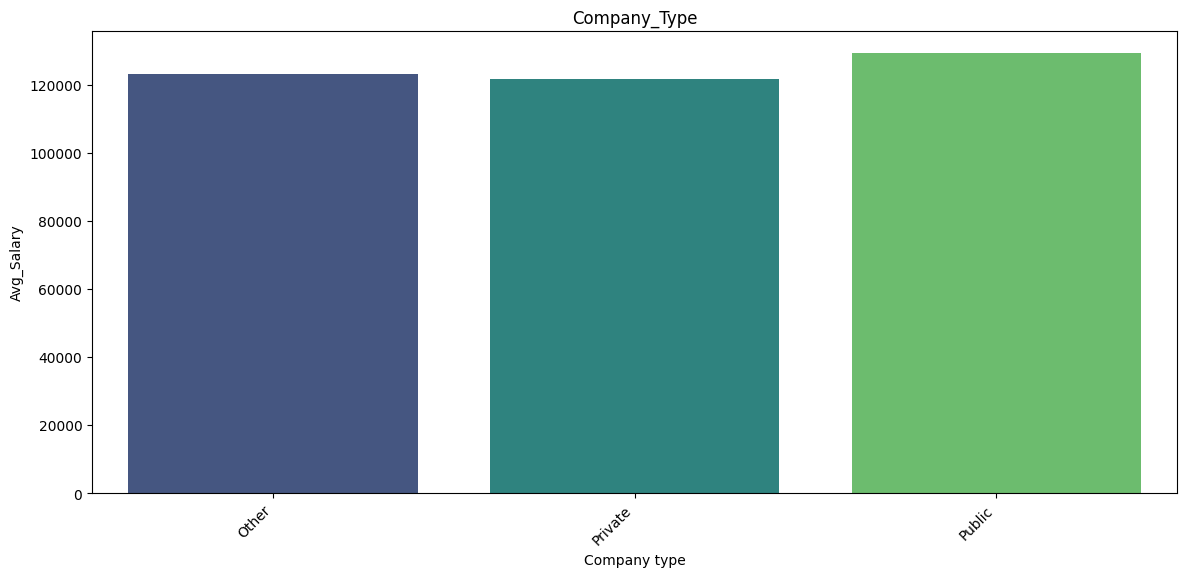

In [90]:
# 
print(df['Type of ownership'].value_counts())
df['Company_Type'] = df['Type of ownership'].apply(lambda x: 'Public' if 'public' in x else 'Private' if 'private' in x else 'Other')
df['Company_Type'].value_counts()


company_salary = df.groupby('Company_Type')['Avg_Salary'].mean().reset_index()
print(company_salary )

plt.figure(figsize=(14, 6))
sns.barplot(data=company_salary, x='Company_Type', y='Avg_Salary', palette="viridis")

plt.xticks(rotation=45, ha="right")
plt.title('Company_Type')
plt.ylabel('Avg_Salary')
plt.xlabel('Company type')
plt.show()




Rating Distribution by Ownership: Compare rating distributions across different ownership types to see if public or nonprofit organizations have higher ratings.



  Company_Type    Rating
0        Other  3.648797
1      Private  3.954950
2       Public  3.751224


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\2709216240.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=company_rating, x='Company_Type', y='Rating', palette="viridis")


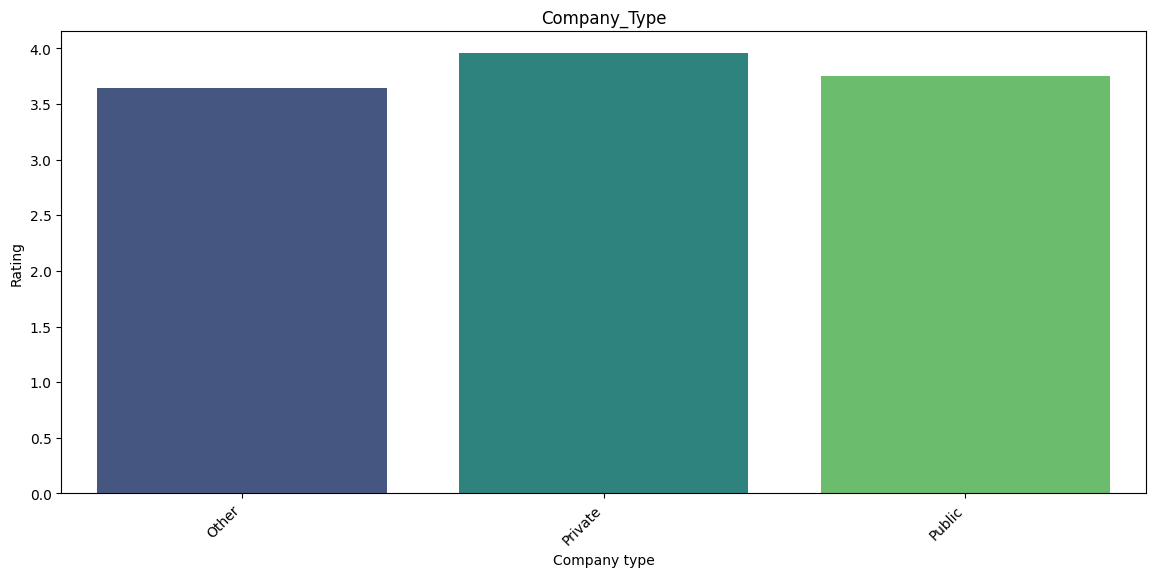

In [91]:
# 
company_rating = df.groupby('Company_Type')['Rating'].mean().reset_index()
print(company_rating)

plt.figure(figsize=(14, 6))
sns.barplot(data=company_rating, x='Company_Type', y='Rating', palette="viridis")

plt.xticks(rotation=45, ha="right")
plt.title('Company_Type')
plt.ylabel('Rating')
plt.xlabel('Company type')
plt.show()




Company Size by Ownership: Analyze if public or private companies tend to be larger or smaller in terms of employee size.


['Medium' 'Large' 'Extra small' 'Small' 'Unknown']


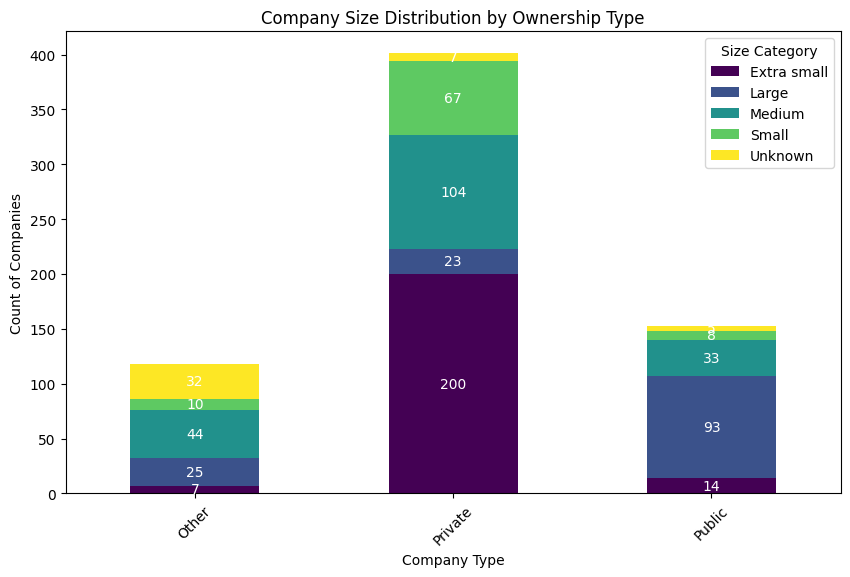

In [92]:

print(df['Size_category'].unique())

size_distribution = df.groupby(['Company_Type', 'Size_category']).size().unstack().fillna(0)

ax = size_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='center', fontsize=10, color='white')

plt.xlabel("Company Type")
plt.ylabel("Count of Companies")
plt.title("Company Size Distribution by Ownership Type")
plt.legend(title="Size Category")
plt.xticks(rotation=45)
plt.show()





Compare Ratings by Age Group: Analyze average ratings of companies in each age group to see if older companies have higher ratings


['Established' 'Legacy' 'New']


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\2075859213.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_rating, x="Company_Age_Category", y="Rating", palette="coolwarm")


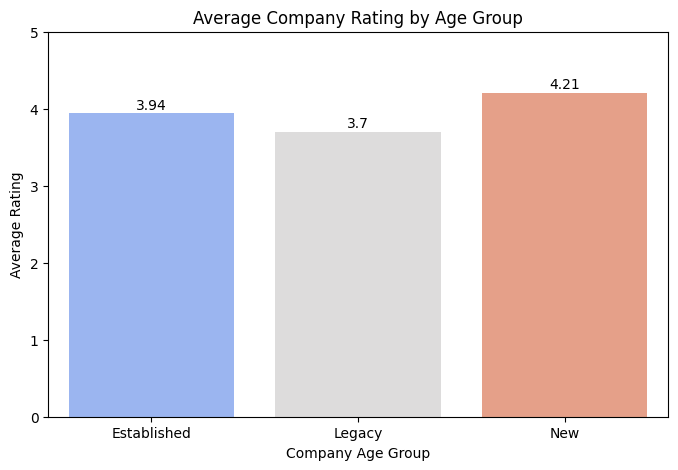

In [93]:

print(df['Company_Age_Category'].unique())
age_rating = df.groupby('Company_Age_Category')['Rating'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=age_rating, x="Company_Age_Category", y="Rating", palette="coolwarm")
plt.xlabel("Company Age Group")
plt.ylabel("Average Rating")
plt.title("Average Company Rating by Age Group")
plt.ylim(0, 5)
for index, row in age_rating.iterrows():
    plt.text(index, row["Rating"] + 0.05, round(row["Rating"], 2), ha='center', fontsize=10)

plt.show()


Rating Stability Over Time: Examine if companies founded before 2000 have more consistent (less variable) ratings than newer companies


           Founded_2000  Average_Rating  Rating_StdDev
0  Newer (2000 & Later)         4.02158       0.666993
1   Older (Before 2000)         3.74622       0.516174


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\3535908042.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Founded_2000', y='Rating', palette="coolwarm")


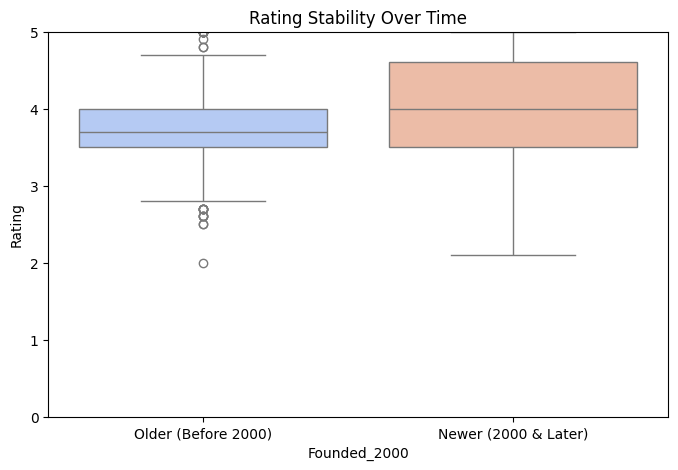

In [94]:
df['Founded_2000'] = df['Founded'].apply(lambda x: 'Older (Before 2000)' if x < 2000 else 'Newer (2000 & Later)' if x != -1 else 'Unknown')
rating_variability = df.groupby('Founded_2000')['Rating'].agg(['mean', 'std']).reset_index()
rating_variability.columns = ['Founded_2000', 'Average_Rating', 'Rating_StdDev']
print(rating_variability)
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Founded_2000', y='Rating', palette="coolwarm")
plt.xlabel('Founded_2000')
plt.ylabel("Rating")
plt.title("Rating Stability Over Time")
plt.ylim(0, 5)

plt.show()


Sector Popularity by Age: Compare the prevalence of different sectors within each age group, observing which sectors are popular among older vs. newer companies.


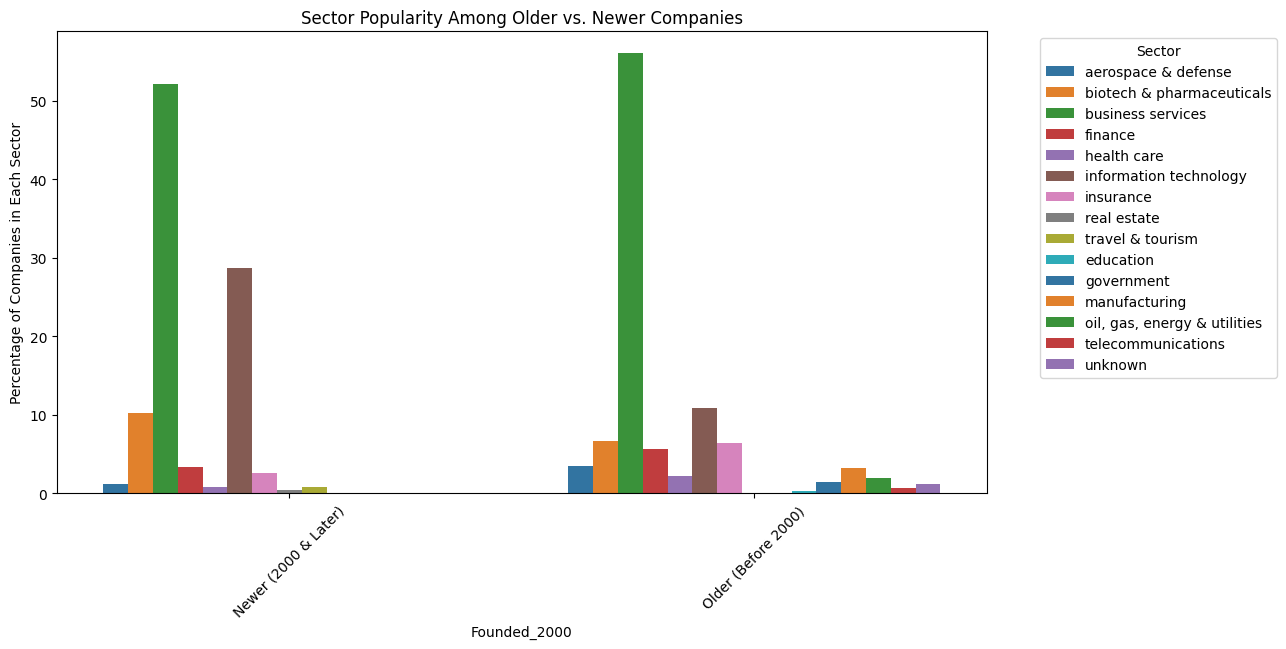

In [95]:
sector_counts = df.groupby(['Founded_2000', 'Sector']).size().reset_index(name='Count')


sector_counts['Percentage'] = sector_counts.groupby('Founded_2000')['Count'].transform(lambda x: (x / x.sum()) * 100)


plt.figure(figsize=(12, 6))
sns.barplot(data=sector_counts, x='Founded_2000', y='Percentage', hue='Sector', palette="tab10")

plt.xlabel('Founded_2000')
plt.ylabel("Percentage of Companies in Each Sector")
plt.title("Sector Popularity Among Older vs. Newer Companies")
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.show()


Salary by Region: Compare average salary ranges across regions to see if certain regions offer higher pay for data science jobs.


          Region     Avg_Salary
0        midwest  121011.904762
1      northeast  131333.333333
2          south  127690.265487
3  united states  121950.000000
4           west  122936.893204


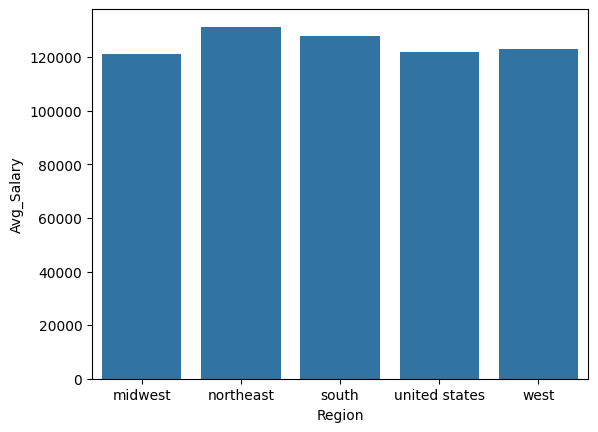

In [96]:
df1 = df[df['Job Title'].isin(['data scientist'])]

salary_by_region = df1.groupby('Region')['Avg_Salary'].mean().reset_index()

print(salary_by_region)


sns.barplot(salary_by_region,x='Region',y='Avg_Salary')
plt.show()

Remote vs. Onsite Roles: Compare salary ranges, job counts, and ratings for remote vs. onsite positions.


In [97]:
remote_stats = df.groupby('Allows_Remote').agg(Job_Count=('Job Title', 'count'),Avg_Salary=('Avg_Salary', 'mean'),Avg_Rating=('Rating', 'mean')).reset_index()
remote_stats['Allows_Remote'] = remote_stats['Allows_Remote'].map({'yes': 'Remote', 'no': 'Onsite'})
print(remote_stats)

  Allows_Remote  Job_Count     Avg_Salary  Avg_Rating
0        Onsite        609  122471.264368    3.856444
1        Remote         63  135190.476190    3.838981


Job Count by State: Compare the total job count and average salary for each state to identify states with the highest job availability. 


                   State  Job_Count     Avg_Salary
2             california        166  120521.084337
36              virginia         89  126769.662921
15         massachusetts         62  121967.741935
23              new york         52  136432.692308
14              maryland         40  112375.000000
9               illinois         30  120883.333333
6   district of columbia         26  139500.000000
33                 texas         18  133888.888889
37            washington         16  134781.250000
25                  ohio         14  121714.285714


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1429009733.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_stats.head(10), x='State', y='Job_Count', palette="Blues_r")


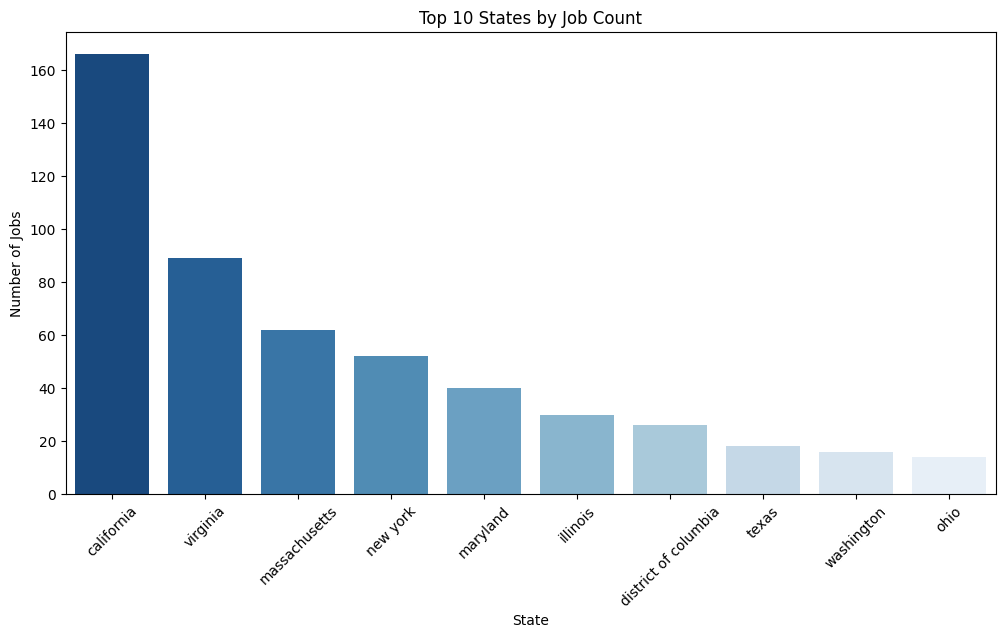

C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1429009733.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_stats.sort_values(by='Avg_Salary', ascending=False).head(10),


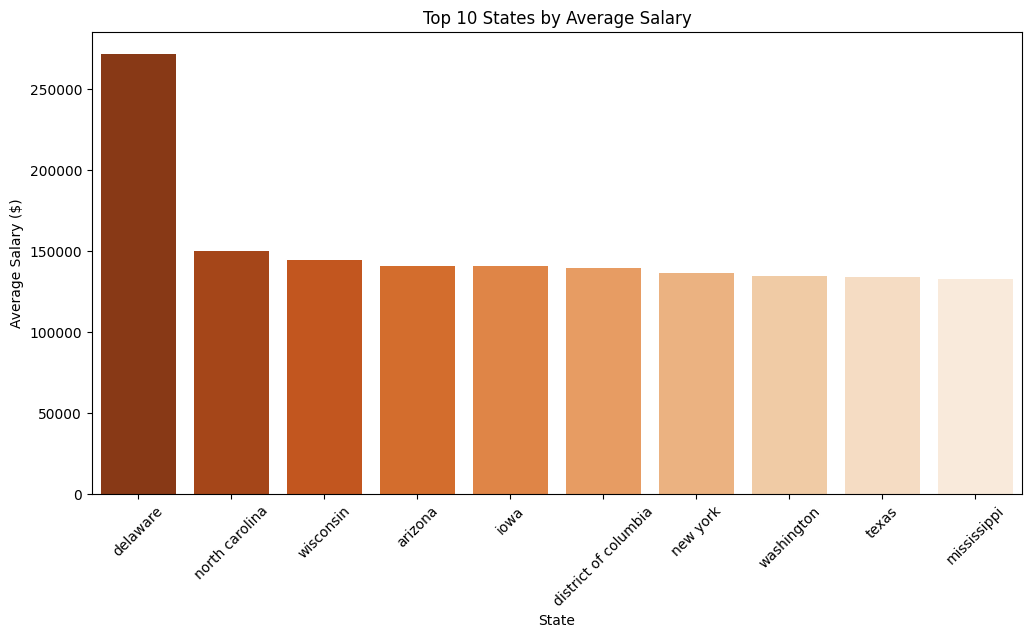

In [98]:
# # Extract state from location (assuming 'Location' column is in 'City, State' format)
df['State'] = df['New_Location'].str.split(',').str[-1].str.strip()

state_stats = df.groupby('State').agg(
    Job_Count=('Job Title', 'count'),
    Avg_Salary=('Avg_Salary', 'mean')
).reset_index()
state_stats = state_stats.sort_values(by='Job_Count', ascending=False)

print(state_stats.head(10))  
plt.figure(figsize=(12, 6))
sns.barplot(data=state_stats.head(10), x='State', y='Job_Count', palette="Blues_r")
plt.title("Top 10 States by Job Count")
plt.ylabel("Number of Jobs")
plt.xlabel("State")
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(data=state_stats.sort_values(by='Avg_Salary', ascending=False).head(10), 
            x='State', y='Avg_Salary', palette="Oranges_r")
plt.title("Top 10 States by Average Salary")
plt.ylabel("Average Salary ($)")
plt.xlabel("State")
plt.xticks(rotation=45)
plt.show()


Competitor Impact on Salary: Compare salary ranges for companies with and without listed competitors to analyze if competition impacts salaries.


Competitors
[]                                                                                                      501
['roche', 'glaxosmithkline', 'novartis']                                                                 10
['leidos', 'caci international', 'booz allen hamilton']                                                   6
['los alamos national laboratory', 'battelle', 'sri international']                                       6
['oak ridge national laboratory', 'national renewable energy lab', 'los alamos national laboratory']      3
                                                                                                       ... 
['united natural foods', 'us foods', 'dpi specialty foods']                                               1
['liveperson', 'salesforce', 'sap']                                                                       1
['zurich insurance', 'axa xl', 'allianz']                                                                 1
['csc', 'mantech

C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1065954415.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




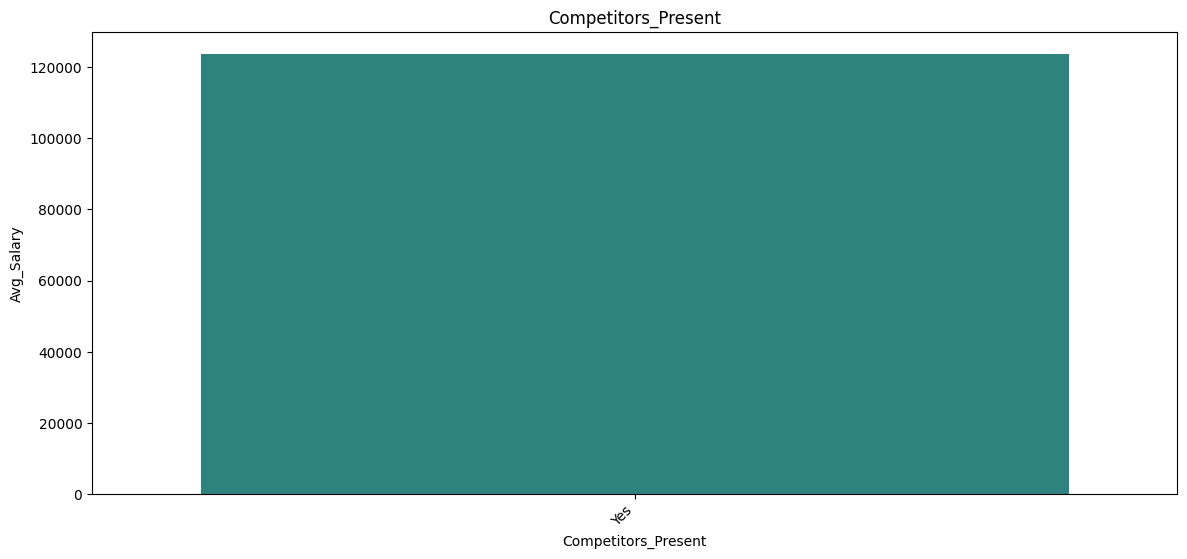

In [162]:
print(df['Competitors'].value_counts())
df['Competitors_Present'] = df['Competitors'].apply(lambda x: 'No' if x == '[-1]'   else 'Yes')
df['Competitors_Present'].value_counts()


company_salary = df.groupby('Competitors_Present')['Avg_Salary'].mean().reset_index()
print(company_salary )
plt.figure(figsize=(14, 6))
sns.barplot(data=company_salary, x='Competitors_Present', y='Avg_Salary', palette="viridis")

plt.xticks(rotation=45, ha="right")
plt.title('Competitors_Present')
plt.ylabel('Avg_Salary')
plt.xlabel('Competitors_Present')
plt.show()



Industry Longevity Analysis: Compare average founding years by industry to see if certain industries have more established companies.


                                   Industry      Founded
0                   advertising & marketing  1995.285714
1                       aerospace & defense  1931.529412
2                     banks & credit unions  1954.857143
3                 biotech & pharmaceuticals  1969.518519
4                    chemical manufacturing  1973.000000
5                   colleges & universities  1800.000000
6              computer hardware & software  1972.346154
7                                consulting  1988.400000
8           consumer products manufacturing  1941.600000
9                                    energy  1965.000000
10  enterprise software & network solutions  1997.918919
11                         federal agencies  1969.500000
12            food & beverage manufacturing  1911.000000
13         health care services & hospitals  1977.454545
14                 industrial manufacturing  1950.500000
15                       insurance carriers  1939.848485
16                             

C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\514956709.py:6: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



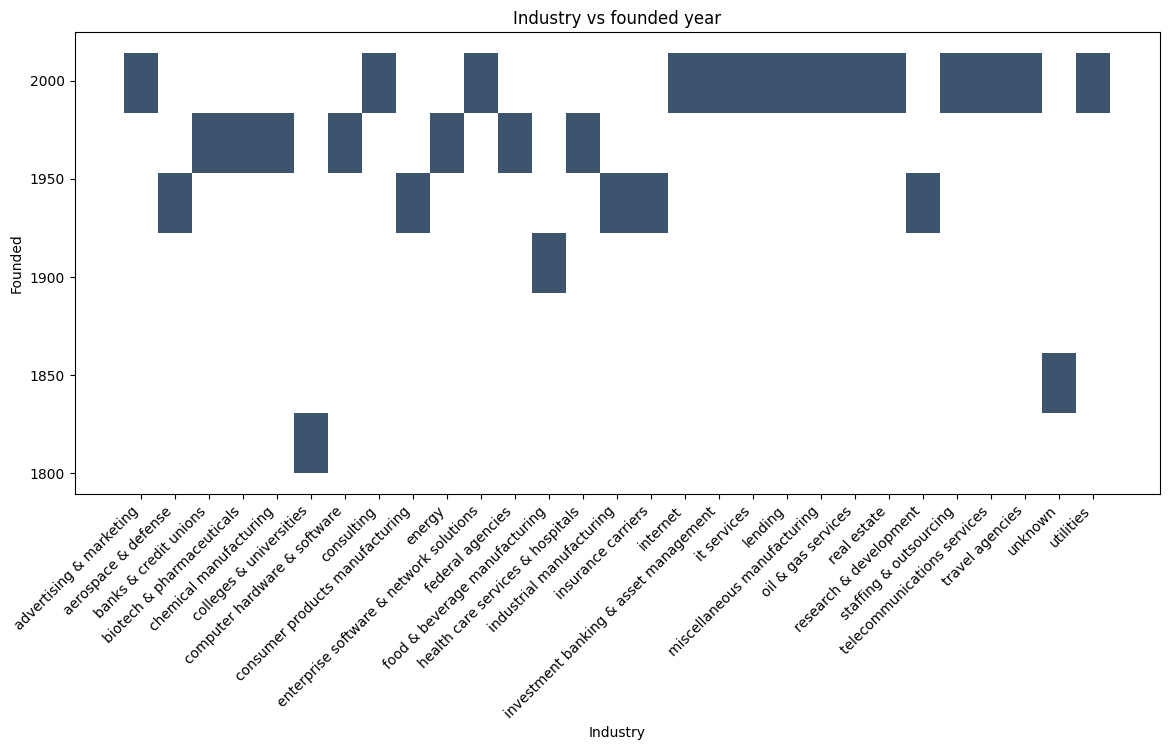

In [164]:
#
company_salary = df.groupby('Industry')['Founded'].mean().reset_index()
print(company_salary )
plt.figure(figsize=(14, 6))
sns.histplot(data=company_salary, x='Industry', y='Founded', palette="viridis")

plt.xticks(rotation=45, ha="right")
plt.title('Industry vs founded year')
plt.ylabel('Founded')
plt.xlabel('Industry')
plt.show()




Rating and Salary Disparity: Analyze if companies with higher ratings offer salaries that deviate more from industry or sector norms.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\3228983460.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Rating_Category', y='Industry_Salary_Deviation', data=df, palette="coolwarm")


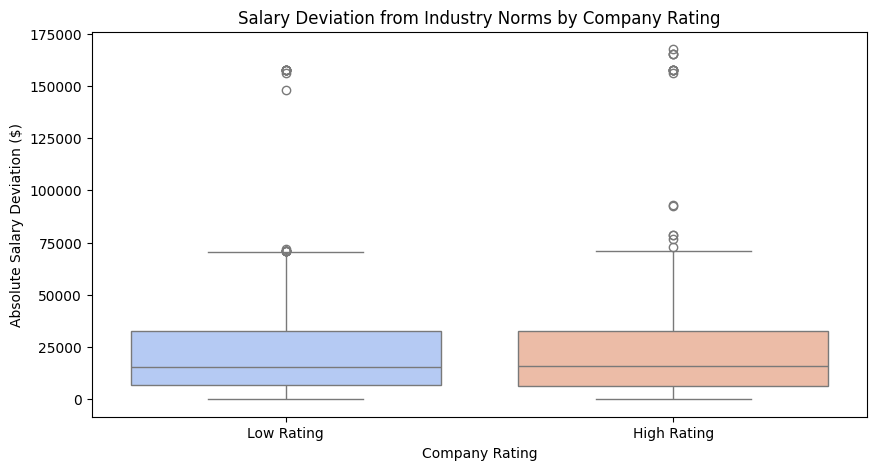

In [101]:
df['Avg_Salary'] = pd.to_numeric(df['Avg_Salary'], errors='coerce')
industry_salary_median = df.groupby('Industry')['Avg_Salary'].median()
sector_salary_median = df.groupby('Sector')['Avg_Salary'].median()
df['Industry_Median_Salary'] = df['Industry'].map(industry_salary_median)
df['Sector_Median_Salary'] = df['Sector'].map(sector_salary_median)

df['Industry_Salary_Deviation'] = np.abs(df['Avg_Salary'] - df['Industry_Median_Salary'])
df['Sector_Salary_Deviation'] = np.abs(df['Avg_Salary'] - df['Sector_Median_Salary'])

rating_median = df['Rating'].median()
df['Rating_Category'] = df['Rating'].apply(lambda x: 'High Rating' if x >= rating_median else 'Low Rating')

plt.figure(figsize=(10, 5))
sns.boxplot(x='Rating_Category', y='Industry_Salary_Deviation', data=df, palette="coolwarm")
plt.title("Salary Deviation from Industry Norms by Company Rating")
plt.ylabel("Absolute Salary Deviation ($)")
plt.xlabel("Company Rating")
plt.show()




Advanced Data Insights and Parsing

Identify and count the most frequently listed competitors across all companies. Create a column to show how many times each competitor is mentioned.

In [102]:
# 
print(df['Competitors'].head(10)) 
print(df['Competitors'].dtype) 

0              emblemhealth, unitedhealth group, aetna
1                                                   -1
2                                                   -1
3    mks instruments, pfeiffer vacuum, agilent tech...
4                 commerce signals, cardlytics, yodlee
5                                                   -1
6                                                   -1
7                                                   -1
8                            square, paypal, h&r block
9                                                   -1
Name: Competitors, dtype: object
object


In [103]:
# Convert string competitors into lists
df['Competitors'] = df['Competitors'].apply(lambda x: x.split(', ') if x != '-1' else [])


In [104]:
all_competitors = [comp for sublist in df['Competitors'] for comp in sublist]
competitor_counts = Counter(all_competitors)
df['Competitor_Mention_Count'] = df['Competitors'].apply(lambda x: sum(competitor_counts[comp] for comp in x) if x else 0)

top_competitors = pd.DataFrame(competitor_counts.most_common(10), columns=['Competitor', 'Count'])
print(top_competitors)


                       Competitor  Count
0             booz allen hamilton     16
1                        novartis     13
2  los alamos national laboratory     11
3                 glaxosmithkline     11
4                           roche     10
5                          leidos      9
6                        battelle      9
7                northrop grumman      8
8              caci international      7
9                            saic      7


For companies with multiple competitors listed, calculate the average rating difference between them and their competitors. Are highlyrated companies more likely to list high-profile competitors?


In [105]:

def competitor_avg_rating(row, df):
    competitors = row['Competitors'].split(', ') if isinstance(row['Competitors'], str) else []
    competitor_ratings = df[df['Cleaned_Company Name'].isin(competitors)]['Rating']
    
    if not competitor_ratings.empty:
        return competitor_ratings.mean()
    return None

df['Competitor_Avg_Rating'] = df.apply(lambda row: competitor_avg_rating(row, df), axis=1)
df['Rating_Difference'] = df['Rating'] - df['Competitor_Avg_Rating']
df[['Cleaned_Company Name', 'Rating', 'Competitor_Avg_Rating', 'Rating_Difference']].value_counts()

Series([], Name: count, dtype: int64)

Create a column indicating whether a company shares competitors with any top-rated companies (Rating  4), and analyze if this has any effect on its own rating.


In [106]:
top_rated_companies = set(df[df['Rating'] >= 4]['Cleaned_Company Name'])
def shares_competitors_with_top_rated(row, top_rated_companies):
    competitors = set(row['Competitors'].split(', ')) if isinstance(row['Competitors'], str) else set()
    return bool(competitors & top_rated_companies)  # Check if intersection exists
df['Shares_Competitors_With_Top'] = df.apply(lambda row: shares_competitors_with_top_rated(row, top_rated_companies), axis=1)
avg_rating_with_top = df[df['Shares_Competitors_With_Top']]['Rating'].mean()
avg_rating_without_top = df[~df['Shares_Competitors_With_Top']]['Rating'].mean()

print(df[['Cleaned_Company Name', 'Rating', 'Shares_Competitors_With_Top']].value_counts())
print("Average Rating for Companies Sharing Competitors with Top-Rated Companies:", avg_rating_with_top)
print("Average Rating for Companies NOT Sharing Competitors with Top-Rated Companies:", avg_rating_without_top)


Cleaned_Company Name  Rating    Shares_Competitors_With_Top
maxar                 3.500000  False                          12
hatch                 3.518601  False                          12
tempus                3.300000  False                          11
astrazeneca           4.000000  False                          10
klaviyo               4.800000  False                           8
                                                               ..
unicom                4.700000  False                           1
united                2.300000  False                           1
upstart               4.200000  False                           1
us                    3.200000  False                           1
usac                  2.700000  False                           1
Name: count, Length: 434, dtype: int64
Average Rating for Companies Sharing Competitors with Top-Rated Companies: nan
Average Rating for Companies NOT Sharing Competitors with Top-Rated Companies: 3.854807


Determine the sectors with the most diversity in industries and analyze if this correlates with higher salary estimates or job counts.


In [107]:
# industry_diversity = df.groupby('Sector')['Industry'].nunique().reset_index()
industry_diversity.columns = ['Sector', 'Industry_Count']

avg_salary = df.groupby('Sector')['Avg_Salary'].mean().reset_index()
avg_salary.columns = ['Sector', 'Avg_Salary']
job_count = df.groupby('Sector').size().reset_index(name='Job_Count')

sector_analysis = industry_diversity.merge(avg_salary, on='Sector').merge(job_count, on='Sector')
print(sector_analysis)

correlation_salary = sector_analysis[['Industry_Count', 'Avg_Salary']].corr().iloc[0, 1]
correlation_jobs = sector_analysis[['Industry_Count', 'Job_Count']].corr().iloc[0, 1]

print("Correlation between Industry Diversity and Salary Estimates:", correlation_salary)
print("Correlation between Industry Diversity and Job Counts:", correlation_jobs)

                          Sector  Industry_Count     Avg_Salary  Job_Count
0            aerospace & defense               1  133088.235294         17
1      biotech & pharmaceuticals               1  125333.333333         54
2              business services               4  126355.191257        366
3                      education               1  148000.000000          1
4                        finance               3  121187.500000         32
5                     government               1  141166.666667          6
6                    health care               1  125181.818182         11
7         information technology               4  118795.833333        120
8                      insurance               1  108666.666667         33
9                  manufacturing               5  117500.000000         13
10  oil, gas, energy & utilities               3  101250.000000          8
11                   real estate               1   97000.000000          1
12            telecommuni

Find the industries with the highest average ratings and analyze which specific sectors they belong to. Does belonging to a specific sector influence the industry’s average rating?


In [108]:
# 
industry_ratings = df.groupby('Industry')['Rating'].mean().reset_index()
industry_ratings.columns = ['Industry', 'Avg_Rating']
top_industries = industry_ratings.sort_values(by='Avg_Rating', ascending=False).head(5)
top_industries = top_industries.merge(df[['Industry', 'Sector']].drop_duplicates(), on='Industry')
sector_ratings = df.groupby('Sector')['Rating'].mean().reset_index()
sector_ratings.columns = ['Sector', 'Avg_Sector_Rating']
top_industries = top_industries.merge(sector_ratings, on='Sector')

print(top_industries)
correlation = top_industries[['Avg_Rating', 'Avg_Sector_Rating']].corr().iloc[0, 1]
print("\nCorrelation between Industry Rating and Sector Rating:", correlation)

                                  Industry  Avg_Rating  \
0                   staffing & outsourcing    4.800000   
1                              it services    4.564286   
2                                  lending    4.260000   
3             computer hardware & software    4.088462   
4  enterprise software & network solutions    4.075676   

                   Sector  Avg_Sector_Rating  
0       business services           3.812994  
1  information technology           4.130834  
2                 finance           3.909375  
3  information technology           4.130834  
4  information technology           4.130834  

Correlation between Industry Rating and Sector Rating: -0.6205210944675521


Identify industries with the highest number of job postings and check if these align with high salary estimates. Is there a trend between industry popularity and salary?


                   Industry     Avg_Salary
0    chemical manufacturing  154000.000000
1                   unknown  149100.000000
2   colleges & universities  148000.000000
3          federal agencies  140000.000000
4                consulting  137400.000000
5  industrial manufacturing  134750.000000
6       aerospace & defense  133088.235294
7    staffing & outsourcing  130750.000000
8     banks & credit unions  128666.666667
9    research & development  125808.544304


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1826152941.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



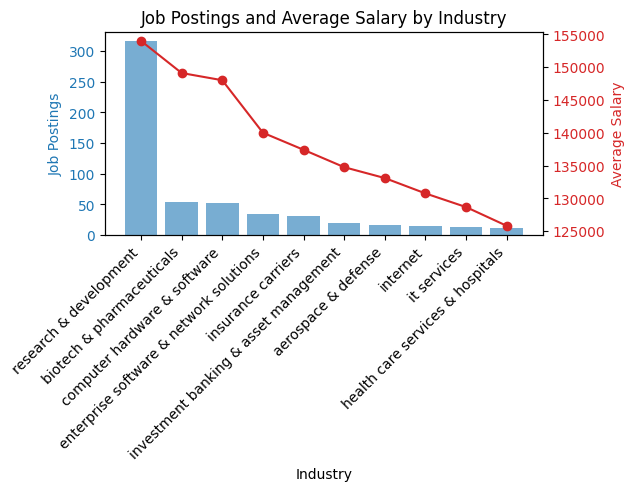

In [238]:
# 

job_postings=df.groupby('Industry')['Job Title'].count()
job_postings_avg=df.groupby('Industry')['Avg_Salary'].mean()
top_jobs = job_postings.sort_values(ascending=False).head(10).reset_index()
top_jobs_avg = job_postings_avg.sort_values(ascending=False).head(10).reset_index()

print(top_jobs_avg)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Industry')
ax1.set_ylabel('Job Postings', color=color)
ax1.bar(top_jobs['Industry'], top_jobs['Job Title'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(top_jobs['Industry'], rotation=45, ha='right')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Salary', color=color)
ax2.plot(top_jobs['Industry'], top_jobs_avg['Avg_Salary'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Job Postings and Average Salary by Industry')
plt.show()




Group companies by ”Size” and analyze the average founding year for each size group. Are larger companies generally older, or is there a trend of newer, fast-growing companies in the dataset?


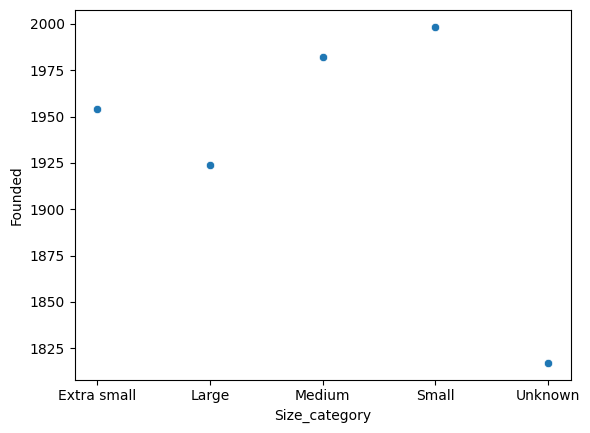

<Figure size 1400x600 with 0 Axes>

In [167]:
# 
size_grp=df.groupby('Size_category')['Founded'].mean().reset_index()
sns.scatterplot(data=size_grp,x='Size_category',y='Founded')
plt.figure(figsize=(14, 6))

plt.show()

Create an ”Employee Growth Index” by dividing the number of employees (from ”Size”) by the number of years since founding. Compare this index across sectors to identify fast-growing sectors.


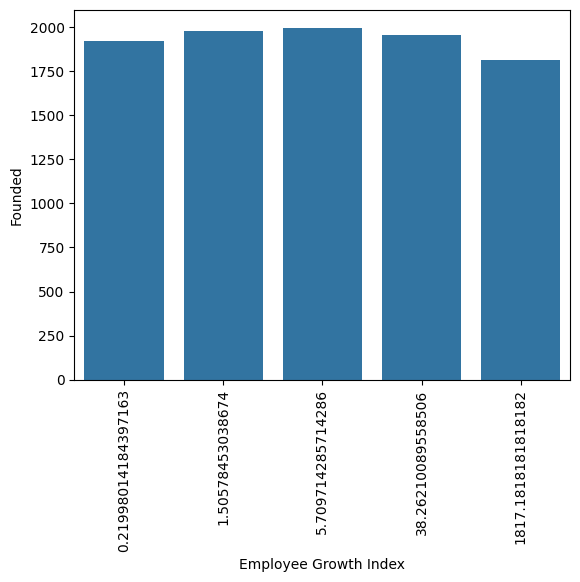

<Figure size 1400x600 with 0 Axes>

In [170]:
# 
df['Employee_count']=df['size_split'].apply(lambda x: round((int(x[0])+int(x[2]))/2) if 'to' in x else ( 1 if 'Unknown' in x  else 10000))
df['Employee_count']=df['Employee_count'].astype(int)
df['Employee Growth Index']=(df['Founded']/df['Employee_count'])
df['Employee Growth Index'].value_counts()


grp=df.groupby('Size_category')[['Employee Growth Index','Founded']].mean().reset_index()
sns.barplot(data=grp,x='Employee Growth Index',y='Founded')
plt.xticks(rotation=90)
plt.figure(figsize=(14, 6))


plt.show()

For each company, calculate the ratio of the company size to the number of competitors listed. Does a larger company tend to have more competitors?



In [113]:
#
df['Ratio_size_competitor']=df['Competitors_Count']/df['Employee_count']

print(df['Ratio_size_competitor'].value_counts().sort_values())

print(df[['Ratio_size_competitor','Size_category']].sort_values(by='Ratio_size_competitor',ascending=True).head(10))

Ratio_size_competitor
0.038462      1
0.000100      1
0.000133      1
0.115385      2
0.005714      2
3.000000      2
0.000267      2
0.000333      3
0.002667      5
0.000667      5
0.015873      6
0.000200     10
0.023810     14
0.008571     15
0.000400     17
0.004000     19
0.001000     30
0.000300     36
0.000000    501
Name: count, dtype: int64
     Ratio_size_competitor Size_category
17                     0.0        Medium
659                    0.0         Large
658                    0.0   Extra small
657                    0.0       Unknown
656                    0.0       Unknown
31                     0.0         Large
30                     0.0        Medium
29                     0.0   Extra small
28                     0.0   Extra small
27                     0.0        Medium


For companies with available revenue data, calculate the revenue per employee (using ”Revenue” and ”Size”) and analyze which sectors have the highest revenue per employee.

Rev_per_emp
7.936508e+08    56
5.500000e+06    53
1.000000e+05    43
1.000000e+11    43
3.846154e+09    41
1.333333e+08    37
1.388889e+05    30
2.857143e+08    27
4.666667e+05    26
4.000000e+05    26
2.976190e+05    26
1.153846e+05    25
8.571429e+05    25
3.333333e+07    22
2.142857e+05    16
5.000000e+05    15
2.000000e+05    13
2.500000e+05    12
3.846154e+04    12
1.166667e+06    12
5.952381e+04    10
1.000000e+07    10
5.000000e+04     9
7.333333e+06     9
1.000000e+06     7
1.500000e+05     6
3.500000e+05     6
2.380952e+06     6
1.071429e+05     5
6.730769e+05     5
2.500000e+04     5
7.500000e+05     4
1.333333e+07     4
5.952381e+05     3
4.000000e+04     3
2.380952e+04     3
8.571429e+03     3
4.285714e+06     2
2.884615e+05     2
1.833333e+07     1
7.500000e+02     1
5.833333e+03     1
4.666667e+06     1
2.142857e+04     1
1.250000e+04     1
2.500000e+06     1
2.142857e+06     1
7.936508e+03     1
2.884615e+06     1
Name: count, dtype: int64


<Figure size 1400x600 with 0 Axes>

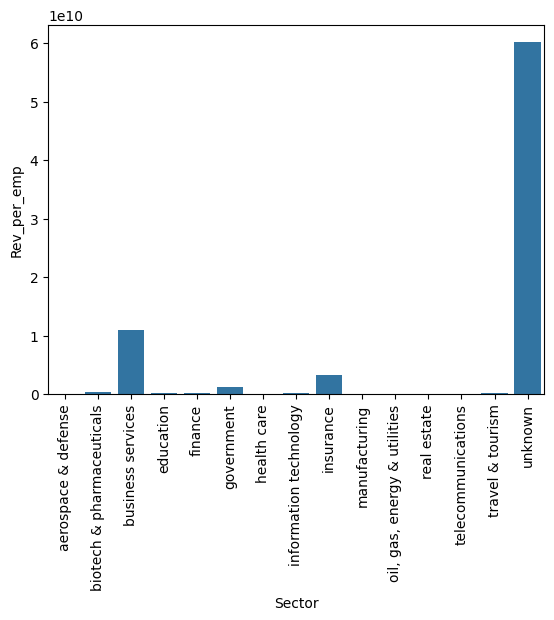

<Figure size 1400x600 with 0 Axes>

In [114]:



df['Rev_per_emp']=df['Avg_Revenue']/df['Employee_count']
print(df['Rev_per_emp'].value_counts())


sec=df.groupby('Sector')['Rev_per_emp'].mean().reset_index()
sns.barplot(data=sec,x='Sector',y='Rev_per_emp')
plt.xticks(rotation=90)
plt.figure(figsize=(14, 6))


Determine the average revenue for each sector and examine if highrevenue sectors have higher-rated companies on average.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1126792413.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sector, x='Avg_Revenue', y='Rating', palette="viridis")


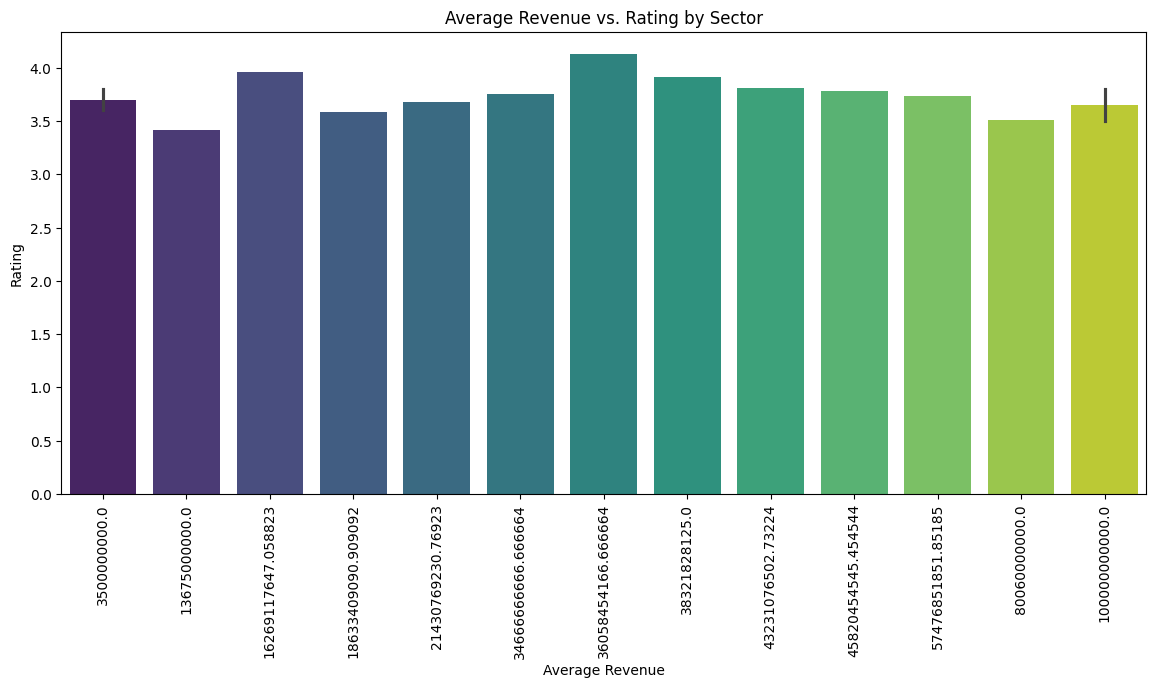

In [115]:


sector = df.groupby('Sector')[['Rating', 'Avg_Revenue']].mean().reset_index()
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=sector, x='Avg_Revenue', y='Rating', palette="viridis")
plt.xticks(rotation=90)
plt.xlabel('Average Revenue')
plt.ylabel('Rating')
plt.title('Average Revenue vs. Rating by Sector')

plt.show()


 Identify companies with the widest revenue ranges and examine if these companies have more job postings or higher ratings.


    Cleaned_Company Name  Revenue_Range  \
6               novartis   9.000000e+10   
381           massmutual   9.000000e+10   
383            travelers   9.000000e+10   
387               biogen   9.000000e+10   
404             reynolds   9.000000e+10   
395              liberty   9.000000e+10   
73           caterpillar   9.000000e+10   
60                 swiss   9.000000e+10   
370          astrazeneca   9.000000e+10   
365               takeda   9.000000e+10   

                                             Job Title  Rating  
6             data scientist / machine learning expert     3.9  
381                  data modeler (analytical systems)     3.7  
383        data engineer (analytics, sql, python, aws)     4.0  
387  it partner digital health technology and data ...     3.6  
404  senior scientist - toxicologist - product inte...     3.3  
395             data solutions engineer - data modeler     3.4  
73                               business data analyst     3.7  
60    

C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\3395871350.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_revenue_range_analysis, x=top_revenue_range_analysis.index, y='Job_Postings', palette='coolwarm')


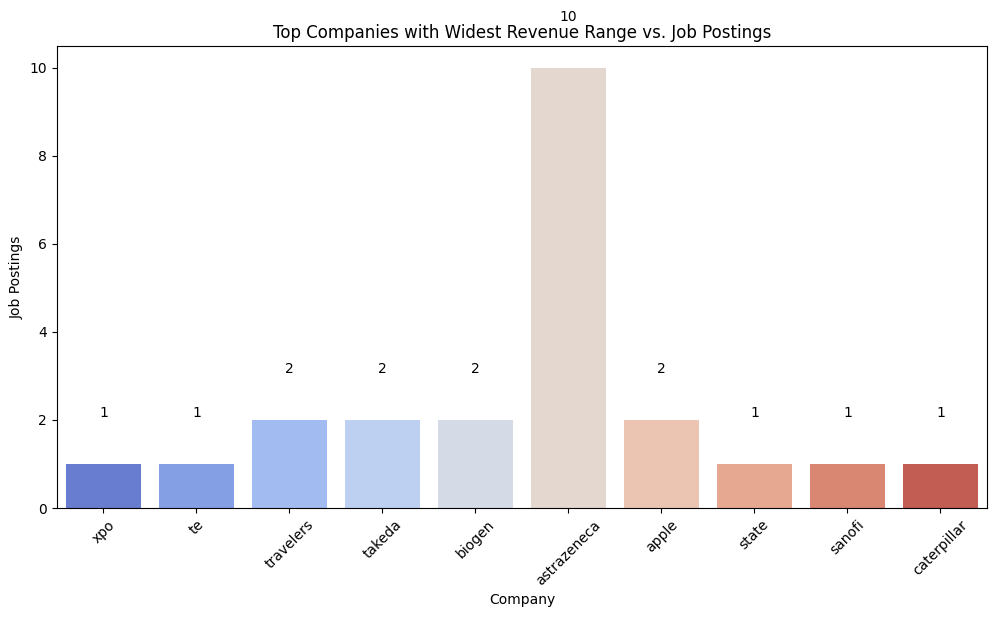

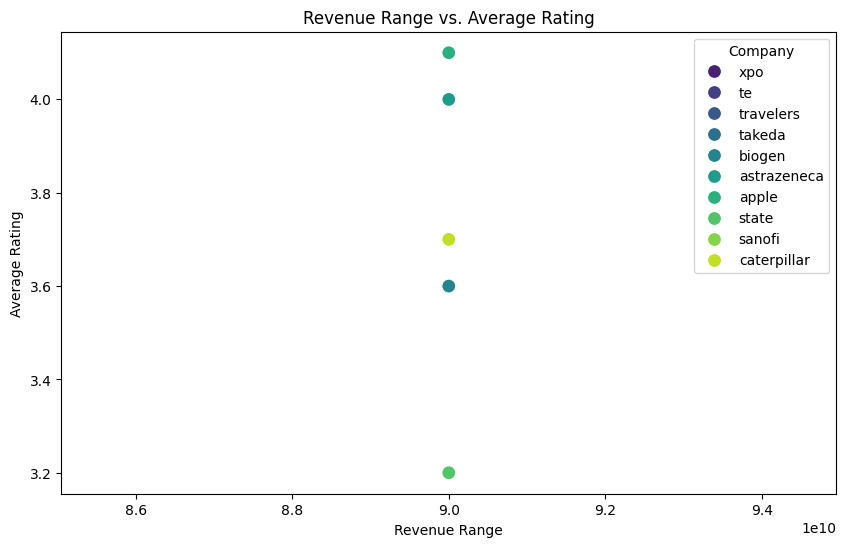

In [116]:
df['Revenue_Range'] = df['Revenue_Max_Numeric'] - df['Revenue_Min_Numeric']

top_revenue_range = df[['Cleaned_Company Name', 'Revenue_Range', 'Job Title', 'Rating']].sort_values(by='Revenue_Range', ascending=False).head(10)
print(top_revenue_range)

top_revenue_range_analysis = df.groupby('Cleaned_Company Name').agg(
    Job_Postings=('Job Title', 'count'),
    Avg_Rating=('Rating', 'mean'),
    Revenue_Range=('Revenue_Range', 'max')
).sort_values(by='Revenue_Range', ascending=False).head(10)

print(top_revenue_range_analysis)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_revenue_range_analysis, x=top_revenue_range_analysis.index, y='Job_Postings', palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Top Companies with Widest Revenue Range vs. Job Postings")
plt.xlabel("Company")
plt.ylabel("Job Postings")

for index, row in enumerate(top_revenue_range_analysis['Job_Postings']):
    ax.text(index, row + 1, str(row), ha='center', va='bottom')

plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_revenue_range_analysis, x='Revenue_Range', y='Avg_Rating', hue=top_revenue_range_analysis.index, s=100, palette='viridis')
# sns.barplot(data=top_revenue_range_analysis, x='Revenue_Range', y='Avg_Rating', palette='coolwarm')

plt.title("Revenue Range vs. Average Rating")
plt.xlabel("Revenue Range")
plt.ylabel("Average Rating")
plt.legend(title="Company", bbox_to_anchor=(1, 1))

plt.show()



For each job title, calculate the average salary range width (difference between max and min salary) to see which roles have the most salary variability.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1200923585.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=job,y='Salary_Range', x='Job Title', palette='coolwarm')


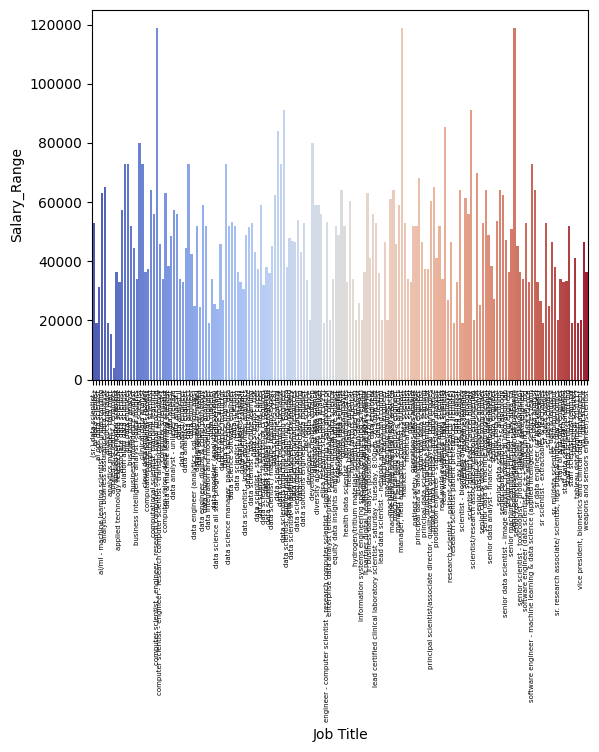

In [117]:
# 
df['Salary_Range'] = df['max_salary'] - df['min_salary']
job=df.groupby('Job Title')['Salary_Range'].mean().reset_index()
sns.barplot(data=job,y='Salary_Range', x='Job Title', palette='coolwarm')
plt.xticks(rotation=90,fontsize=5)
plt.show()

Identify the top 5 job titles with the highest average salary ranges and analyze if they are concentrated in certain sectors or locations


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\4087323192.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=job,y='Salary_Range', x='New_Location', palette='coolwarm')


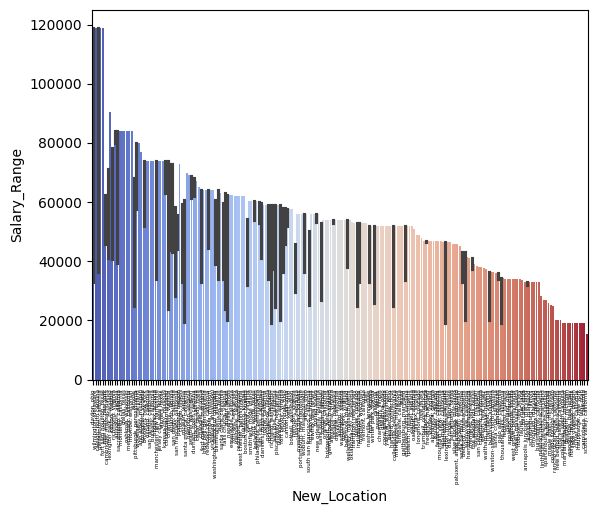

                                             Job Title  \
23   computer scientist - engineer - research compu...   
291                 real world science, data scientist   
274    manager, field application scientist, southeast   
324         senior principal data scientist (python/r)   
116                                     data scientist   
220        data scientist(s)/machine learning engineer   
300             scientist / group lead, cancer biology   
134                                     data scientist   
32                                        data analyst   
171                                     data scientist   

                 New_Location                     Sector  Salary_Range  
23               dayton, ohio          business services      119000.0  
291      wilmington, delaware  biotech & pharmaceuticals      119000.0  
274   raleigh, north carolina  biotech & pharmaceuticals      119000.0  
324    pleasanton, california  biotech & pharmaceuticals      119000.

In [118]:
# 
job = df.groupby(['Job Title', 'New_Location', 'Sector'])['Salary_Range'].mean().reset_index()
job = job.sort_values(by='Salary_Range', ascending=False)

sns.barplot(data=job,y='Salary_Range', x='New_Location', palette='coolwarm')
plt.xticks(rotation=90,fontsize=4)
plt.show()
print(job.head(10))


Compare median salary ranges between private and public companies to determine if there’s a significant difference based on ownership type.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1303972522.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=median_sal,y='Avg_Salary', x='Company_Type', palette='coolwarm')


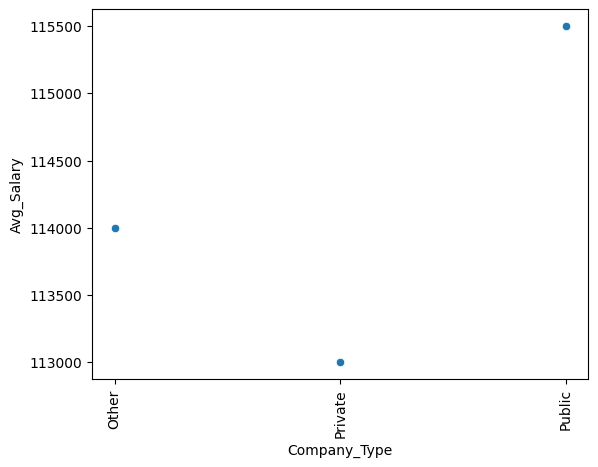

In [119]:
#
median_sal=df.groupby('Company_Type')['Avg_Salary'].median().reset_index()


sns.scatterplot(data=median_sal,y='Avg_Salary', x='Company_Type', palette='coolwarm')
plt.xticks(rotation=90,fontsize=10)
plt.show()

In [120]:
df.columns

Index(['index', 'Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Salary Type', 'Cleaned_Company Name', 'identifier', 'Loc',
       'New_Location', 'HQ', 'New_Headquarters', 'Distance', 'Minimum_Revenue',
       'Maximum_Revenue', 'Length_Job_Description', 'Allows_Remote',
       'Experience Level', 'size_split', 'Size_category', 'min_salary',
       'max_salary', 'Avg_Salary', 'Salary_outlier', 'Rating_outlier',
       'founded_year_outlier', 'Revenue_Min_Numeric', 'Revenue_Max_Numeric',
       'Avg_Revenue', 'Employee_count', 'Competitors_Count', 'python_skill',
       'sql_skill', 'machine learning_skill', 'maths_skill',
       'healthcare_benefit', 'retirement_benefit', 'stock_benefit',
       'bonus_benefit', 'age_of_company', 'Company_Age_Category', 'Region',
       'Avg_Size', 'Revenue_per_employee', 'Salary_Range_Bu

Identify the top 10 keywords in ”Job Description” across different sectors. Are certain keywords unique to specific sectors?


In [121]:
# 

sector_texts = df.groupby('Sector')['Job Description'].apply(lambda x: ' '.join(x)).reset_index()
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  
tfidf_matrix = vectorizer.fit_transform(sector_texts['Job Description'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=sector_texts['Sector'], columns=vectorizer.get_feature_names_out())
top_keywords = {}
for sector in tfidf_df.index:
    top_words = tfidf_df.loc[sector].nlargest(10).index.tolist()
    top_keywords[sector] = top_words
keywords_df = pd.DataFrame.from_dict(top_keywords, orient='index')
keywords_df = keywords_df.transpose()


print("Top 10 Keywords for Each Sector (TF-IDF Based):")
print(keywords_df)


Top 10 Keywords for Each Sector (TF-IDF Based):
  aerospace & defense biotech & pharmaceuticals business services  \
0                data                      data              data   
1          experience                experience        experience   
2            decision                   science          learning   
3         engineering                  clinical           science   
4           clearance               development          business   
5             systems                scientific           machine   
6            learning                    skills              work   
7             science                      team          analysis   
8              skills                  learning            skills   
9            security                   biology              team   

       education     finance  government health care information technology  \
0    information        data        data        data                   data   
1       required  experience  expe

Parse common industry-specific terms from ”Job Description” (e.g., ”fintech” for finance, ”sustainability” for environmental) and analyze if jobs mentioning these terms have higher average ratings


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1048065042.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_ratings, x='Industry_Term', y='Rating', palette='coolwarm')


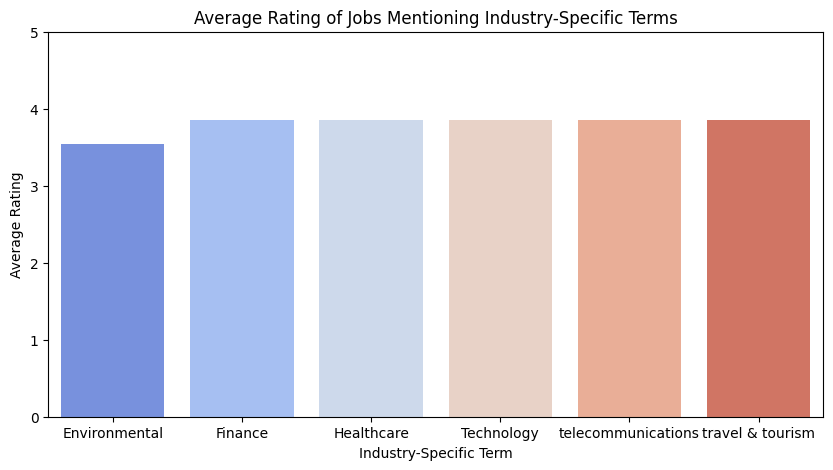

In [122]:
industry_keywords = {
    'Finance': ['fintech', 'investment', 'trading', 'banking', 'financial'],
    'Technology': ['ai', 'machine learning', 'deep learning', 'software', 'data science'],
    'Healthcare': ['pharma', 'biotech', 'hospital', 'healthcare', 'medical'],
    'Environmental': ['sustainability', 'climate', 'renewable', 'green energy', 'carbon'],
    'travel & tourism':['work','vacation','environment','business','learning'],
    'telecommunications':['network','experience','nlp','science','machine','data']
}
for industry, keywords in industry_keywords.items():
    df[industry] = df['Job Description'].apply(lambda x: any(term in x for term in keywords))
melted_df = df.melt(id_vars=['Rating'], value_vars=industry_keywords.keys(), 
                     var_name='Industry_Term', value_name='Mentioned')
melted_df = melted_df[melted_df['Mentioned']]
avg_ratings = melted_df.groupby('Industry_Term')['Rating'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(data=avg_ratings, x='Industry_Term', y='Rating', palette='coolwarm')
plt.title('Average Rating of Jobs Mentioning Industry-Specific Terms')
plt.ylabel('Average Rating')
plt.xlabel('Industry-Specific Term')
plt.ylim(0, 5) 
plt.show()


Check the percentage of job descriptions mentioning benefits like ”remote,” ”flexible hours,” or ”bonus,” and analyze if jobs mentioning these perks have higher average ratings.
perks

C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1076852967.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(perk_analysis['Perk'], rotation=45)


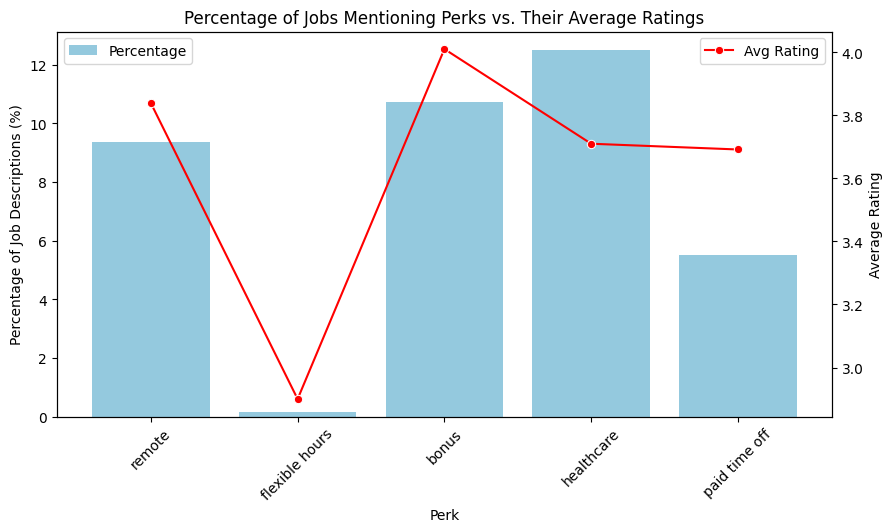

In [123]:
perks = ['remote', 'flexible hours', 'bonus', 'healthcare', 'paid time off']

df['Job Description'] = df['Job Description'].astype(str).str.lower()

for perk in perks:
    df[perk] = df['Job Description'].apply(lambda x: 1 if perk in x else 0)

perk_counts = df[perks].sum() / len(df) * 100
perk_counts = perk_counts.reset_index().rename(columns={'index': 'Perk', 0: 'Percentage'})
perk_ratings = df.melt(id_vars=['Rating'], value_vars=perks, 
                        var_name='Perk', value_name='Presence')
perk_ratings = perk_ratings[perk_ratings['Presence'] == 1]  # Only where perk is present
avg_ratings = perk_ratings.groupby('Perk')['Rating'].mean().reset_index()
perk_analysis = perk_counts.merge(avg_ratings, on='Perk')
perk_analysis.rename(columns={'Rating': 'Avg_Rating'}, inplace=True)

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=perk_analysis, x='Perk', y='Percentage', ax=ax1, color='skyblue', label='Percentage')
ax2 = ax1.twinx()
sns.lineplot(data=perk_analysis, x='Perk', y='Avg_Rating', ax=ax2, color='red', marker='o', label='Avg Rating')

ax1.set_ylabel('Percentage of Job Descriptions (%)')
ax2.set_ylabel('Average Rating')
ax1.set_xlabel('Perk')
ax1.set_title('Percentage of Jobs Mentioning Perks vs. Their Average Ratings')
ax1.set_xticklabels(perk_analysis['Perk'], rotation=45)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Calculate the average rating for companies that list specific highprofile competitors (e.g., Google, Microsoft) and compare it to the ratings of companies without those competitors.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\711355413.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rating_comparison, x='Category', y='Rating', palette=['red', 'blue'])


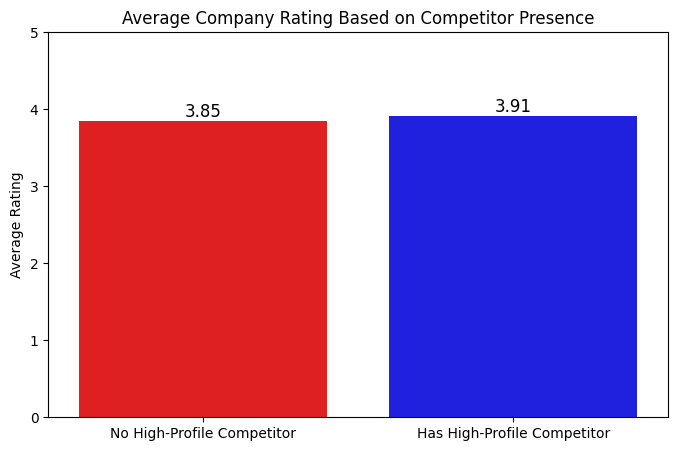

In [124]:
high_profile_competitors = ['google', 'microsoft', 'amazon', 'apple', 'facebook', 'netflix']
df['Competitors'] = df['Competitors'].astype(str).str.lower()

df['High_Profile_Competitor'] = df['Competitors'].apply(
    lambda x: 1 if any(comp in x for comp in high_profile_competitors) else 0
)
rating_comparison = df.groupby('High_Profile_Competitor')['Rating'].mean().reset_index()
rating_comparison['Category'] = rating_comparison['High_Profile_Competitor'].map({1: 'Has High-Profile Competitor', 0: 'No High-Profile Competitor'})
plt.figure(figsize=(8, 5))
sns.barplot(data=rating_comparison, x='Category', y='Rating', palette=['red', 'blue'])
plt.xlabel('')
plt.ylabel('Average Rating')
plt.title('Average Company Rating Based on Competitor Presence')
plt.ylim(0, 5)

for index, value in enumerate(rating_comparison['Rating']):
    plt.text(index, value + 0.05, round(value, 2), ha='center', fontsize=12)

plt.show()


Create a ”Competitor Count Impact Score” by examining if companies with a higher number of competitors listed tend to have higher or lower ratings.


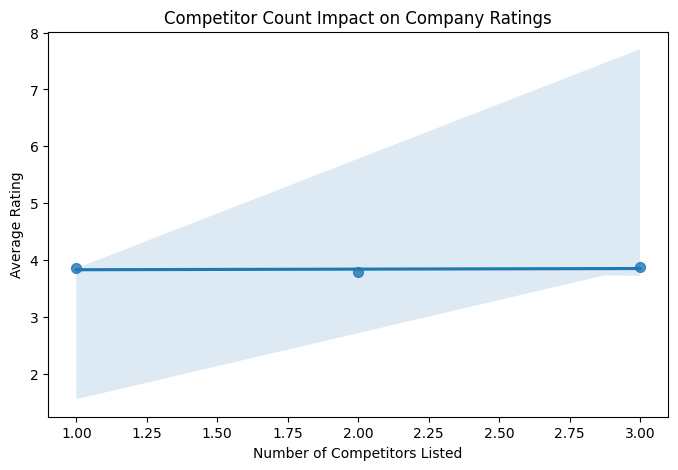

In [171]:

df['Competitor_Count'] = df['Competitors'].apply(lambda x: len(str(x).split(',')) if x not in ['-1', None, ''] else 0)

competitor_impact = df.groupby('Competitor_Count')['Rating'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.regplot(data=competitor_impact, x='Competitor_Count', y='Rating', scatter_kws={'s': 50})

plt.xlabel('Number of Competitors Listed')
plt.ylabel('Average Rating')
plt.title('Competitor Count Impact on Company Ratings')

plt.show()


Analyze if companies with unique competitors (listed only once) have distinct characteristics in ratings or salary compared to those with common competitors.


  Competitor_Uniqueness    Rating     Avg_Salary
0                Common  3.867322  123308.264463
1                Unique  3.741791  126873.134328


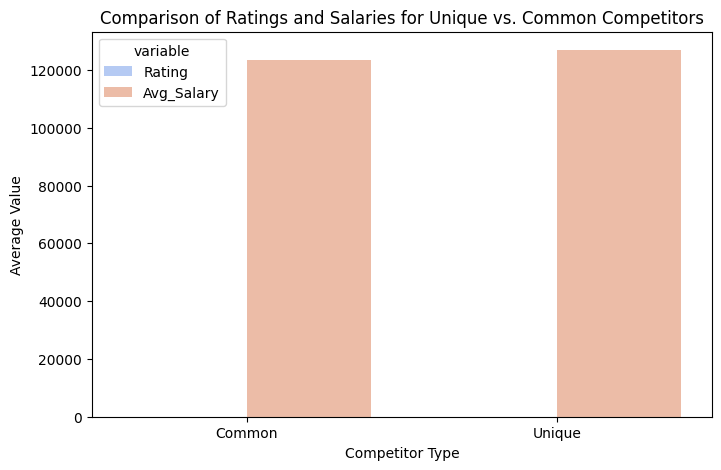

In [176]:
all_competitors = [comp.strip() for sublist in df['Competitors'].dropna() if sublist != '-1' for comp in sublist.split(',')]
competitor_counts = Counter(all_competitors)

df['Competitor_Uniqueness'] = df['Competitors'].apply(lambda x: 'Unique' if any(competitor_counts.get(comp.strip(), 0) == 1 for comp in str(x).split(',')) else 'Common')
unique_vs_common = df.groupby('Competitor_Uniqueness')[['Rating', 'Avg_Salary']].mean().reset_index()
print(unique_vs_common)

plt.figure(figsize=(8, 5))
sns.barplot(data=unique_vs_common.melt(id_vars='Competitor_Uniqueness'), x='Competitor_Uniqueness', y='value', hue='variable', palette='coolwarm')

plt.xlabel('Competitor Type')
plt.ylabel('Average Value')
plt.title('Comparison of Ratings and Salaries for Unique vs. Common Competitors')
# plt.legend(title="Metric")

plt.show()


DATA VISUALIZATION

Plot the distribution of company sizes (in terms of employee numbers) and see how it aligns with ”Type of Ownership” (e.g., private, public, nonprofit).


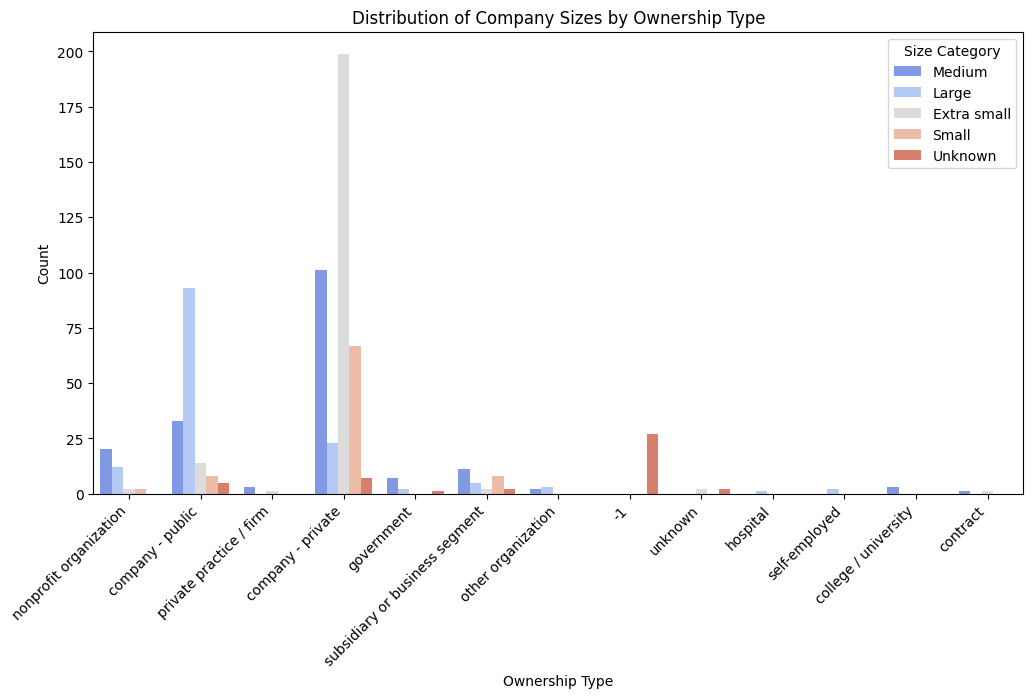

In [127]:


plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Type of ownership', hue='Size_category', palette='coolwarm')
plt.xticks(rotation=45, ha="right")
plt.xlabel('Ownership Type')
plt.ylabel('Count')
plt.title('Distribution of Company Sizes by Ownership Type')
plt.legend(title='Size Category')

plt.show()


Create a bar chart showing the average rating for each ”Type of Ownership” to see if ownership types correlate with employee satisfaction


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\2103267014.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ownership_rating, x='Type of ownership', y='Rating', palette='viridis')


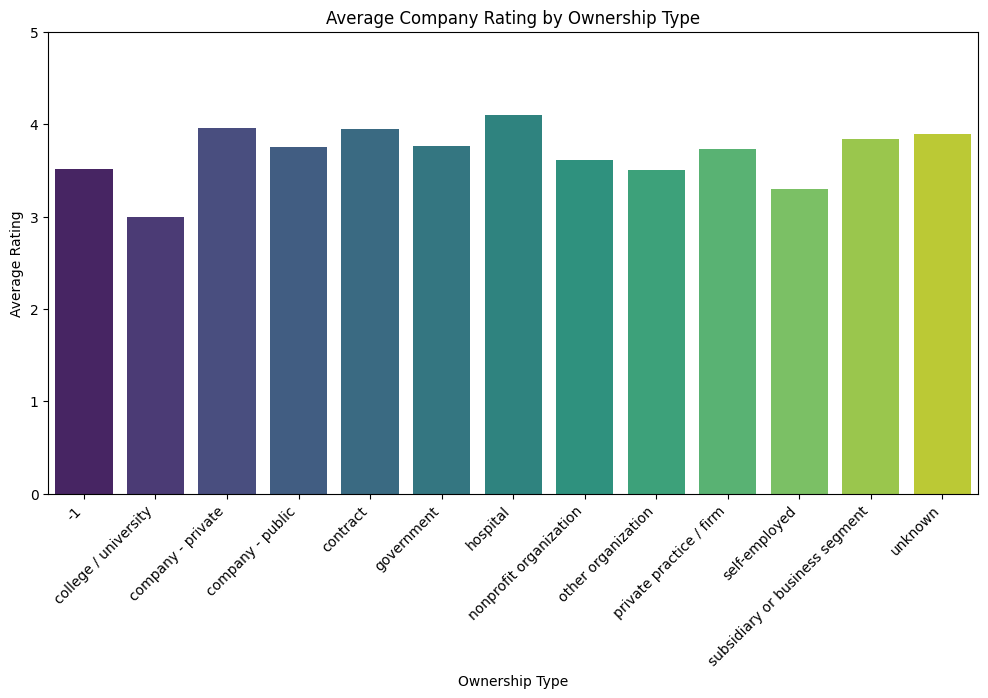

In [128]:
ownership_rating = df.groupby('Type of ownership')['Rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=ownership_rating, x='Type of ownership', y='Rating', palette='viridis')

plt.xticks(rotation=45, ha="right")
plt.xlabel('Ownership Type')
plt.ylabel('Average Rating')
plt.title('Average Company Rating by Ownership Type')
plt.ylim(0, 5)  

plt.show()


Generate a bar chart to compare the number of job postings across the top 10 cities, highlighting popular cities for data science roles.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\726212705.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.index, y=top_cities.values, palette="coolwarm")


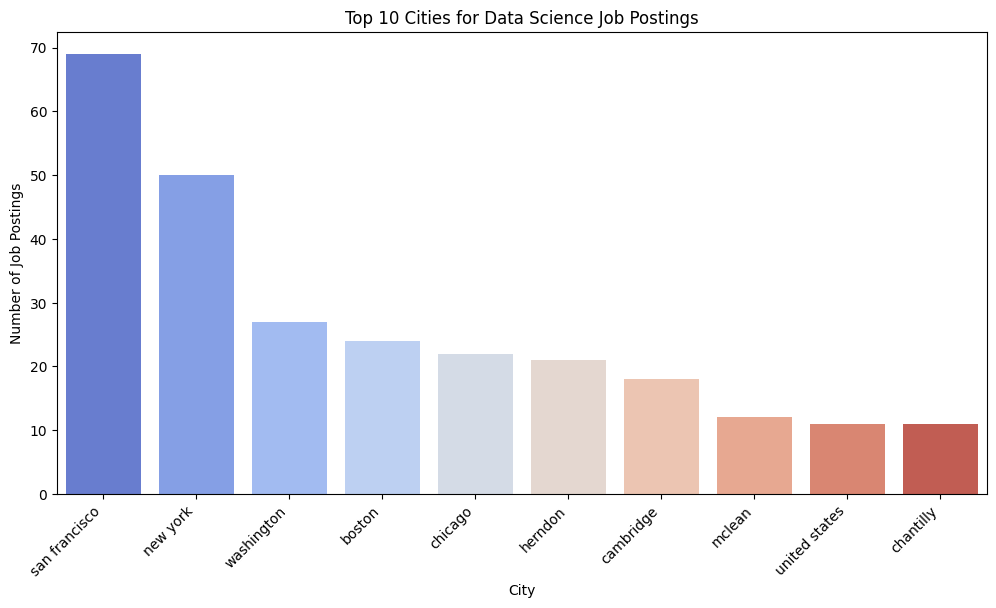

In [129]:
# 
df['City'] = df['New_Location'].str.split(',').str[0].str.strip()
top_cities = df['City'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.index, y=top_cities.values, palette="coolwarm")
plt.xlabel("City")
plt.ylabel("Number of Job Postings")
plt.title("Top 10 Cities for Data Science Job Postings")
plt.xticks(rotation=45, ha="right")

plt.show()

Create a map plot to show the geographic distribution of job postings by state, using color intensity to represent job density.


In [179]:
us_state_abbr = {
    "alabama": "AL", "alaska": "AK", "arizona": "AZ", "arkansas": "AR", "california": "CA",
    "colorado": "CO", "connecticut": "CT", "delaware": "DE", "florida": "FL", "georgia": "GA",
    "hawaii": "HI", "idaho": "ID", "illinois": "IL", "indiana": "IN", "iowa": "IA",
    "kansas": "KS", "kentucky": "KY", "louisiana": "LA", "maine": "ME", "maryland": "MD",
    "massachusetts": "MA", "michigan": "MI", "minnesota": "MN", "mississippi": "MS", "missouri": "MO",
    "montana": "MT", "nebraska": "NE", "nevada": "NV", "new hampshire": "NH", "new jersey": "NJ",
    "new mexico": "NM", "new york": "NY", "north carolina": "NC", "north dakota": "ND", "ohio": "OH",
    "oklahoma": "OK", "oregon": "OR", "pennsylvania": "PA", "rhode island": "RI", "south carolina": "SC",
    "south dakota": "SD", "tennessee": "TN", "texas": "TX", "utah": "UT", "vermont": "VT",
    "virginia": "VA", "washington": "WA", "west virginia": "WV", "wisconsin": "WI", "wyoming": "WY"
}

df['State'] = df['New_Location'].str.split(',').str[-1].str.strip().str.lower()
df['State_Abbr'] = df['State'].map(us_state_abbr)

df = df.dropna(subset=['State_Abbr'])

state_counts = df['State_Abbr'].value_counts().reset_index()
state_counts.columns = ['State', 'Job_Postings']

fig = px.choropleth(
    state_counts,
    locations='State',
    locationmode='USA-states',
    color='Job_Postings',
    color_continuous_scale="blues",
    title="Geographic Distribution of Job Postings by State",
)

fig.update_layout(geo_scope='usa')  
fig.show()


Create a scatter plot showing the relationship between average salary range and company ratings, and add a trend line to analyze if higherrated companies tend to offer higher salaries


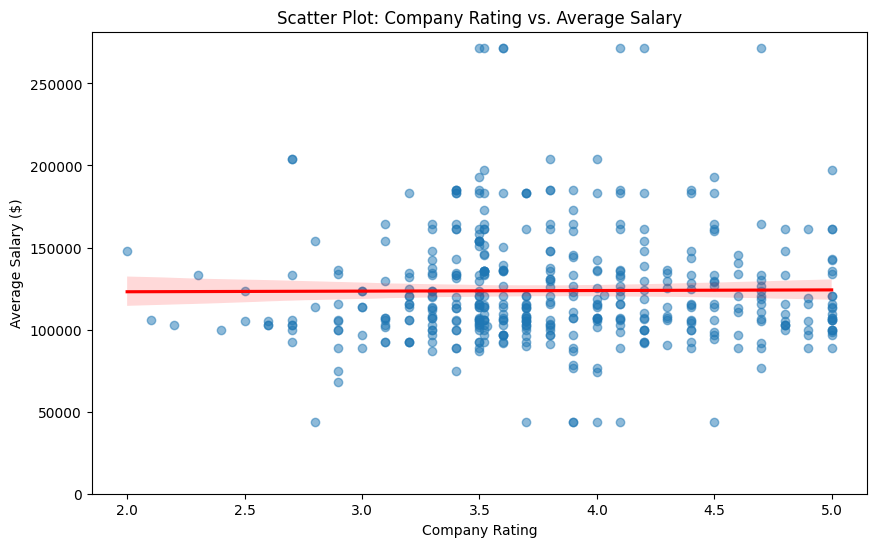

In [131]:
salary_rating = df.groupby('Company Name')[['Avg_Salary', 'Rating']].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.regplot(x=salary_rating['Rating'], y=salary_rating['Avg_Salary'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})


plt.xlabel("Company Rating")
plt.ylabel("Average Salary ($)")
plt.title("Scatter Plot: Company Rating vs. Average Salary")
plt.ylim(0, salary_rating['Avg_Salary'].max() + 10000)  # Adjust for visibility

plt.show()


Plot a histogram of salary ranges for different sectors, allowing comparison of sector-based salary distributions


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1146185679.py:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



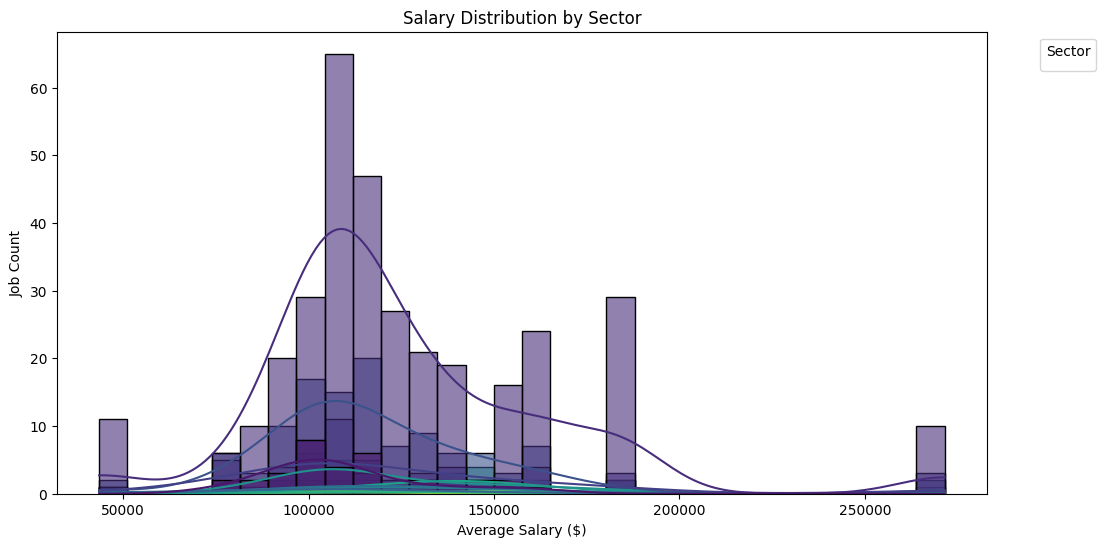

In [180]:
#
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Avg_Salary', hue='Sector', bins=30, kde=True, palette="viridis", alpha=0.6)
plt.xlabel("Average Salary ($)")
plt.ylabel("Job Count")
plt.title("Salary Distribution by Sector")
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left') 

plt.show()

Generate a heatmap to visualize the correlation matrix between numerical columns (e.g., ratings, salary estimates, founding year) to identify potential relationships.


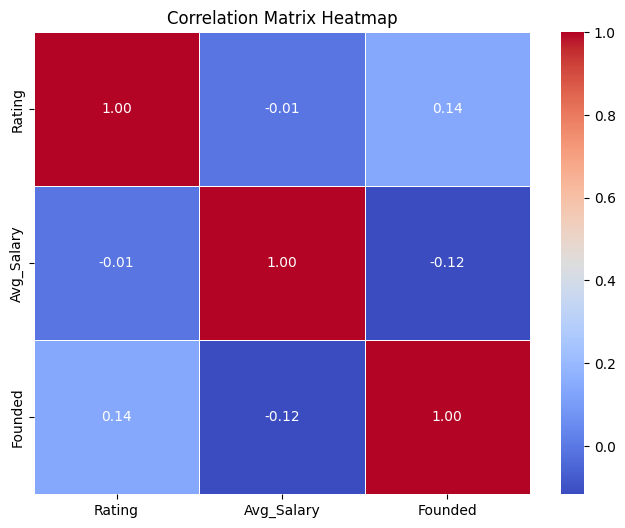

In [133]:
numeric_cols = ['Rating', 'Avg_Salary', 'Founded']  # Add more relevant columns if needed
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

Plot a line graph of the average rating of companies over time by ”Founded Year” to see if there’s a trend in ratings for companies founded in different decades.


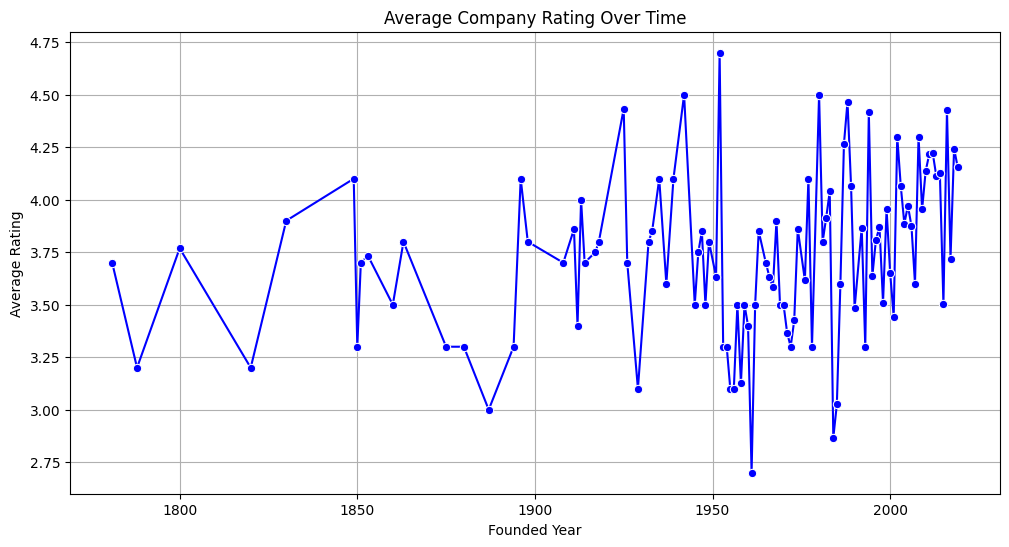

In [134]:
rating_trend = df.groupby('Founded')['Rating'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=rating_trend, x='Founded', y='Rating', marker='o', color='b')
plt.xlabel('Founded Year')
plt.ylabel('Average Rating')
plt.title('Average Company Rating Over Time')
plt.grid(True)
plt.show()

Create a box plot showing the salary range distributions by industry, highlighting which industries have the widest salary range.


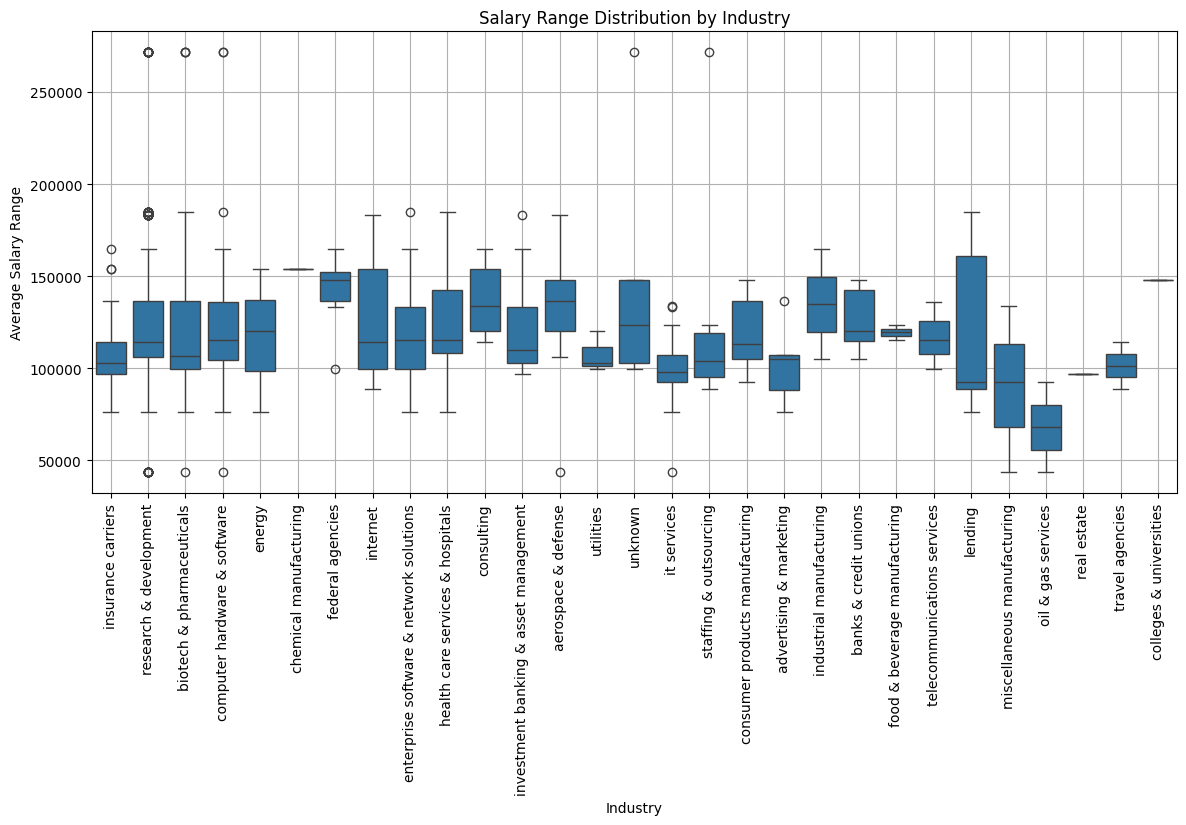

In [135]:

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Industry', y='Avg_Salary')

plt.xticks(rotation=90)
plt.xlabel('Industry')
plt.ylabel('Average Salary Range')
plt.title('Salary Range Distribution by Industry')
plt.grid(True)

plt.show()

 Generate a stacked bar chart of job titles within each sector to observe which titles are most common in different industries.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25920\1137715527.py:13: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



<Figure size 1400x800 with 0 Axes>

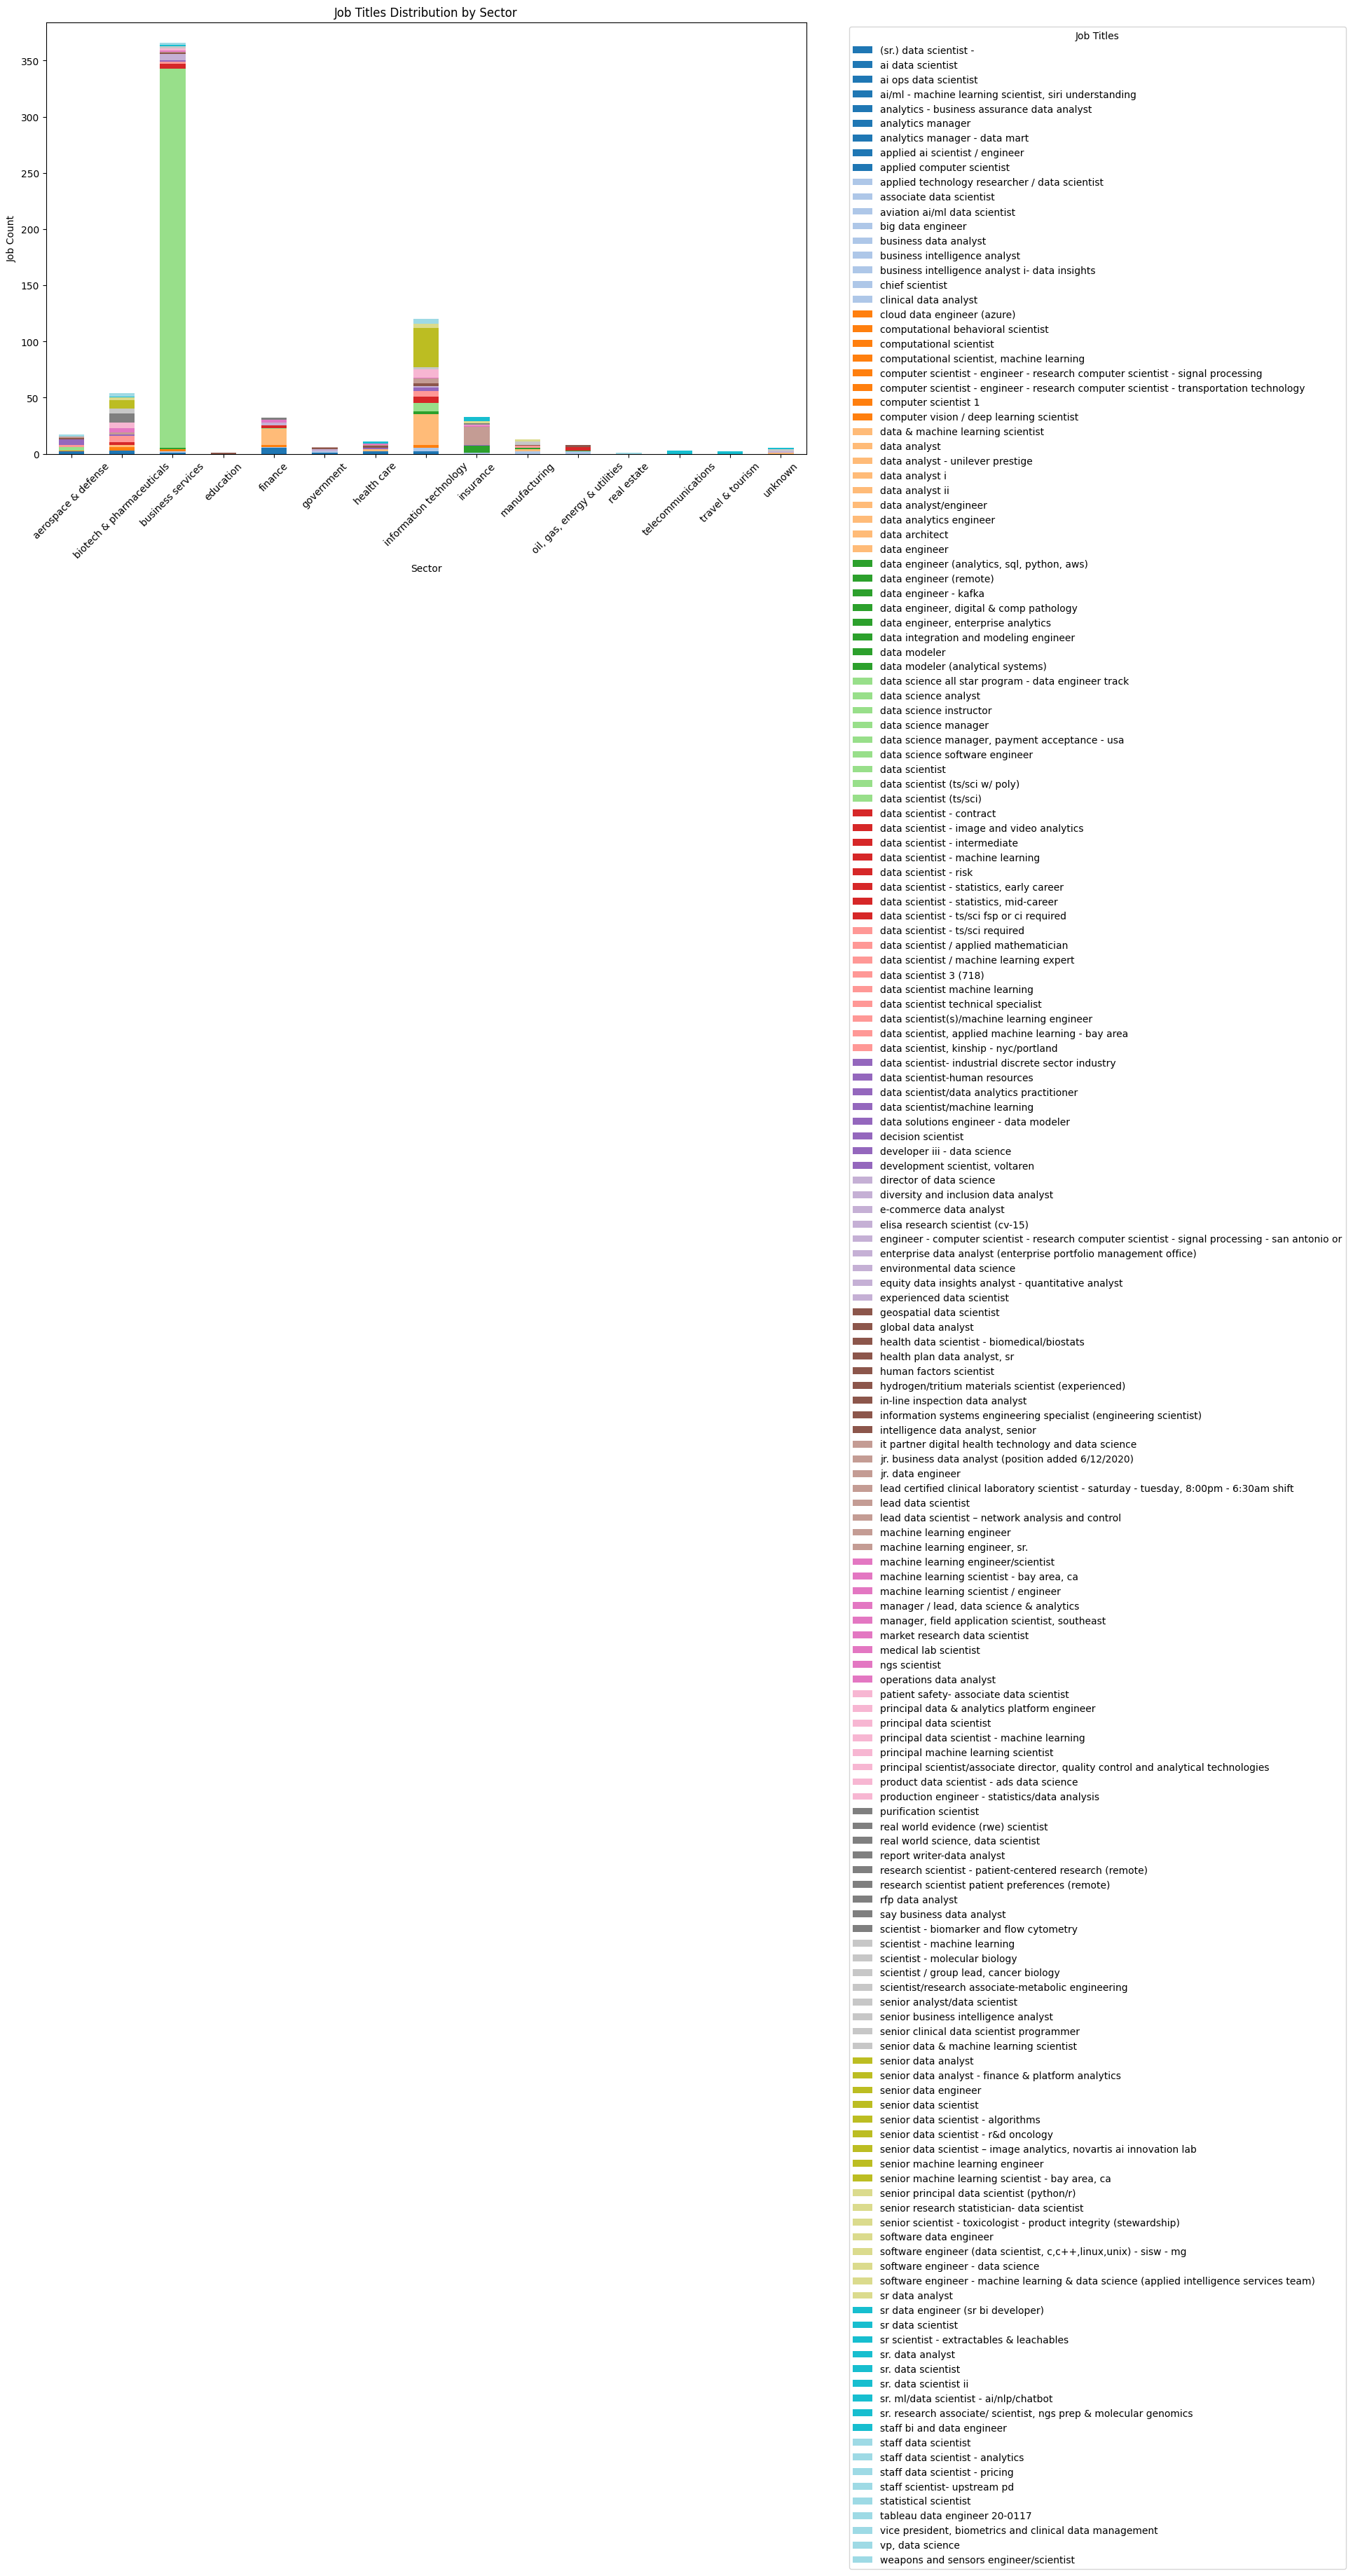

In [154]:
job_titles_in_sector = df.groupby(['Sector', 'Job Title']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
job_titles_in_sector.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

plt.title('Job Titles Distribution by Sector')
plt.xlabel('Sector')
plt.ylabel('Job Count')
plt.xticks(rotation=45)
plt.legend(title='Job Titles', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Create a network graph to show connections between companies and their competitors, with node sizes based on the company’s average rating.


In [137]:
df_filtered = df[df['Competitors'] != '-1']
G = nx.Graph()

for _, row in df_filtered.iterrows():
    company = row['Cleaned_Company Name']
    competitors = str(row['Competitors']).split(', ')
    rating = row['Rating']

    G.add_node(company, size=rating *100) 

    for competitor in competitors:
        G.add_edge(company, competitor)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42) 
sizes = [G.nodes[n]['size'] if 'size' in G.nodes[n] else 100 for n in G.nodes]
nx.draw(G, pos, node_size=sizes, with_labels=True, edge_color='gray', alpha=0.3, font_size=5)
plt.title("Company-Competitor Network Graph")
plt.show()



Plot a bar chart showing the top 10 most common competitors listed, along with the average rating of companies that have these competitors


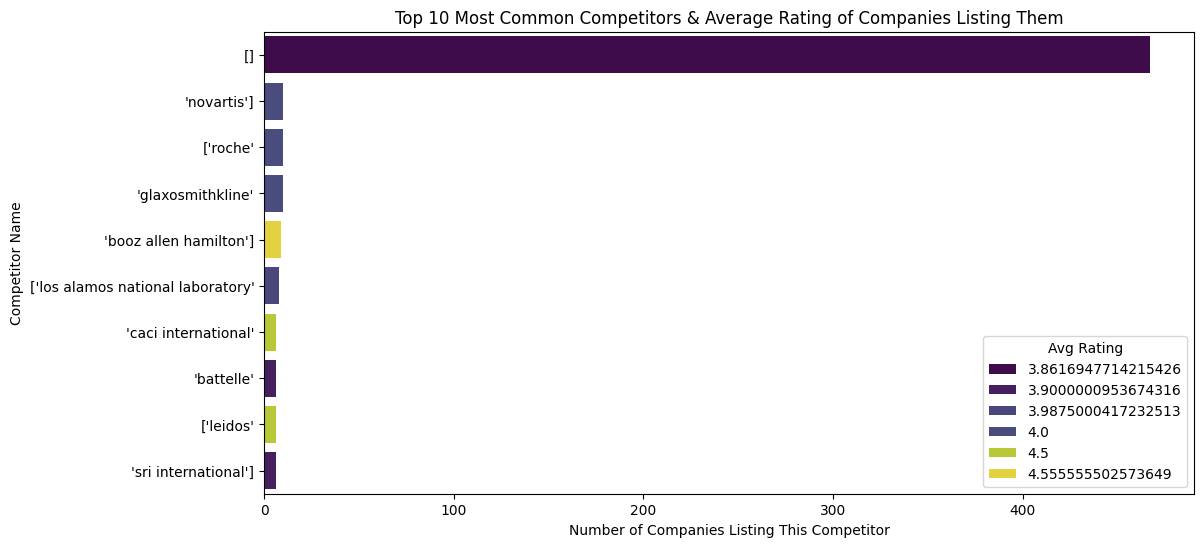

In [181]:
competitor_list = []
ratings_dict = {}

for _, row in df.iterrows():
    if row['Competitors'] != '-1':  
        competitors = str(row['Competitors']).split(', ')
        competitor_list.extend(competitors)
        for comp in competitors:
            if comp in ratings_dict:
                ratings_dict[comp].append(row['Rating'])
            else:
                ratings_dict[comp] = [row['Rating']]

competitor_counts = Counter(competitor_list)
competitor_df = pd.DataFrame(competitor_counts.items(), columns=['Competitor', 'Count'])

competitor_df['Avg_Rating'] = competitor_df['Competitor'].map(lambda x: sum(ratings_dict[x]) / len(ratings_dict[x]))

top_10_competitors = competitor_df.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_competitors, x='Count', y='Competitor', hue='Avg_Rating', palette='viridis', dodge=False)

plt.xlabel('Number of Companies Listing This Competitor')
plt.ylabel('Competitor Name')
plt.title('Top 10 Most Common Competitors & Average Rating of Companies Listing Them')
plt.legend(title='Avg Rating', loc='lower right')
plt.show()

Create a stacked area chart to show how job postings by company size (”Size”) are distributed over time (based on ”Founded Year”).


<Figure size 1200x600 with 0 Axes>

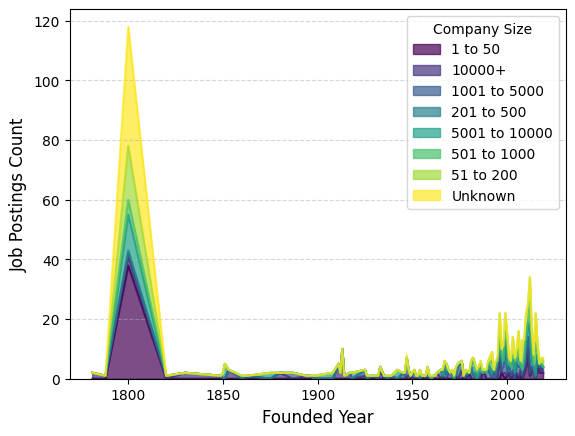

In [150]:

df_filtered = df[df['Founded'] > 0] 
size_over_time = df_filtered.groupby(['Founded', 'Size']).size().unstack(fill_value=0)  # Count postings by size

plt.figure(figsize=(12, 6))
size_over_time.plot(kind='area', stacked=True, colormap='viridis', alpha=0.7)

plt.xlabel('Founded Year', fontsize=12)
plt.ylabel('Job Postings Count', fontsize=12)
plt.legend(title='Company Size')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Plot a donut chart representing the distribution of job postings by ”Type of Ownership” to visualize how job availability varies by ownership type.


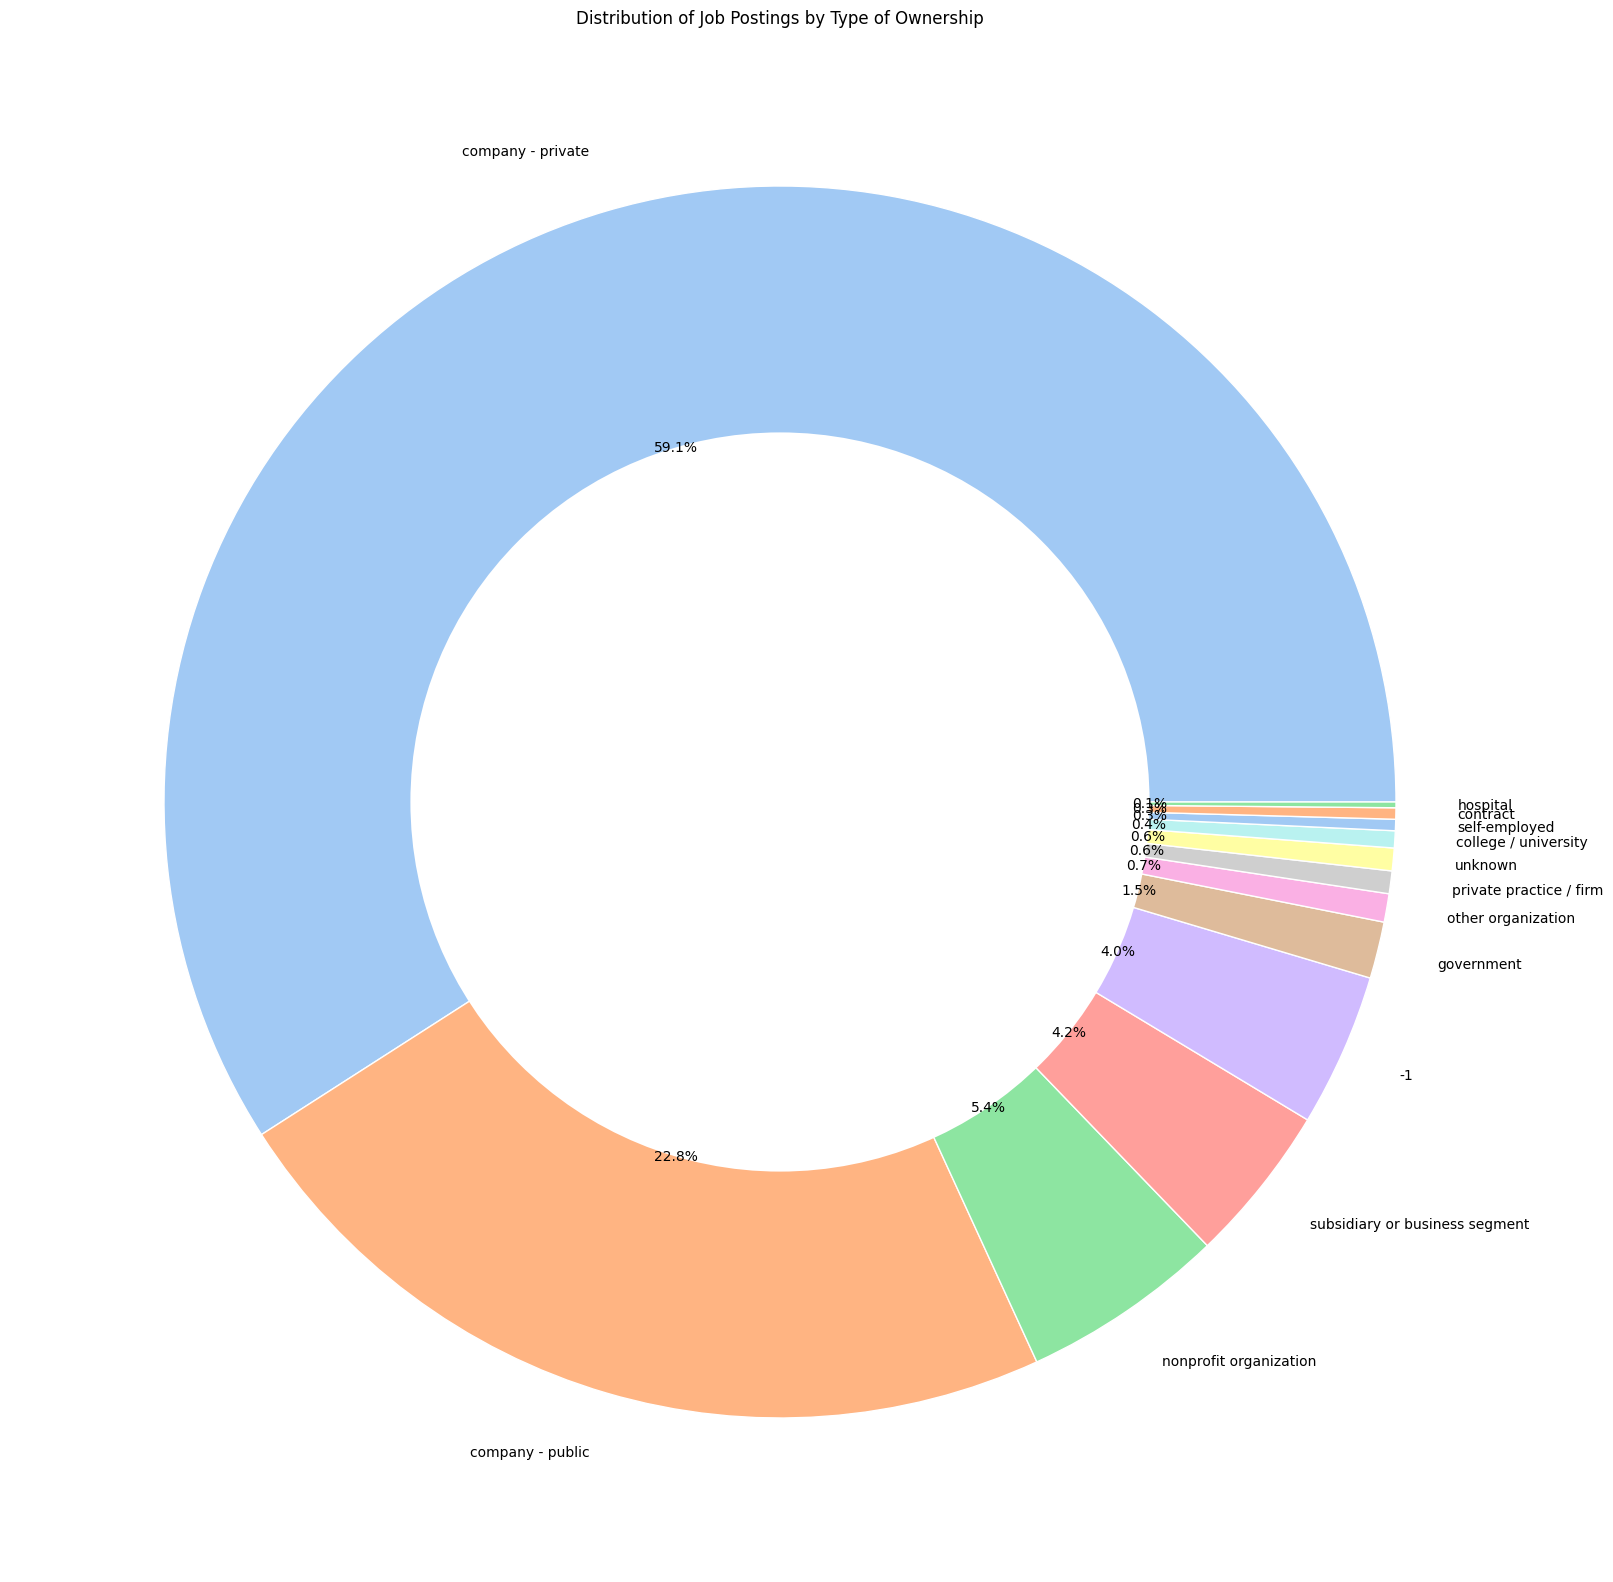

In [140]:

ownership_counts = df['Type of ownership'].value_counts()
colors = sns.color_palette('pastel')

plt.figure(figsize=(20,20))
plt.pie(ownership_counts, labels=ownership_counts.index, autopct='%1.1f%%', colors=colors, wedgeprops={'edgecolor': 'white'})
center_circle = plt.Circle((0, 0), 0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.title('Distribution of Job Postings by Type of Ownership')
plt.show()

Generate a radar chart (spider chart) comparing key metrics (e.g., average rating, median salary, company size) across top sectors to easily compare sector strengths.


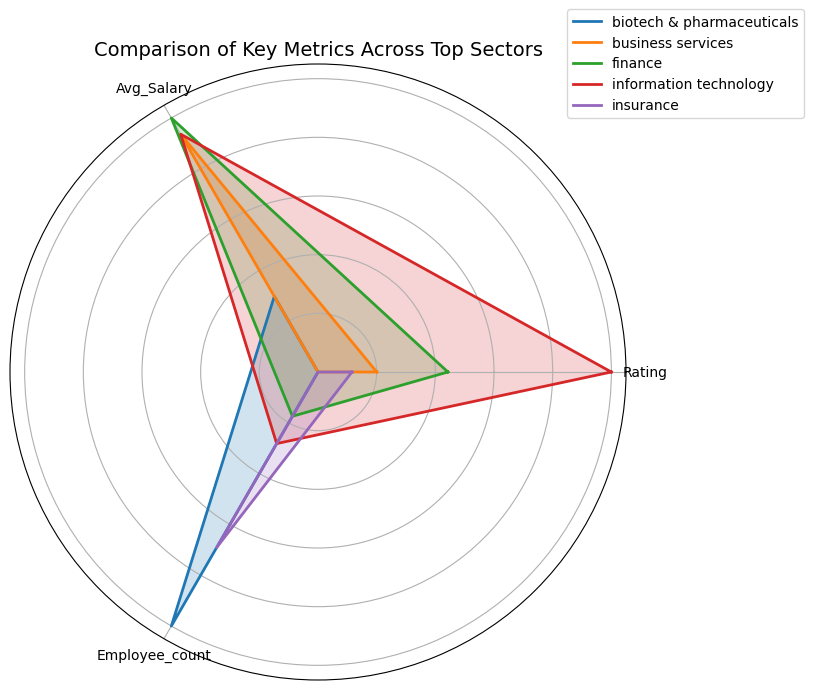

In [146]:
top_sectors = df['Sector'].value_counts().head(5).index  # Select top 5 sectors
sector_metrics = df[df['Sector'].isin(top_sectors)].groupby('Sector').agg({
    'Rating': 'mean',
    'Avg_Salary': 'median',
    'Employee_count': 'mean'  
}).reset_index()


def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

sector_metrics[['Rating', 'Avg_Salary', 'Employee_count']] = sector_metrics[['Rating', 'Avg_Salary', 'Employee_count']].apply(normalize)


labels = ['Rating', 'Avg_Salary', 'Employee_count']
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() 
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))


for i, row in sector_metrics.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row['Sector'], linewidth=2)
    ax.fill(angles, values, alpha=0.2)  
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('Comparison of Key Metrics Across Top Sectors', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


In [335]:
df1=pd.read_csv('DS-jobs - DS-jobs.csv')

df1=df1[df1['Rating']==-1]
df1[['Company Name','Rating']]

Company Name  Rating
154           Covid-19 Search Partners    -1.0
158                Radical Convergence    -1.0
230                       Encode, Inc.    -1.0
282                     Trovetechs Inc    -1.0
285                     Trovetechs Inc    -1.0
290                           PETADATA    -1.0
319                       Microagility    -1.0
322           Rainmaker Resources, LLC    -1.0
329                             B4Corp    -1.0
338                      Stride Search    -1.0
351                   Point72 Ventures    -1.0
357                     Hatch Data Inc    -1.0
358                     Hatch Data Inc    -1.0
359                     Hatch Data Inc    -1.0
360                     Hatch Data Inc    -1.0
361                     Hatch Data Inc    -1.0
362                     Hatch Data Inc    -1.0
388                             HireAi    -1.0
389                             HireAi    -1.0
409                              Navio    -1.0
411                           Evolvinc    -1.0
425                       Microagility    -1.0
430     Falcon IT & Staffing Solutions    -1.0
431           Rainmaker Resources, LLC    -1.0
437                             B4Corp    -1.0
438                Blue Icy Water, LLC    -1.0
440                       Sonde Health    -1.0
457                      Stride Search    -1.0
459                     Blue Cloak LLC    -1.0
495                     Hatch Data Inc    -1.0
496                     Hatch Data Inc    -1.0
497                     Hatch Data Inc    -1.0
498                     Hatch Data Inc    -1.0
499                     Hatch Data Inc    -1.0
500                     Hatch Data Inc    -1.0
504                           Sophinea    -1.0
519            Monte Rosa Therapeutics    -1.0
524                         CompuForce    -1.0
555                             HireAi    -1.0
568                               Kibo    -1.0
613                   GrainBridge, LLC    -1.0
615  Sprezzatura Management Consulting    -1.0
637                           Sophinea    -1.0
650            Monte Rosa Therapeutics    -1.0
656                Berico Technologies    -1.0
657             Kehe Food Distributors    -1.0
660                       Pactera Edge    -1.0
664                Clear Ridge Defense    -1.0
668                               JKGT    -1.0
669                         AccessHope    -1.0